# 长短期记忆网络LSTM&GRU（下）

**目录**

**1 长短期记忆网络LSTM**<br>

&emsp;&emsp; 1.1 权重冲突与LSTM的解决方案<br>
&emsp;&emsp; 1.2 LSTM的计算单元与基本结构<br>
&emsp;&emsp; 1.3 LSTM的计算流程与数学本质探讨<br>
&emsp;&emsp; 1.4 在PyTorch中实现LSTM<br>
&emsp;&emsp;&emsp;&emsp; 1.4.1 nn.LSTM的参数群<br>
&emsp;&emsp;&emsp;&emsp; 1.4.2 nn.LSTM的输入、输出与架构实现<br>

============以下内容在《长短期记忆网络LSTM&GRU （下）》==============

&emsp;&emsp; 1.5 实战：nn.LSTM的预测与挑战<br>
&emsp;&emsp;&emsp;&emsp; 1.5.1 单变量时间序列预测流程<br>
&emsp;&emsp;&emsp;&emsp; 1.5.2 多变量时序与面板数据的预测流程<br>
&emsp;&emsp;&emsp;&emsp; 1.5.3 单步预测、多步预测与递归预测法<br>
&emsp;&emsp;&emsp;&emsp; 1.5.4 LSTM在股价数据上的预测实战<br>
&emsp;&emsp; 1.6 深度：LSTM究竟如何解决梯度问题？<br>

**2 循环门控单元GRU**<br><br>

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/00.png)

长短期记忆网络（Long Short-Term Memory Network，简称LSTM）是一种特殊的循环神经网络，它于1997年被慕尼黑技术大学的两位神经网络研究者提出，是当代深度学习领域中对时序数据和文字数据都具有重要作用的核心架构之一。在NLP的世界中，RNN为神经网络赋予了“记忆”的能力，LSTM则实现了对这种“记忆”方式的改良和优化——在RNN的基础上，LSTM的研究者们从权重冲突问题出发，提出了恒定梯度回路（Constant Error Carousel，CEC）、记忆细胞、门控单元、内部状态漂移等关键概念，从数学原理、架构设计、应用效率等多个方面革新了循环神经网络，大幅提升了循环网络的效果与性能。经过复杂的数学改造和工程优化，LSTM可以轻松处理拥有数千个时间步的长序列、还能有效缓解RNN中严重的梯度动荡问题，给致力于稳定神经网络训练流程的学者们带来无穷启发。在诞生26年之后，LSTM的论文原文依然是梯度研究方向的金典之作，LSTM算法本身也逐渐发展成为深度学习序列数据领域的根基架构。

今天，尽管自然语言处理领域众多大型模型和更先进的Transformer架构已经占据主流，但面临时间序列问题时，LSTM依然是众多深度学习竞赛和企业应用场景中的首选算法；在许多实际应用场景当中，模块化的LSTM也能够与CNN、GAN等架构有机结合，有效地创造在某些场景下超越transformer算法的效率或性能；同时，在LSTM基础上改进而诞生的GRU等算法，也在时间序列应用场景中有一席之地。LSTM的崛起和其持久的影响无疑为整个循环网络系列在序列数据研究领域确立了不可撼动的地位。今天，让我们一起来探索这一卓越结构背后的奥秘。

## 1.5 实战：nn.LSTM的预测与挑战

### 1.5.1 跑通单变量时间序列预测流程

In [1]:
import numpy as np #数据处理
import pandas as pd #数据处理
import matplotlib as mlp
import matplotlib.pyplot as plt #绘图
from sklearn.preprocessing import MinMaxScaler #·数据预处理
from sklearn.metrics import mean_squared_error
import torch 
import torch.nn as nn #导入pytorch中的基本类
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.utils.data as data

In [2]:
print(np.__version__)
print(pd.__version__)
print(mlp.__version__)
print(torch.__version__)

1.22.4
2.1.4
3.8.2
2.2.0+cu121


- **导入数据**

In [3]:
df = pd.read_csv(r'D:\pythonwork\2021DL\NLP\lstm\airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

In [4]:
df.head() #单变量时间序列数据无需对时间维度进行处理

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


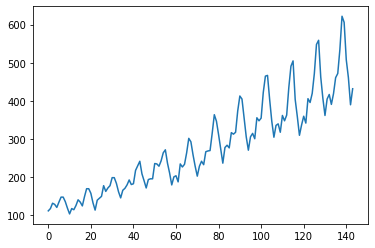

In [5]:
plt.plot(timeseries) #非常有规律的一个数据，对于LSTM来说相对容易
plt.show()

- **数据分割与滑窗**

In [6]:
#按时间顺序对训练集测试集进行分割
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

> - 什么是滑窗？滑窗在机器学习/深度学习世界中的意义是什么？

滑动窗口技术涉及将连续的数据流划分为多个“窗口”，每个窗口包含一段时间序列的子集。在时间序列预测中，滑动窗口用于创建预测模型的训练样本。例如，如果我们想预测未来某个时间点的值，我们可以使用过去几个时间点的数据作为输入特征。在机器学习和深度学习的世界中，我们都常用滑窗的手段，针对不同的算法，滑窗手法带来的效果却截然不同。以下面的数据为例——

|时间|特征1|特征2|
|:-:|:-:|:-:|
|Date0|xxx|xxx|
|Date1|xxx|xxx|
|Date2|xxx|xxx|
|...|xxx|xxx|
|Daten|xxx|xxx|

在机器学习的世界中，滑窗带有“去时序化”的意味，这是因为机器学习算法（如lgbm，随机森林等等）是研究特征与标签之间关系的算法，机器学习算法群并不研究样本与样本之间的关联，而时间序列的内在逻辑是样本与样本之间的关联逻辑，因此在机器学习当中，我们利用滑窗“去时序化”后，将从上至下的时间序列关联滑窗为从左到右的特征与标签之间的关联。具体来看，在机器学习中，滑窗之后的数据往往呈现如下结构：

|时间|...|Date7前1天<br>特征1|Date7前2天<br>特征1|Date7前3天<br>特征1|...|Date7前1天<br>特征2|Date7前2天<br>特征2|Date7前3天<br>特征2|....|标签|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|Date0|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|
|……|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|
|Date7|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|
|Date8|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|
|Date9|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|
|...|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|
|Date10|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|xxx|

但在深度学习、尤其是序列数据的世界中，我们的滑窗操作会生成的数据结构是：

> - **表单1**

|时间|特征1|特征2|
|:-:|:-:|:-:|
|**Date0**|xxx|xxx|
|**Date1**|xxx|xxx|
|**Date2**|xxx|xxx|
|...|xxx|xxx|
|**Date7**|xxx|xxx|
|**标签**|xxx|xxx|

> - **表单2**

|时间|特征1|特征2|
|:-:|:-:|:-:|
|**Date1**|xxx|xxx|
|**Date2**|xxx|xxx|
|**Date3**|xxx|xxx|
|...|xxx|xxx|
|**Date8**|xxx|xxx|
|**标签**|xxx|xxx|

> - **表单3**

|时间|特征1|特征2|
|:-:|:-:|:-:|
|**Date2**|xxx|xxx|
|**Date3**|xxx|xxx|
|**Date4**|xxx|xxx|
|...|xxx|xxx|
|**Date9**|xxx|xxx|
|**标签**|xxx|xxx|

这两种滑窗结构有明显的不同，其核心特点是“**时间维度的不同**”和“**能否打乱纵向的样本排列顺序**”，因两种不同的滑窗结构，这两种数据也适用于不同的机器学习和深度学习算法。

在本次单变量时间序列数据案例当中，我们采用的是第二种方法进行滑窗。在滑窗技巧中，有两个关键的因素非常重要，一个是“窗的大小”，另一个是“滑动的步长”。在大多数的时候我们只会考虑窗的大小，而一般不对步长进行修改。

In [7]:
#单变量时间序列滑窗函数

import torch
def create_dataset(dataset, lookback):
    """
    将时间序列转变为能够用于训练和预测的数据
    
    参数:
        dataset: ndarry，第一个维度是时间
        lookback: 滑窗的窗的大小
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+lookback]
        X.append(feature)
        y.append(target)
    return torch.FloatTensor(X), torch.FloatTensor(y)

> - 滑窗函数代码解析

In [8]:
#创建训练集与测试集
lookback = 7
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([89, 7, 1]) torch.Size([89, 1])
torch.Size([41, 7, 1]) torch.Size([41, 1])


C:\Users\Shuyu\AppData\Local\Temp/ipykernel_6556/807671440.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.FloatTensor(X), torch.FloatTensor(y)


In [9]:
for x_, y_ in zip(X_train,y_train):
    print(x_,y_)
    break

y_train[0]

tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.],
        [135.],
        [148.]]) tensor([148.])


tensor([148.])

- **定义网络架构与训练元素**

In [10]:
#选择了最为简单的网络架构来进行实验
import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        #现在我要的是最后一个时间步，而不是全部时间步了
        x = self.linear(x[:,-1,:])
        return x

In [11]:
#设置GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
#设置参数
input_size = 1  #输入特征的维度
hidden_size = 50 #LSTM隐藏状态的维度
num_layers = 1 #LSTM层的数量
output_size = 1 #模型的输出维度
n_epochs = 2000 #迭代epoch
learning_rate = 0.001 #学习率

In [13]:
#实例化模型
model = AirModel().to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate) #定义优化器
loss_fn = nn.MSELoss() #定义损失函数
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8) #将数据分批次

In [14]:
for x,y in loader:
    print(x.shape)
    print(y)
    break

torch.Size([8, 7, 1])
tensor([[278.],
        [272.],
        [170.],
        [284.],
        [237.],
        [237.],
        [405.],
        [163.]])


- **实际训练流程**

In [15]:
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #验证与打印
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train.to(device)).cpu()
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test.to(device)).cpu()
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 230.6871, test RMSE 428.1719
Epoch 100: train RMSE 186.3848, test RMSE 381.9995
Epoch 200: train RMSE 151.1752, test RMSE 344.1753
Epoch 300: train RMSE 121.1458, test RMSE 310.0979
Epoch 400: train RMSE 97.1596, test RMSE 279.7661
Epoch 500: train RMSE 71.7610, test RMSE 244.0079
Epoch 600: train RMSE 54.1290, test RMSE 213.7954
Epoch 700: train RMSE 42.5880, test RMSE 189.9502
Epoch 800: train RMSE 34.5263, test RMSE 174.0308
Epoch 900: train RMSE 29.6102, test RMSE 168.0432
Epoch 1000: train RMSE 26.7461, test RMSE 166.1550
Epoch 1100: train RMSE 24.2542, test RMSE 129.0434
Epoch 1200: train RMSE 22.3936, test RMSE 125.6235
Epoch 1300: train RMSE 20.4953, test RMSE 123.2715
Epoch 1400: train RMSE 19.6993, test RMSE 129.3750
Epoch 1500: train RMSE 20.4422, test RMSE 119.5530
Epoch 1600: train RMSE 18.7017, test RMSE 120.9721
Epoch 1700: train RMSE 16.7310, test RMSE 122.6357
Epoch 1800: train RMSE 18.0676, test RMSE 113.3432
Epoch 1900: train RMSE 14.3248, test RM

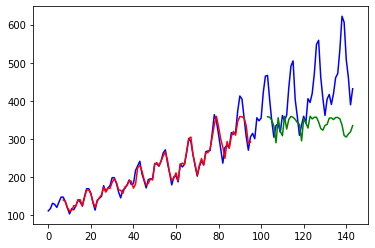

In [16]:
with torch.no_grad():
    # 绘制训练集上的损失的图像
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train.to(device)).cpu()
    train_plot[lookback:train_size] = model(X_train.to(device)).cpu()
    # 绘制测试集上的损失的图像
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test.to(device)).cpu()
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

- **从序列到点的预测转变为序列到序列的预测**

序列到序列（Seq2Seq）预测和序列到点（Seq2Point）预测在处理时间序列数据时各有优势。特别是对于LSTM这样的循环神经网络，这两种方法都可以被有效地利用。让我们来比较一下它们各自的优势：

> 序列到序列（Seq2Seq）预测

捕获长期依赖关系：Seq2Seq模型特别适合于那些需要理解整个输入序列来生成整个输出序列的任务。LSTM的优势在于能够捕获长期的时间依赖性，这使得它在Seq2Seq预测中非常有效。

连续输出预测：当需要连续预测多个未来时间点时，Seq2Seq模型可以一次性提供整个输出序列，这对于需要连续决策或规划的应用非常有用。

灵活性和泛化能力：Seq2Seq模型可以被训练来处理不同长度的输入和输出序列，提供更高的灵活性和泛化能力。

多功能性：Seq2Seq模型不仅限于时间序列预测，还可以用于其他任务，如机器翻译、文本摘要等。

> 序列到点（Seq2Point）预测

简单性和高效性：Seq2Point模型通常比Seq2Seq模型更简单，易于实现和训练。这种方法在计算上更高效，因为它仅预测单个输出值。

准确性：在某些情况下，Seq2Point模型可能比Seq2Seq模型提供更准确的单点预测，因为它专注于预测一个特定的未来时刻，而不是整个序列。

降低过拟合风险：由于模型结构较为简单，Seq2Point模型可能较少受到过拟合的影响，尤其是在数据量较少的情况下。

适用性：Seq2Point预测非常适用于那些只需预测一个未来时刻的任务，例如短期负载预测或股价预测。

选择Seq2Seq还是Seq2Point模型取决于具体的应用需求。如果任务涉及到对未来一系列时间点的连续预测，Seq2Seq模型是更好的选择。然而，如果任务只需要预测一个特定的未来时刻，Seq2Point模型可能更为合适，因为它更简单、更高效，并且可能更准确。在实际应用中，考虑数据的特性、预测的需求和可用资源是非常重要的。

In [23]:
import torch
def create_dataset_2(dataset, lookback):
    """
    序列到序列预测的滑窗函数
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.FloatTensor(X), torch.FloatTensor(y)

In [24]:
lookback = 7
X_train, y_train = create_dataset_2(train, lookback=lookback)
X_test, y_test = create_dataset_2(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([89, 7, 1]) torch.Size([89, 7, 1])
torch.Size([41, 7, 1]) torch.Size([41, 7, 1])


In [25]:
for x_, y_ in zip(X_train,y_train):
    print(x_, "\n \n", y_)
    break

tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.],
        [135.],
        [148.]]) 
 
 tensor([[118.],
        [132.],
        [129.],
        [121.],
        [135.],
        [148.],
        [148.]])


In [26]:
import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [27]:
#device = "cpu"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [28]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
 
model = AirModel().to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train.to(device)).cpu()
        train_rmse = np.sqrt(loss_fn(y_pred
                                     , y_train))
        y_pred = model(X_test.to(device)).cpu()
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 224.9484, test RMSE 423.7722
Epoch 100: train RMSE 173.1140, test RMSE 369.5092
Epoch 200: train RMSE 134.2954, test RMSE 327.0072
Epoch 300: train RMSE 103.4965, test RMSE 290.0037
Epoch 400: train RMSE 81.3895, test RMSE 258.3668
Epoch 500: train RMSE 60.9159, test RMSE 226.7708
Epoch 600: train RMSE 47.5437, test RMSE 199.8397
Epoch 700: train RMSE 38.2225, test RMSE 176.3271
Epoch 800: train RMSE 31.4673, test RMSE 156.2888
Epoch 900: train RMSE 26.5780, test RMSE 138.4252
Epoch 1000: train RMSE 23.5056, test RMSE 124.4376
Epoch 1100: train RMSE 21.3841, test RMSE 112.5682
Epoch 1200: train RMSE 19.7581, test RMSE 102.8073
Epoch 1300: train RMSE 18.8710, test RMSE 95.5631
Epoch 1400: train RMSE 18.0123, test RMSE 90.0656
Epoch 1500: train RMSE 17.2829, test RMSE 85.8698
Epoch 1600: train RMSE 16.8763, test RMSE 82.7027
Epoch 1700: train RMSE 16.7837, test RMSE 80.6858
Epoch 1800: train RMSE 16.6101, test RMSE 79.3835
Epoch 1900: train RMSE 16.7060, test RMSE 76.

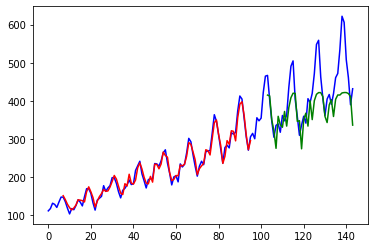

In [29]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train.to(device)).cpu()
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train.to(device)).cpu()[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test.to(device)).cpu()[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

### 1.5.2 多变量时序与面板数据的预测流程

#### 1.5.2.1 单变量、多变量与面板数据

在之前的课程中我们讲解了LSTM在单变量时间序列数据上预测的代码，这是一套最为基础、最为入门级的LSTM运行代码，我们借助它了解了滑窗这一重要操作以及时间序列预测中的多种概念，但这套代码却很难被用到深度学习领域中各种各样复杂的时间序列场景下。在深度学习的世界当中，单变量数据集往往比较少见，同时深度学习世界所面临的数据往往量大且复杂，因此一套单变量数据集的预测代码更多是帮助我们梳理使用LSTM时的实际预测流程，而非实际投入应用。今天我们将在我们原本理解的单变量数据预测的基础上继续拓展、以讲解多变量以及更复杂的数据集被应用于LSTM时我们应该做出的一系列处理。

首先在时间序列的世界中，除了最常见的单变量时间序列之外，我们还有多变量时间序列数据和面板数据两种复杂经典数据结构。我们在深度学习/机器学习以及无数的时间序列课程中都曾讲解过这几种数据的关键定义与区别。

> - **单变量时间序列**：只包含时间索引和唯一列的序列，在这样的序列中，时间与标签是一一绑定的，我们只需要知道时间即可确定唯一的标签。对于单变量数据集，我们需要预测的标签也就是数据集中唯一的列，这样的数据没有特征，是理解难度最小、但预测难度最大的时间序列数据类型。这种数据集中，日期往往是从上到下、从过去到未来地进行排列。由于日期能够确定唯一的标签，因此这种数据集中的日期一定不会重复。如果出现了重复的日期，则需要深入调查、或予以删除。

| 日期     | 平均温度<br>（标签） |
|---------|--------|
| Date0   | 22°C   |
| Date1   | 21°C   |
| Date2   | 23°C   |
| ...     | ...    |
| DateN   | 25°C   |

> - **多变量时间序列**：多变量时间序列数据的定义在过去的几年中发生了几次变化，在今天它大多数时间指代**一个时间点下拥有多个不同的特征**的时间序列数据。例如，我们想要预测一支股票在不同日期下的收盘价时，我们可以在一个日期下收集到多重的信息，比如开盘价、当日最高价、当日最底价、成交量、交易额等等，来构成如下的数据集——

| 日期     | 开盘价 | 最高价 | 最低价 | 收盘价<br>（标签）  | 交易量    | 成交额      |
|---------|------|------|------|------|--------|----------|
| Date0   | 100  | 105  | 99   | 103  | 500000 | 52000000 |
| Date1   | 103  | 108  | 102  | 107  | 600000 | 64200000 |
| Date2   | 107  | 109  | 106  | 108  | 550000 | 59400000 |
| ...     | ...  | ...  | ...  | ...  | ...    | ...      |
| DateN   | 110  | 115  | 109  | 114  | 620000 | 70680000 |

此时除了我们要预测的标签之外，我们还拥有更多帮助我们进行预测的信息，这是比单变量数据更加合理地情况。单变量数据和多变量数据之间的差异就在于特征数量的多少，如果我们给单变量时间序列加上特征，那单变量时间序列可以转变为多变量时间序列，比如——

| 日期     | 平均温度<br>（标签）  | 最高温度 | 最低温度 | 降水量 | 风速  | 湿度  |
|---------|--------|--------|--------|------|------|------|
| Date0   | 22°C   | 28°C   | 18°C   | 0mm  | 5km/h| 60%  |
| Date1   | 21°C   | 26°C   | 17°C   | 2mm  | 7km/h| 65%  |
| Date2   | 23°C   | 30°C   | 20°C   | 0mm  | 4km/h| 55%  |
| ...     | ...    | ...    | ...    | ...  | ...  | ...  |
| DateN   | 25°C   | 32°C   | 22°C   | 0mm  | 6km/h| 50%  |

与但变量时间序列相同，多变量时间序列数据中的日期往往是从上到下、从过去到未来地进行排列。由于日期能够确定唯一的标签，因此这种数据集中的日期一定不会重复。如果出现了重复的日期，则需要深入调查、或予以删除。

> - **面板数据（Pedal Data）**：面板数据是近年来兴起的一种特殊的数据类型名称，它用于描述除了时间之外、还有另外的索引辅助我们确定唯一标签的数据。例如，当我们要预测商品在某一特定日期下的销售额时，我们除了知道具体的日期之外，还需要知道商品ID；当我们要预测某一位用户在某一个日期下的行为时，除了需要知道具体的日期之外，我们还需要知道具体的用户ID；像这样**需要时间和至少另一个ID来共同决定唯一标签**的数据集，被称之为是面板数据。在过去，我们将这样的数据集称之为多变量时间序列，但现在“多变量时间序列”这一名字大多用于称呼拥有多个特征的时间序列，而像这样需要两个或以上的索引来决定唯一标签的数据有了新的名字面板数据。如下所示——

| 股票ID | 日期     | 开盘价 | 最高价 | 最低价 | 收盘价<br>（标签） | 交易量    | 成交额      |
|-------|---------|------|------|------|------|--------|----------|
| A     | Date0   | 100  | 105  | 99   | 103  | 500000 | 52000000 |
| A     | Date1   | 103  | 108  | 102  | 107  | 600000 | 64200000 |
| A     | Date2   | 107  | 109  | 106  | 108  | 550000 | 59400000 |
| ...   | ...     | ...  | ...  | ...  | ...  | ...    | ...      |
| A     | DateN   | 110  | 115  | 109  | 114  | 620000 | 70680000 |
| B     | Date0   | 200  | 210  | 198  | 205  | 400000 | 82000000 |
| B     | Date1   | 205  | 215  | 202  | 210  | 450000 | 94500000 |
| B     | Date2   | 210  | 220  | 210  | 218  | 500000 | 109000000|
| ...   | ...     | ...  | ...  | ...  | ...  | ...    | ...      |
| B     | DateN   | 250  | 260  | 248  | 255  | 550000 | 140250000|

在这个数据集中，我们需要预测的标签是股票的收盘价，但是除了日期之外，我们还需要先确认股票ID，才能确定特定股票在特定日期下的收盘价。你可以观察到，在每一支股票的ID下面，日期是从上至下、从过去到未来排列的，但是从整个数据集来看，跨越股票ID这一索引，我们却可以拥有重复的日期、并且日期并不是完全严格从上至下、从过去到未来排列的。在这样的数据中，我们称**时间为该数据的一个截面，股票ID为数据的另一个截面**，两个截面数据归拢在同一张表单中，构成了面板数据。

<font color="red">**在过去，面板数据一直被我们称之为多变量时间序列数据，这个曾经正确的称呼现在已被“面板数据”这一称呼替代，多变量时间序列数据的概念范围被压缩，现在仅仅指代具有多个特征的时间序列数据了**</font>。在深度学习预测的现实、以及大多数深度学习、机器学习竞赛当中，我们所面临的数据都是面板数据。在介绍RNN和LSTM这类深度学习算法的输入数据结构时，我们也多次提过(batch_size, time_step, input_dim)的三维结构；如下图所示，你或许已经注意到了，**RNN和LSTM数据所要求的输入数据格式就是为面板数据量身打造的**。虽然在实际分割数据的时候、我们可能不能将数据分割得像下图这样完美，但深度学习所要求的三维时间序列数据的格式是很适合面板数据的。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/Live/NLP%26LLMs/03_.png)

为什么需要了解不同的数据类型呢？根据之前所掌握的单变量数据的预测代码，我们已了解到LSTM预测所需的具体流程如下——

1. **数据准备**
> 包括了数据导入、数据探索、数据预处理等步骤
2. **数据重组与数据分割**
> 对数据进行结构变化、以满足时序算法对输入数据的结构要求，同时也需要满足时间序列模型评估过程对数据结构的要求。
3. **模型构建与模型训练**
> 包括构建模型、训练模型、选择模型、参数调整等流程。
4. **验证与评估**
> 对时间序列预测而言，模型评估的过程极为重要。
5. **模型预测**

当我们所使用最经典的“序列到点”的预测方法时，三种数据在步骤3、4、5中都是非常相似的，但是在**1 数据准备**和**2 数据重组**过程中却有较大的区别。让我们来看看多变量时序数据以及面板数据在进入LSTM之前需要做哪些准备。

#### 1.5.2.2 多变量时序数据的数据重组流程

**数据重组是通过在数据上进行滑窗或其他变化，将数据改造成符合LSTM要求的三维数据集的操作**。在这里，我们使用Kaggle顶级竞赛：JPX股价预测赛题中的股票数据集来举例，给大家展示多变量时序数据的数据重组流程。

In [7]:
df_stock_prices = pd.read_csv('stock_prices.csv')

In [8]:
df_stock_prices.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [9]:
df_stock_prices.shape

(2332531, 12)

In [10]:
df_stock_prices["SecuritiesCode"].unique().__len__() #一共包含2000支股票

2000

In [11]:
#提取其中一支股票的数据作为例子
# 选择单只股票的数据
single_stock = df_stock_prices[df_stock_prices['SecuritiesCode'] == 1332]

In [12]:
single_stock['Date']

1          2017-01-04
1866       2017-01-05
3731       2017-01-06
5596       2017-01-10
7461       2017-01-11
              ...    
2322532    2021-11-29
2324532    2021-11-30
2326532    2021-12-01
2328532    2021-12-02
2330532    2021-12-03
Name: Date, Length: 1202, dtype: object

In [13]:
pd.to_datetime(single_stock['Date']).to_numpy()

array(['2017-01-04T00:00:00.000000000', '2017-01-05T00:00:00.000000000',
       '2017-01-06T00:00:00.000000000', ...,
       '2021-12-01T00:00:00.000000000', '2021-12-02T00:00:00.000000000',
       '2021-12-03T00:00:00.000000000'], dtype='datetime64[ns]')

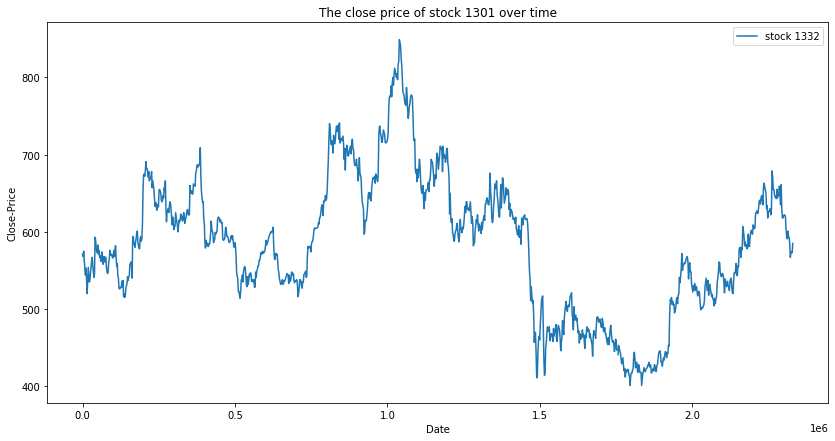

In [14]:
# 绘制单只股票的'High'价格的时间序列图
plt.figure(figsize=(14, 7))
plt.plot(single_stock['Close'],label='stock 1332')
plt.xlabel('Date')
plt.ylabel('Close-Price')
plt.title('The close price of stock 1301 over time')
plt.legend()
plt.show()

In [15]:
#按时间顺序对训练集测试集进行分割
train_size = int(len(single_stock) * 0.67)
test_size = len(single_stock) - train_size
train, test = single_stock[:train_size], single_stock[train_size:]

In [16]:
train.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
1866,20170105_1332,2017-01-05,1332,572.0,573.0,565.0,568.0,2162900,1.0,NaN,False,-0.022609
3731,20170106_1332,2017-01-06,1332,567.0,576.0,563.0,575.0,2125600,1.0,NaN,False,-0.016014
5596,20170110_1332,2017-01-10,1332,573.0,576.0,561.0,562.0,2744600,1.0,NaN,False,-0.016275
7461,20170111_1332,2017-01-11,1332,559.0,562.0,551.0,553.0,2231800,1.0,NaN,False,0.016544


In [17]:
train.shape

(805, 12)

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/01.png)

通过滑窗，我们得到的数据为——

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/16.png)

在时间序列中，一张二维表构成的训练特征 + 一个标签被称之为是“一个样本”，这个概念与我们在机器学习、甚至深度学习中习惯的“每行一个样本”的改变有所区别，因此在这里特别予以澄清。

在单变量数据集上，我们在唯一的列（也就是标签上）滑窗来构建数据集，但在多变量数据集上，我们有多种不同的滑窗方式——

- **特征滑窗**

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/02.png)
![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/03.png)
![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/04.png)

这样最终构建的数据集结构为(batch_size, 5, 5)，其中第一个5是window_size，也就代表一张表单中的time_step时间步步数，第二个5代表5个特征，两个数字都是5纯属巧合。在这种情况下，我们所得到的数据集为：

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/17.png)

这种滑窗方式常见于**标签本身与时间的关系并不大**的情况。与气温、股价这种上个时间点明显会影响下一个时间点的标签不同，某些依据时间进行预测的标签之间并不存在特别强烈的关联。比如，一个用户在1月1日与1月2日的消费金额，我们很难说用户在1月1日有巨额消费，用户在1月2日就更倾向于有消费。有的用户可能因为第一天花光了所有的预算，因此第二天就不再消费，有的用户可能习惯性巨额消费，因此第二天还是巨额消费；有的用户可能没有两天都在购物，因此第二天没有出现消费。这种情况下，1月2日是否有消费其实并不与1月1日是否有消费强关联。

还有一些典型的例子，例如，一个网站的日访问量可能受多种因素影响，如营销活动、假日、特殊事件等，而不仅仅是前一天的访问量：

> 1月1日：网站因为发布了一篇热门文章而获得高访问量。

> 1月2日：尽管前一天访问量高，但没有新内容或特别活动，访问量可能大幅下降。

> 1月3日：网站可能因为一个相关话题突然在社交媒体上走红而意外获得巨大访问量，与前两天的访问量无明显直接关联。

在这种情况下，简单地依据前一天的访问量来预测下一天的访问量可能不太准确，需要考虑更多外部因素。

我们可以使用下面的函数来实现这样的滑窗——

In [18]:
train.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
1866,20170105_1332,2017-01-05,1332,572.0,573.0,565.0,568.0,2162900,1.0,NaN,False,-0.022609
3731,20170106_1332,2017-01-06,1332,567.0,576.0,563.0,575.0,2125600,1.0,NaN,False,-0.016014
5596,20170110_1332,2017-01-10,1332,573.0,576.0,561.0,562.0,2744600,1.0,NaN,False,-0.016275
7461,20170111_1332,2017-01-11,1332,559.0,562.0,551.0,553.0,2231800,1.0,NaN,False,0.016544


In [19]:
train.shape

(805, 12)

In [20]:
train = train.fillna(0)

In [21]:
import torch
import numpy as np

def create_multivariate_dataset(dataset, window_size):
    """
    将多变量时间序列转变为能够用于LSTM训练和预测的数据【特征法】
    
    参数:
        dataset: DataFrame，其中包含特征和标签，特征从索引3开始，最后一列是标签
        window_size: 滑窗的窗口大小
    """
    X, y = [], []
    for i in range(len(dataset) - window_size):
        # 使用.values将Pandas DataFrame的切片转换为NumPy数组
        feature = dataset.iloc[i:i + window_size, 3:-1].values  # 转换为NumPy数组
        target = dataset.iloc[i + window_size - 1, -1]  # 目标值保持为标量即可
        X.append(feature)
        y.append(target)
    # 直接使用np.array转换列表为NumPy数组，并指定dtype确保数组类型正确
    return torch.FloatTensor(np.array(X, dtype=np.float32)), torch.FloatTensor(np.array(y, dtype=np.float32))

In [22]:
X_train, y_train = create_multivariate_dataset(train, 2)

In [23]:
X_train[:5]

tensor([[[5.6800e+02, 5.7600e+02, 5.6300e+02, 5.7100e+02, 2.7985e+06,
          1.0000e+00, 0.0000e+00, 0.0000e+00],
         [5.7200e+02, 5.7300e+02, 5.6500e+02, 5.6800e+02, 2.1629e+06,
          1.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[5.7200e+02, 5.7300e+02, 5.6500e+02, 5.6800e+02, 2.1629e+06,
          1.0000e+00, 0.0000e+00, 0.0000e+00],
         [5.6700e+02, 5.7600e+02, 5.6300e+02, 5.7500e+02, 2.1256e+06,
          1.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[5.6700e+02, 5.7600e+02, 5.6300e+02, 5.7500e+02, 2.1256e+06,
          1.0000e+00, 0.0000e+00, 0.0000e+00],
         [5.7300e+02, 5.7600e+02, 5.6100e+02, 5.6200e+02, 2.7446e+06,
          1.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[5.7300e+02, 5.7600e+02, 5.6100e+02, 5.6200e+02, 2.7446e+06,
          1.0000e+00, 0.0000e+00, 0.0000e+00],
         [5.5900e+02, 5.6200e+02, 5.5100e+02, 5.5300e+02, 2.2318e+06,
          1.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[5.5900e+02, 5.6200e+02, 5.5100e+02, 5.5300e+02

In [24]:
X_train.shape

torch.Size([803, 2, 8])

In [25]:
y_train[:10]

tensor([-0.0226, -0.0160, -0.0163,  0.0165, -0.0271, -0.0335,  0.0327,  0.0317,
        -0.0162, -0.0183])

- **带标签的滑窗**

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/05.png)
![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/06.png)

这种滑窗方式适应于除了特征之外，标签之间也随着时间互相影响的数据集。我们可以使用下面的函数来实现这样的滑窗——

In [26]:
import torch
import numpy as np

def create_multivariate_dataset_2(dataset, window_size):
    """
    将多变量时间序列转变为能够用于训练和预测的数据【带标签的滑窗】
    
    参数:
        dataset: DataFrame，其中包含特征和标签，特征从索引3开始，最后一列是标签
        window_size: 滑窗的窗口大小
    """
    X, y = [], []
    for i in range(len(dataset) - window_size):
        # 选取从第4列到最后一列的特征和标签
        feature_and_label = dataset.iloc[i:i + window_size, 3:].values  # 包括标签在内的特征
        # 下一个时间点的标签作为目标
        target = dataset.iloc[i + window_size, -1]  # 使用下一个时间点的标签作为预测目标
        X.append(feature_and_label)
        y.append(target)
    return torch.FloatTensor(np.array(X, dtype=np.float32)), torch.FloatTensor(np.array(y, dtype=np.float32))

In [27]:
train.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,0.0,False,0.012324
1866,20170105_1332,2017-01-05,1332,572.0,573.0,565.0,568.0,2162900,1.0,0.0,False,-0.022609
3731,20170106_1332,2017-01-06,1332,567.0,576.0,563.0,575.0,2125600,1.0,0.0,False,-0.016014
5596,20170110_1332,2017-01-10,1332,573.0,576.0,561.0,562.0,2744600,1.0,0.0,False,-0.016275
7461,20170111_1332,2017-01-11,1332,559.0,562.0,551.0,553.0,2231800,1.0,0.0,False,0.016544


In [28]:
X_train_2, y_train_2 = create_multivariate_dataset_2(train, 2)

In [29]:
X_train_2.shape

torch.Size([803, 2, 9])

In [30]:
X_train.shape

torch.Size([803, 2, 8])

In [31]:
X_train_2[:5]

tensor([[[ 5.6800e+02,  5.7600e+02,  5.6300e+02,  5.7100e+02,  2.7985e+06,
           1.0000e+00,  0.0000e+00,  0.0000e+00,  1.2324e-02],
         [ 5.7200e+02,  5.7300e+02,  5.6500e+02,  5.6800e+02,  2.1629e+06,
           1.0000e+00,  0.0000e+00,  0.0000e+00, -2.2609e-02]],

        [[ 5.7200e+02,  5.7300e+02,  5.6500e+02,  5.6800e+02,  2.1629e+06,
           1.0000e+00,  0.0000e+00,  0.0000e+00, -2.2609e-02],
         [ 5.6700e+02,  5.7600e+02,  5.6300e+02,  5.7500e+02,  2.1256e+06,
           1.0000e+00,  0.0000e+00,  0.0000e+00, -1.6014e-02]],

        [[ 5.6700e+02,  5.7600e+02,  5.6300e+02,  5.7500e+02,  2.1256e+06,
           1.0000e+00,  0.0000e+00,  0.0000e+00, -1.6014e-02],
         [ 5.7300e+02,  5.7600e+02,  5.6100e+02,  5.6200e+02,  2.7446e+06,
           1.0000e+00,  0.0000e+00,  0.0000e+00, -1.6275e-02]],

        [[ 5.7300e+02,  5.7600e+02,  5.6100e+02,  5.6200e+02,  2.7446e+06,
           1.0000e+00,  0.0000e+00,  0.0000e+00, -1.6275e-02],
         [ 5.5900e+02,  5.62

In [32]:
y_train_2[:100]

tensor([-0.0160, -0.0163,  0.0165, -0.0271, -0.0335,  0.0327,  0.0317, -0.0162,
        -0.0183,  0.0075,  0.0148,  0.0128,  0.0162,  0.0071, -0.0194, -0.0144,
        -0.0128,  0.0092,  0.0861, -0.0067, -0.0170, -0.0086, -0.0017,  0.0175,
        -0.0206,  0.0088, -0.0156,  0.0035, -0.0123,  0.0000,  0.0214, -0.0087,
        -0.0193,  0.0072,  0.0107, -0.0123,  0.0107,  0.0000, -0.0229, -0.0108,
        -0.0036,  0.0037,  0.0237,  0.0071,  0.0195, -0.0104,  0.0018,  0.0000,
        -0.0053, -0.0035,  0.0071,  0.0105, -0.0139,  0.0158,  0.0087, -0.0275,
        -0.0194,  0.0072, -0.0286, -0.0055, -0.0241, -0.0019,  0.0019,  0.0019,
         0.0000,  0.0152, -0.0131,  0.0151, -0.0391,  0.0078, -0.0096,  0.0039,
         0.0193,  0.0057,  0.0057,  0.0169, -0.0092,  0.0093,  0.0018,  0.0276,
         0.0018,  0.0036, -0.0107, -0.0270,  0.1000, -0.0017, -0.0152,  0.0017,
        -0.0085,  0.0121,  0.0085,  0.0101,  0.0050, -0.0233, -0.0085, -0.0052,
        -0.0017,  0.0225,  0.0051, -0.01

相比只拥有特征的滑窗方式，携带标签的滑窗方式在很多场景下会给与算法更好的表现，这是因为——
> - **增加信息量**：通过将之前时间点的标签纳入到当前窗口的输入中，模型可以利用更多的上下文信息进行预测。这种方式可以提供更丰富的序列信息，可能有助于模型捕捉到更复杂的时间序列依赖关系。

> - **改善序列预测**：在某些情况下，特别是当连续的标签之间存在一定的序列相关性时，使用之前的标签作为额外的特征可以提高预测的准确性。

> - **增强模型的泛化能力**：通过学习如何将过去的标签和当前的特征结合起来进行预测，模型可能更好地理解序列数据的内在规律，从而在遇到新的、未见过的序列时表现得更好。

但是这种滑窗方式也会带来相应的问题——

> - **过拟合的风险**：更复杂的模型和更多的输入特征可能会增加过拟合的风险，尤其是在数据较少的情况下。需要适当的正则化策略和模型评估方法来避免这一问题。

> - **可能的数据泄露**：如果在预测时无法获取之前时间点的真实标签（例如，在实时预测或未来预测中），这种方法可能不适用。此外，如果不小心处理，使用未来数据（即“未来泄露”）可能会导致预测结果过于乐观。

> - **实施复杂性**：需要在数据预处理阶段更加小心地处理数据，确保每个窗口中包含正确的特征和标签，且在实际预测时能够符合模型的输入要求。

总的来说，这种滑窗方式可以为模型提供更多的上下文信息，可能有助于改善预测性能，但同时也带来了更高的模型复杂度和过拟合的风险。在实际应用中，是否采用这种方法应根据具体任务的需求、数据的可用性以及模型的性能进行权衡和决策。

- **特征标签共用的滑窗**

还有第三种信息更为全面的滑窗方式——

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/07.png)
![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/08.png)

In [33]:
import torch
import numpy as np

def create_multivariate_dataset_3(dataset, window_size):
    """
    将多变量时间序列转变为能够用于训练和预测的数据
    
    参数:
        dataset: DataFrame，其中包含特征和标签，特征从索引3开始，最后一列是标签
        window_size: 滑窗的窗口大小
    """
    X, y = [], []
    for i in range(len(dataset) - window_size):
        # 选取从第4列到最后一列的特征和标签
        feature_and_label = dataset.iloc[i:i + window_size, 3:].copy().values  # 包括标签在内的特征
        # 下一个时间点的标签作为目标
        target = dataset.iloc[i + window_size - 1, -1]  # 使用窗口内最后一个时间点的标签作为预测目标
        # 将窗口内最后一个时间点的标签替换为-999
        feature_and_label[-1, -1] = -999
        X.append(feature_and_label)
        y.append(target)
    return torch.FloatTensor(np.array(X, dtype=np.float32)), torch.FloatTensor(np.array(y, dtype=np.float32))

In [34]:
train.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,0.0,False,0.012324
1866,20170105_1332,2017-01-05,1332,572.0,573.0,565.0,568.0,2162900,1.0,0.0,False,-0.022609
3731,20170106_1332,2017-01-06,1332,567.0,576.0,563.0,575.0,2125600,1.0,0.0,False,-0.016014
5596,20170110_1332,2017-01-10,1332,573.0,576.0,561.0,562.0,2744600,1.0,0.0,False,-0.016275
7461,20170111_1332,2017-01-11,1332,559.0,562.0,551.0,553.0,2231800,1.0,0.0,False,0.016544


In [35]:
X_train_3, y_train_3 = create_multivariate_dataset_3(train, 3)

In [36]:
X_train_3.shape

torch.Size([802, 3, 9])

In [37]:
X_train.shape

torch.Size([803, 2, 8])

In [56]:
X_train_3[0] #最后右下角的格子是-999

tensor([[ 5.6800e+02,  5.7600e+02,  5.6300e+02,  5.7100e+02,  2.7985e+06,
          1.0000e+00,  0.0000e+00,  0.0000e+00,  1.2324e-02],
        [ 5.7200e+02,  5.7300e+02,  5.6500e+02,  5.6800e+02,  2.1629e+06,
          1.0000e+00,  0.0000e+00,  0.0000e+00, -2.2609e-02],
        [ 5.6700e+02,  5.7600e+02,  5.6300e+02,  5.7500e+02,  2.1256e+06,
          1.0000e+00,  0.0000e+00,  0.0000e+00, -9.9900e+02]])

In [39]:
y_train_3[:100]

tensor([-0.0160, -0.0163,  0.0165, -0.0271, -0.0335,  0.0327,  0.0317, -0.0162,
        -0.0183,  0.0075,  0.0148,  0.0128,  0.0162,  0.0071, -0.0194, -0.0144,
        -0.0128,  0.0092,  0.0861, -0.0067, -0.0170, -0.0086, -0.0017,  0.0175,
        -0.0206,  0.0088, -0.0156,  0.0035, -0.0123,  0.0000,  0.0214, -0.0087,
        -0.0193,  0.0072,  0.0107, -0.0123,  0.0107,  0.0000, -0.0229, -0.0108,
        -0.0036,  0.0037,  0.0237,  0.0071,  0.0195, -0.0104,  0.0018,  0.0000,
        -0.0053, -0.0035,  0.0071,  0.0105, -0.0139,  0.0158,  0.0087, -0.0275,
        -0.0194,  0.0072, -0.0286, -0.0055, -0.0241, -0.0019,  0.0019,  0.0019,
         0.0000,  0.0152, -0.0131,  0.0151, -0.0391,  0.0078, -0.0096,  0.0039,
         0.0193,  0.0057,  0.0057,  0.0169, -0.0092,  0.0093,  0.0018,  0.0276,
         0.0018,  0.0036, -0.0107, -0.0270,  0.1000, -0.0017, -0.0152,  0.0017,
        -0.0085,  0.0121,  0.0085,  0.0101,  0.0050, -0.0233, -0.0085, -0.0052,
        -0.0017,  0.0225,  0.0051, -0.01

这种滑窗方式尽可能携带了最多的信息，但并不是最为常见或常用的滑窗方式，这是因为——

- **特殊值的选择**：需要谨慎选择特殊值以避免与数据集中的实际值冲突。如果选取的特殊值与数据集中可能出现的值相近，可能会引入误导信息。

- **模型处理能力**：模型需要能够正确处理特殊值，不让这个值影响到模型的预测能力。这可能需要对模型进行特定的设计或预处理步骤，确保模型不会被特殊值误导。

#### 1.5.2.3 面板数据的重组流程

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/09.png)

In [40]:
df_stock_prices.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [41]:
multi_stock = pd.concat([df_stock_prices[df_stock_prices['SecuritiesCode'] == 1332]
                         ,df_stock_prices[df_stock_prices['SecuritiesCode'] == 1301]
                         ,df_stock_prices[df_stock_prices['SecuritiesCode'] == 1376]
                        ])

In [42]:
multi_stock.shape

(3606, 12)

In [43]:
multi_stock.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
1866,20170105_1332,2017-01-05,1332,572.0,573.0,565.0,568.0,2162900,1.0,NaN,False,-0.022609
3731,20170106_1332,2017-01-06,1332,567.0,576.0,563.0,575.0,2125600,1.0,NaN,False,-0.016014
5596,20170110_1332,2017-01-10,1332,573.0,576.0,561.0,562.0,2744600,1.0,NaN,False,-0.016275
7461,20170111_1332,2017-01-11,1332,559.0,562.0,551.0,553.0,2231800,1.0,NaN,False,0.016544


面板数据与多变量时间序列数据相比，有了更多需要考虑的因素。例如在LSTM与RNN的流程中，我们是沿着time_step，也是seq_length的方向进行扫描的。因此在这系列模型的假设中，我们认为LSTM和RNN建立的是每个保单内部的、行与行之间的联系，也就是时间步与时间步之间的联系。这隐含着一种暗示——即RNN和LSTM这类算法并不在意表单与表单之间的联系。**对于一个时间序列来说，相互影响的时序数据应该尽量在同一张表单上**。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/Live/NLP%26LLMs/16.png)

- **忽略截面的滑窗**

这是最常见的、面板数据所使用的滑窗方式，我们使用这种滑窗方式的根本原因在于，它确实非常便捷！


![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/10.png)
![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/11.png)

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/12.png)

我们可以使用下面的函数实现这种滑窗方式，这与多变量数据中、包含标签的滑窗方式一模一样——

In [44]:
import torch
import numpy as np

def create_multivariate_dataset_2(dataset, window_size):
    """
    将多变量时间序列转变为能够用于训练和预测的数据
    
    参数:
        dataset: DataFrame，其中包含特征和标签，特征从索引3开始，最后一列是标签
        window_size: 滑窗的窗口大小
    """
    X, y = [], []
    for i in range(len(dataset) - window_size):
        # 选取从第4列到最后一列的特征和标签
        feature_and_label = dataset.iloc[i:i + window_size, 3:].values  # 包括标签在内的特征
        # 下一个时间点的标签作为目标
        target = dataset.iloc[i + window_size, -1]  # 使用下一个时间点的标签作为预测目标
        X.append(feature_and_label)
        y.append(target)
    return torch.FloatTensor(np.array(X, dtype=np.float32)), torch.FloatTensor(np.array(y, dtype=np.float32))

但是除此之外，我们还可以特地关注到截面的不同而避免跨截面的滑窗——

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/13.png)
![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/14.png)
![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/15.png)

这样的滑窗有多套不同的实现逻辑，我现在的实现逻辑如下。按多变量数据集的规律进行滑窗，但我要求每个窗内只能有唯一的Securities Code，如果一个数据集中出现了不同的Securities Code，则该窗会被删除。这种情况下，我们可以使用下面的函数来进行滑窗——

In [45]:
#按时间顺序对训练集测试集进行分割
train_size = int(len(multi_stock) * 0.67)
test_size = len(multi_stock) - train_size
train, test = multi_stock[:train_size], multi_stock[train_size:]

In [46]:
import torch
import numpy as np

def create_multivariate_dataset_4(dataset, window_size):
    """
    将多变量时间序列转变为能够用于训练和预测的数据，确保每个窗口内的Securities Code唯一
    
    参数:
        dataset: DataFrame，其中包含特征和标签，特征从索引3开始，最后一列是标签
        window_size: 滑窗的窗口大小
    """
    X, y = [], []
    for i in range(len(dataset) - window_size):
        # 检查窗口内的Securities Code是否唯一
        securities_code = dataset.iloc[i:i + window_size, 2]
        if len(securities_code.unique()) == 1:  # 如果Securities Code在窗口内唯一
            # 选取从第4列到最后一列的特征和标签
            feature_and_label = dataset.iloc[i:i + window_size, 3:].copy().values
            # 下一个时间点的标签作为目标
            target = dataset.iloc[i + window_size, -1]
            X.append(feature_and_label)
            y.append(target)
    return torch.FloatTensor(np.array(X, dtype=np.float32)), torch.FloatTensor(np.array(y, dtype=np.float32))

在这个版本的函数中，我们在添加窗口到X和y列表之前，首先检查窗口内所有行的Securities Code是否相同。这是通过选择窗口内的Securities Code列dataset.iloc[i:i + window_size, 2]，然后使用.unique()方法来检查其唯一值的数量。只有当len(securities_code.unique()) == 1时，即窗口内的Securities Code唯一时，我们才将该窗口的特征和标签添加到最终的数据集中。

In [49]:
train.shape

(2416, 12)

In [50]:
X_train_4, y_train_4= create_multivariate_dataset_4(train, 10)

In [52]:
X_train_4.shape #原则上来说应该有2416 - 10个窗，但是其中有多个窗涉及到跨越了截面（涉及到不同的股票，因此被删除了）

torch.Size([2388, 10, 9])

In [53]:
X_train.shape

torch.Size([803, 2, 8])

In [54]:
X_train_4[0]

tensor([[ 5.6800e+02,  5.7600e+02,  5.6300e+02,  5.7100e+02,  2.7985e+06,
          1.0000e+00,         nan,  0.0000e+00,  1.2324e-02],
        [ 5.7200e+02,  5.7300e+02,  5.6500e+02,  5.6800e+02,  2.1629e+06,
          1.0000e+00,         nan,  0.0000e+00, -2.2609e-02],
        [ 5.6700e+02,  5.7600e+02,  5.6300e+02,  5.7500e+02,  2.1256e+06,
          1.0000e+00,         nan,  0.0000e+00, -1.6014e-02],
        [ 5.7300e+02,  5.7600e+02,  5.6100e+02,  5.6200e+02,  2.7446e+06,
          1.0000e+00,         nan,  0.0000e+00, -1.6275e-02],
        [ 5.5900e+02,  5.6200e+02,  5.5100e+02,  5.5300e+02,  2.2318e+06,
          1.0000e+00,         nan,  0.0000e+00,  1.6544e-02],
        [ 5.5300e+02,  5.5600e+02,  5.4300e+02,  5.4400e+02,  2.5797e+06,
          1.0000e+00,         nan,  0.0000e+00, -2.7125e-02],
        [ 5.4300e+02,  5.5400e+02,  5.4100e+02,  5.5300e+02,  2.4857e+06,
          1.0000e+00,         nan,  0.0000e+00, -3.3457e-02],
        [ 5.4700e+02,  5.4900e+02,  5.3500e+02, 

In [55]:
y_train_4[:100]

tensor([-0.0183,  0.0075,  0.0148,  0.0128,  0.0162,  0.0071, -0.0194, -0.0144,
        -0.0128,  0.0092,  0.0861, -0.0067, -0.0170, -0.0086, -0.0017,  0.0175,
        -0.0206,  0.0088, -0.0156,  0.0035, -0.0123,  0.0000,  0.0214, -0.0087,
        -0.0193,  0.0072,  0.0107, -0.0123,  0.0107,  0.0000, -0.0229, -0.0108,
        -0.0036,  0.0037,  0.0237,  0.0071,  0.0195, -0.0104,  0.0018,  0.0000,
        -0.0053, -0.0035,  0.0071,  0.0105, -0.0139,  0.0158,  0.0087, -0.0275,
        -0.0194,  0.0072, -0.0286, -0.0055, -0.0241, -0.0019,  0.0019,  0.0019,
         0.0000,  0.0152, -0.0131,  0.0151, -0.0391,  0.0078, -0.0096,  0.0039,
         0.0193,  0.0057,  0.0057,  0.0169, -0.0092,  0.0093,  0.0018,  0.0276,
         0.0018,  0.0036, -0.0107, -0.0270,  0.1000, -0.0017, -0.0152,  0.0017,
        -0.0085,  0.0121,  0.0085,  0.0101,  0.0050, -0.0233, -0.0085, -0.0052,
        -0.0017,  0.0225,  0.0051, -0.0101,  0.0051,  0.0321,  0.0721,  0.0306,
         0.0015, -0.0044,  0.0089,  0.01

### 1.5.3 单步预测、多步预测与递归预测法

在之前的课程中我们了解了3类不同的时间序列数据、以及这些数据所涉及到的7-8类数据重组方式，相信你已经意识到、时间序列任务会比一般的机器学习/深度学习更复杂、更灵活、更有挑战性。尽管3种不同的时序数据已经让我们应接不暇，但事实上时序预测过程中难度更高的是预测方法本身。在过去的课程中，我们都是以最为经典的“点到序列”的预测方式给大家举例，但事实上，依据时间序列预测的不同细节，时序预测手段可以被分为以下四种——

> - **单步预测**：在每次预测时只预测序列的下一个时间点的值，也就是常见的“序列到点”（seq-2-point）的预测。

> - **多步预测**：在每次预测时预测序列接下来多个时间点的值，也就是之前提过的“序列到序列”（seq-2-seq）的预测。

> - **递归预测**：模型预测出下一个时间点或多个时间点的值后，将这些预测值作为输入的一部分来预测下一个时间点或多个时间点的值，如此递归下去。

> - **直接预测**：在预测过程中，模型只使用已存在的历史数据和历史标签作为输入，并不会将上一时刻预测出的结果作为下一时刻输入的一部分。

在这4种分类下，我们实际可以有单步递归预测、单步直接预测、多步递归预测和多步直接预测四种预测方法，之前我们所呈现的最经典的“序列到点”的预测就是单步直接预测法。本节就让我们一起来认识一下这4种预测方法。

- **从单步直接预测到多步直接预测**

从单步直接预测过渡到多步直接预测，是一个“牵一发而动全身”的策略，会涉及到一系列的改变和挑战，这些改变不仅会影响数据的预处理过程，例如**滑窗方式的调整**，还会影响到**模型的架构和训练过程**，如LSTM的输出方式和损失函数的计算。在多步预测中，滑窗方式可能需要根据预测范围进行优化，以确保每个窗口能够有效地捕获到对未来多个时间点预测所需的信息。同时，LSTM模型的输出层需要调整，以便能够一次性输出多个时间点的预测值，这可能要求模型学习和捕获更复杂的时间序列依赖关系。

此外，**损失函数的计算也变得更加复杂**，因为现在需要考虑模型对多个未来时间点预测的整体准确性。这可能会影响到模型的训练策略，包括早停机制的应用，因为早停判断现在需要基于多步预测的性能来进行。最后，从多步直接预测中提取最终预测值时，还需要考虑如何综合和处理模型输出的多个预测结果，以便得到对未来序列的最佳估计。这些问题共同构成了从单步直接预测到多步直接预测转变的复杂性，需要细致的方法和策略来有效地解决。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/18.png)
![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/Case/19.png)

> **多步预测完整代码**

In [77]:
#数据导入
df_stock_prices = pd.read_csv('stock_prices.csv')

In [50]:
df_stock_prices.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [51]:
df_stock_prices.shape

(2332531, 12)

In [52]:
df_stock_prices["SecuritiesCode"].unique().__len__() #一共包含2000支股票

2000

In [53]:
#提取其中一支股票的数据作为例子
# 选择单只股票的数据
single_stock = df_stock_prices[df_stock_prices['SecuritiesCode'] == 1332]

In [54]:
single_stock.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1202 entries, 1 to 2330532
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RowId             1202 non-null   object 
 1   Date              1202 non-null   object 
 2   SecuritiesCode    1202 non-null   int64  
 3   Open              1201 non-null   float64
 4   High              1201 non-null   float64
 5   Low               1201 non-null   float64
 6   Close             1201 non-null   float64
 7   Volume            1202 non-null   int64  
 8   AdjustmentFactor  1202 non-null   float64
 9   ExpectedDividend  10 non-null     float64
 10  SupervisionFlag   1202 non-null   bool   
 11  Target            1202 non-null   float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 113.9+ KB


> **完成简单预处理**

In [55]:
#我们修改预测目标，我们预测股价，而不预测原始竞赛中的Target（夏普比率）
single_stock = single_stock.copy()
#将Target名字修改为Sharpe Ratio
single_stock.rename(columns={'Target': 'Sharpe Ratio'}, inplace=True)
#将Close列取出
close_col = single_stock.pop('Close')
#将Close列添加到最后
single_stock.loc[:,'Close'] = close_col
#填补缺失值
single_stock.loc[:,"ExpectedDividend"] = single_stock.loc[:,"ExpectedDividend"].fillna(0)
single_stock.dropna(inplace=True)
#恢复索引
single_stock.index = range(single_stock.shape[0])

In [57]:
single_stock.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Sharpe Ratio,Close
0,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,2798500,1.0,0.0,False,0.012324,571.0
1,20170105_1332,2017-01-05,1332,572.0,573.0,565.0,2162900,1.0,0.0,False,-0.022609,568.0
2,20170106_1332,2017-01-06,1332,567.0,576.0,563.0,2125600,1.0,0.0,False,-0.016014,575.0
3,20170110_1332,2017-01-10,1332,573.0,576.0,561.0,2744600,1.0,0.0,False,-0.016275,562.0
4,20170111_1332,2017-01-11,1332,559.0,562.0,551.0,2231800,1.0,0.0,False,0.016544,553.0


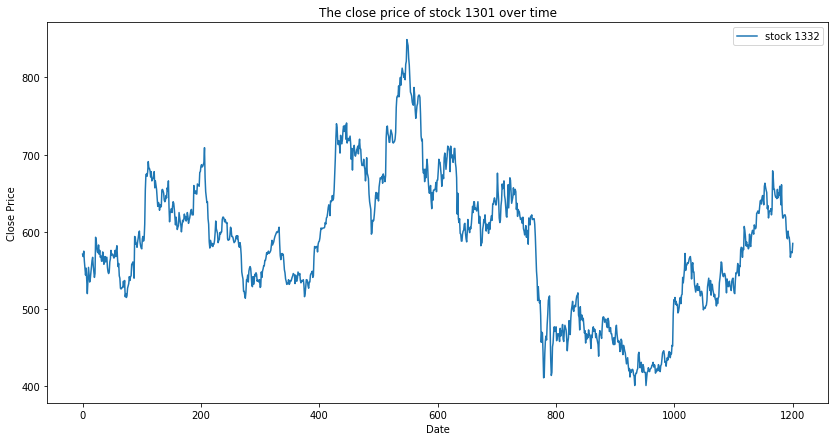

In [58]:
# 绘制单只股票的'High'价格的时间序列图
plt.figure(figsize=(14, 7))
plt.plot(single_stock['Close'],label='stock 1332')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('The close price of stock 1301 over time')
plt.legend()
plt.show()

> **数据分割与带标签的滑窗**

In [59]:
#按时间顺序对训练集测试集进行分割
train_size = int(len(single_stock) * 0.67)
test_size = len(single_stock) - train_size
train, test = single_stock[:train_size], single_stock[train_size:]

In [60]:
import torch
import numpy as np

def create_multivariate_dataset_2(dataset, window_size, pred_len):
    """
    将多变量时间序列转变为能够用于训练和预测的数据【带标签的滑窗】
    
    参数:
        dataset: DataFrame，其中包含特征和标签，特征从索引3开始，最后一列是标签
        window_size: 滑窗的窗口大小
        pred_len：多步预测的预测范围/预测步长
    """
    X, y, y_indices = [], [], []
    for i in range(len(dataset) - window_size - pred_len + 1):
        # 选取从第4列到最后一列的特征和标签
        feature_and_label = dataset.iloc[i:i + window_size, 3:].values
        # 下一个时间点的标签作为目标
        target = dataset.iloc[(i + window_size):(i + window_size + pred_len), -1]
        # 记录本窗口中要预测的标签的时间点
        target_indices = list(range(i + window_size, i + window_size + pred_len))

        X.append(feature_and_label)
        y.append(target)
        #将每个标签的索引添加到y_indices列表中
        y_indices.extend(target_indices)
    
    X = torch.FloatTensor(np.array(X, dtype=np.float32))
    y = torch.FloatTensor(np.array(y, dtype=np.float32))
    
    return X, y, y_indices

In [74]:
window_size = 32
pred_len = 5 #进行5步的多步预测

X_train_2, y_train_2, y_train_indices = create_multivariate_dataset_2(train, window_size, pred_len)
X_test_2, y_test_2, y_test_indices = create_multivariate_dataset_2(test, window_size, pred_len)

In [62]:
X_train_2.shape

torch.Size([768, 32, 9])

In [63]:
X_train_2[0] #取出的是索引为0-31的样本

tensor([[ 5.6800e+02,  5.7600e+02,  5.6300e+02,  2.7985e+06,  1.0000e+00,
          0.0000e+00,  0.0000e+00,  1.2324e-02,  5.7100e+02],
        [ 5.7200e+02,  5.7300e+02,  5.6500e+02,  2.1629e+06,  1.0000e+00,
          0.0000e+00,  0.0000e+00, -2.2609e-02,  5.6800e+02],
        [ 5.6700e+02,  5.7600e+02,  5.6300e+02,  2.1256e+06,  1.0000e+00,
          0.0000e+00,  0.0000e+00, -1.6014e-02,  5.7500e+02],
        [ 5.7300e+02,  5.7600e+02,  5.6100e+02,  2.7446e+06,  1.0000e+00,
          0.0000e+00,  0.0000e+00, -1.6275e-02,  5.6200e+02],
        [ 5.5900e+02,  5.6200e+02,  5.5100e+02,  2.2318e+06,  1.0000e+00,
          0.0000e+00,  0.0000e+00,  1.6544e-02,  5.5300e+02],
        [ 5.5300e+02,  5.5600e+02,  5.4300e+02,  2.5797e+06,  1.0000e+00,
          0.0000e+00,  0.0000e+00, -2.7125e-02,  5.4400e+02],
        [ 5.4300e+02,  5.5400e+02,  5.4100e+02,  2.4857e+06,  1.0000e+00,
          0.0000e+00,  0.0000e+00, -3.3457e-02,  5.5300e+02],
        [ 5.4700e+02,  5.4900e+02,  5.3500e+02, 

In [75]:
y_train_2[0] #索引为32、33、34、35、36五个标签

tensor([562., 562., 574., 569., 558.])

In [65]:
y_train_indices[:10] #由于设置的pred_len是5，所以5个标签为一轮

[32, 33, 34, 35, 36, 33, 34, 35, 36, 37]

> **架构建立与参数设置**

In [66]:
#选择了最为简单的网络架构来进行实验
import torch.nn as nn
 
class MyLSTM(nn.Module):
    def __init__(self,input_dim, pred_len):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, pred_len)
    def forward(self, x):
        x, _ = self.lstm(x)
        #现在我要的是最后一个时间步，而不是全部时间步了
        x = self.linear(x[:,-1,:])
        return x

In [67]:
model = MyLSTM(input_dim = 9, pred_len = pred_len)

In [68]:
model(X_train_2).shape #针对全部的768窗口，都输出5个预测值

torch.Size([768, 5])

In [69]:
#设置GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [70]:
#设置参数
input_size = 1  #输入特征的维度
hidden_size = 50 #LSTM隐藏状态的维度
num_layers = 1 #LSTM层的数量
output_size = 1 #模型的输出维度
n_epochs = 2000 #迭代epoch
learning_rate = 0.001 #学习率

In [71]:
#实例化模型
model = MyLSTM(input_dim=9,pred_len = pred_len).to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate) #定义优化器
loss_fn = nn.MSELoss() #定义损失函数
loader = data.DataLoader(data.TensorDataset(X_train_2, y_train_2)
                         #每个表单内部是保持时间顺序的即可，表单与表单之间可以shuffle
                         , shuffle=True
                         , batch_size=8) #将数据分批次

In [72]:
for x,y in loader:
    print(x.shape)
    print(y)
    break

torch.Size([8, 32, 9])
tensor([[599., 600., 602., 606., 585.],
        [670., 669., 669., 672., 663.],
        [555., 540., 594., 593., 584.],
        [620., 629., 627., 626., 620.],
        [682., 679., 671., 678., 666.],
        [536., 538., 541., 543., 546.],
        [641., 639., 641., 647., 644.],
        [590., 599., 597., 600., 600.]])


> **实际训练流程**

In [73]:
# 初始化早停参数
early_stopping_patience = 3  # 设置容忍的epoch数，即在这么多epoch后如果没有改进就停止
early_stopping_counter = 0  # 用于跟踪没有改进的epoch数
best_train_rmse = float('inf')  # 初始化最佳的训练RMSE

In [42]:
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #验证与打印
    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train_2.to(device)).cpu()
            train_rmse = np.sqrt(loss_fn(y_pred, y_train_2))
            y_pred = model(X_test_2.to(device)).cpu()
            test_rmse = np.sqrt(loss_fn(y_pred, y_test_2))
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    
        # 早停检查
        if train_rmse < best_train_rmse:
            best_train_rmse = train_rmse
            early_stopping_counter = 0  # 重置计数器
        else:
            early_stopping_counter += 1  # 增加计数器
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping triggered after epoch {epoch}. Training RMSE did not decrease for {early_stopping_patience} consecutive epochs.")
                break  # 跳出训练循环

Epoch 0: train RMSE 624.8842, test RMSE 518.7423
Epoch 100: train RMSE 514.5184, test RMSE 408.8167
Epoch 200: train RMSE 405.5827, test RMSE 300.8127
Epoch 300: train RMSE 298.6700, test RMSE 196.3940
Epoch 400: train RMSE 196.2972, test RMSE 104.2254
Epoch 500: train RMSE 108.4778, test RMSE 76.9970
Epoch 600: train RMSE 73.7087, test RMSE 122.7074
Epoch 700: train RMSE 73.3154, test RMSE 128.8437
Epoch 800: train RMSE 73.3153, test RMSE 128.9358
Epoch 900: train RMSE 73.3153, test RMSE 128.9346
Epoch 1000: train RMSE 73.3153, test RMSE 128.9217
Epoch 1100: train RMSE 73.3153, test RMSE 128.9151
Early stopping triggered after epoch 1100. Training RMSE did not decrease for 3 consecutive epochs.


> **输出预测值，绘制预测图像**

In [43]:
import pandas as pd

def get_predictions(model, X, y_indices):
    # 将模型移至CPU
    model.cpu()
    
    # 对输入数据X进行预测，调整形状，脱离计算图，并转换为numpy数组，然后移除单一维度
    y_pred = model(X).view(-1, 1).detach().numpy().squeeze()
    
    # 创建一个DataFrame，包含时间步和对应的预测值
    result = pd.DataFrame(zip(y_indices, y_pred), columns=["time_step", "prediction"])
    
    # 按时间步分组，并计算每个时间步的预测值的平均值，以处理重复预测的情况
    result = result.groupby(by="time_step").mean()
    print(result.shape)
    
    return result

In [45]:
#get_predictions函数代码解析

In [46]:
model.cpu()
y_pred_train = model(X_train_2).view(-1, 1).detach().numpy().squeeze()
y_pred_test = model(X_test_2).view(-1, 1).detach().numpy().squeeze()

In [47]:
y_pred_train

array([622.04004, 621.93176, 621.79816, ..., 621.79816, 621.6527 ,
       621.5235 ], dtype=float32)

In [48]:
y_pred_train.shape

(3840,)

In [49]:
y_train_indices.__len__()

3840

In [50]:
train_result = pd.DataFrame(zip(y_train_indices,y_pred_train),columns = ["time_step","prediction"])

In [51]:
train_result.head()

,time_step,prediction
0,32,622.040039
1,33,621.931763
2,34,621.798157
3,35,621.652710
4,36,621.523499


In [52]:
train["Close"]

0      571.0
1      568.0
2      575.0
3      562.0
4      553.0
       ...  
799    472.0
800    477.0
801    459.0
802    464.0
803    468.0
Name: Close, Length: 804, dtype: float64

In [53]:
train_result.groupby(by="time_step").mean()

,prediction
time_step,
32,622.040039
33,621.985901
34,621.923340
35,621.855652
36,621.789246
...,...
799,621.789246
800,621.726562
801,621.658142


In [55]:
train_result = get_predictions(model,X_train_2,y_train_indices)
test_result = get_predictions(model,X_test_2,y_test_indices)

(772, 1)
(365, 1)


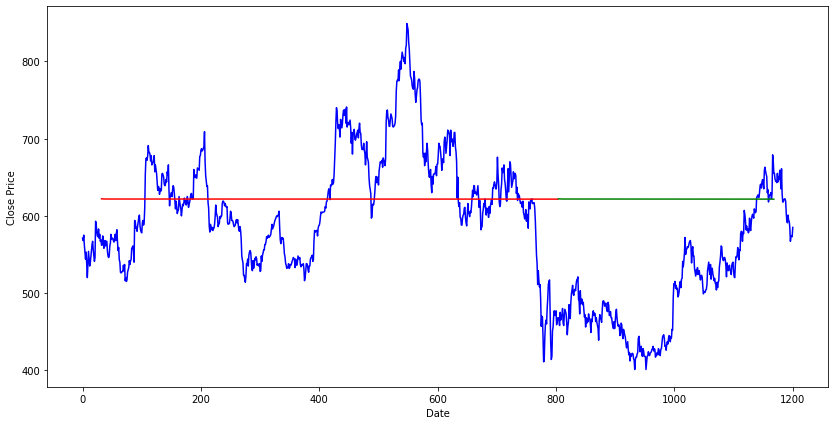

In [57]:
with torch.no_grad():
    plt.figure(figsize=(14, 7))
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    # 绘制训练集上的损失的图像
    train_plot = np.ones_like(single_stock.index) * np.nan
    train_plot[window_size:train_size] = train_result.loc[:,"prediction"]
    # 绘制测试集上的损失的图像
    test_plot = np.ones_like(single_stock.index) * np.nan
    test_plot[train_size:(train_size + test_size - window_size)] = test_result.loc[:,"prediction"]
plt.plot(single_stock.loc[:,"Close"], c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

总结一下，从单步预测到多步预测，我们需要改变的流程与代码是——
> 1. 数据滑窗与数据分割流程、尤其是标签的分割流程

> 2. 模型架构、主要是修改最终线性层输出的标签数量需与多步预测的步数一致

> 3. 由于时间窗口会囊括重复的样本、因此一个样本会被预测多次，因此要设置单独的预测值提取流程

> 4. 注意损失函数的计算流程，如果LSTM的输出层输出的标签数量为1，那损失函数的计算的代码不会报错、但是损失值却会大幅偏移

保证这些流程的完善，才能够保证我们在执行正确的多步预测。

- **从多步预测到递归多步预测**

从多步直接预测转向多步递归预测时，会遇到一系列挑战和考量，这些不仅涉及模型架构的调整，还包括数据处理、预测策略和性能评估等多个方面的变化。在多步递归预测中，模型不再一次性输出所有未来时间点的预测值，而是逐步使用前一步的预测结果作为下一步预测的输入。这种预测方式带来了以下挑战：

**预测依赖性增加**：由于每一步的预测都依赖于前一步的输出，错误可能会在预测过程中逐步累积，导致长期预测的准确性降低。这种依赖性要求模型具有很高的短期预测准确性，以减少误差传播。

**滑窗策略的调整**：在多步递归预测中，滑窗的策略需要灵活调整，以适应逐步生成预测值的需要。每次预测后，新的预测值需要被整合到后续窗口的输入中，这可能要求动态调整窗口的内容。

**损失函数和训练过程的复杂性**：在递归预测中，损失函数的计算可能需要在每一步预测后即时进行，以便及时调整模型参数。这种即时反馈机制增加了训练过程的复杂性，并可能需要特别设计的训练循环。

**早停机制的适应性**：传统的早停机制可能需要针对递归预测进行调整，因为模型性能的评估现在涉及到连续多步的预测结果。确定何时停止训练以避免过拟合，可能需要考虑递归预测的特殊性质和误差累积的影响。

**最终预测值的确定性问题**：在多步递归预测中，由于每一步预测都是基于先前的预测结果，因此如何从一系列递归生成的预测中确定最终的预测值可能会更加复杂。可能需要采取额外的策略，比如使用多种模型的预测结果进行综合，以提高预测的可靠性。

**实时数据的整合问题**：在实际应用中，如果有新的实时数据可用，将这些数据有效地整合到递归预测过程中，以及如何平衡模型对新数据和自身预测结果的依赖，是另一个需要考虑的挑战。

总的来说，从多步直接预测到多步递归预测的转变，虽然为模型提供了更大的灵活性和适应性，但也带来了一系列挑战，需要通过精心的模型设计和训练策略来克服。

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

# 假设 single_stock 是原始的 DataFrame，包含 130 行和 6 列，其中最后一列是标签
single_stock = pd.DataFrame(np.random.rand(130, 6), columns=[f'Feature_{i}' for i in range(1, 6)] + ['Label'])

class MyLSTM(nn.Module):
    def __init__(self, input_dim, pred_len):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, pred_len)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])  # 使用最后一个时间步
        return x

def train_lstm_with_dynamic_window(single_stock, window_size=10, pred_len=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_dim = single_stock.shape[1] - 1  # 减去1是因为最后一列是标签
    model = MyLSTM(input_dim=input_dim, pred_len=pred_len).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # 将 DataFrame 转换为张量
    data_tensor = torch.tensor(single_stock.values, dtype=torch.float32)

    for start_idx in range(0, len(single_stock) - window_size - pred_len + 1):
        # 分割出当前窗口的数据
        current_window = data_tensor[start_idx:start_idx + window_size].unsqueeze(0).to(device)  # 增加批次维度
        # 目标标签为窗口之后的 pred_len 个标签
        target = data_tensor[start_idx + window_size:start_idx + window_size + pred_len, -1].unsqueeze(0).to(device)

        # 预测
        model.train()
        optimizer.zero_grad()
        output = model(current_window)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        # 使用预测结果更新原始数据中对应的标签
        data_tensor[start_idx + window_size:start_idx + window_size + pred_len, -1] = output.detach().squeeze()

    # 返回更新后的数据
    return data_tensor

### 1.5.4 LSTM在股价数据集上的预测实战

在之前的课程中，我们详细讲解了LSTM在时间序列预测中所涉及的3种数据形式、4种滑窗流程、以及3种预测方法，接下来我们将正式在复杂的股票数据集上进行预测。我们将讲解完整的股价数据预测流程、包括但不限于股票数据、时间序列数据的特征工程，同时也包括LSTM的调参和提分流程。本次我们将使用完整的JPX赛题数据，并向大家提供完整的提分流程。

#### 1.5.4.1 认知数据、建立baseline

In [181]:
import numpy as np #数据处理
import pandas as pd #数据处理
import matplotlib as mlp
import matplotlib.pyplot as plt #绘图
from sklearn.preprocessing import MinMaxScaler #·数据预处理
from sklearn.metrics import mean_squared_error
import torch 
import torch.nn as nn #导入pytorch中的基本类
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.utils.data as data
# typing 模块提供了一些类型，辅助函数中的参数类型定义
from typing import Union,List,Tuple,Iterable
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from decimal import ROUND_HALF_UP, Decimal
from sklearn.preprocessing import MinMaxScaler

In [182]:
torch.__version__

'2.2.0+cu121'

In [183]:
stock= pd.read_csv('stock_prices.csv')
stock_list = pd.read_csv('stock_list.csv')

In [184]:
stock_list.head()

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
0,1301,20211230,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,3080.0,1.092828e+07,3.365911e+10,True
1,1305,20211230,Daiwa ETF-TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2097.0,3.634636e+09,7.621831e+12,False
2,1306,20211230,NEXT FUNDS TOPIX Exchange Traded Fund,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2073.5,7.917718e+09,1.641739e+13,False
3,1308,20211230,Nikko Exchange Traded Index Fund TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2053.0,3.736943e+09,7.671945e+12,False
4,1309,20211230,NEXT FUNDS ChinaAMC SSE50 Index Exchange Trade...,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,44280.0,7.263200e+04,3.216145e+09,False


In [185]:
stock.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


- **一些可能出现在股价数据集中的业务特征**

> **AdjustmentFactor 调整因子**：用于调整历史价格和成交量等数据的因子，一般使用方法如下——<br><br>
> 调整后的价格 = 调整前的价格×调整因子<br><br>
> 调整后的成交量 = 调整前的成交量 /调整因子<br><br>
> 调整因子可以帮助股票反映由于股票分红、派息、股票分割、合股等公司行为所导致的股票价格变化。**股票价格的本质是市场参与者对公司价值的评估**，一切会影响公司未来价值、或者影响投资者对未来收益的预期的行为都会导致股票价格的变化。没有这些事件发生时，调整因子一般为1.0<br><br>
> 通常来说，在关键事件发生的日期调整因子才会从1.0发生变化。

> **Expected Dividend 期望的分红**：用于展示在当日、该支股票是否有发放分红。分红对于股票的价格有重大的影响，一般发放分红会导致股价下跌，因此是否发放分红是重要的股价变动相关指标。从数据来看，不难发现分红这一特征下有99%的值是NaN，则代表公司没有发放分红，因此可以被填补为0。

> **SupervisionFlag 股票是否处于监管状态**：是一个标识符，通常用于股票数据集中，以指示某支股票是否处于监管状态或特别注意名单中。当SupervisionFlag被设置为True时，表示该股票因为某些原因受到了交易所或监管机构的特别监管，这可能是由于公司存在违规操作、财务问题、交易异常、重大不确定性等因子导致的，可能会严重影响投资者的信心，因此会影响股价。

In [186]:
stock.shape

(2332531, 12)

In [187]:
stock["SecuritiesCode"].unique().__len__() #2000支股票

2000

In [188]:
#为了效率我们抽取其中的10支股票
#如果你设置的随机数种子与我不同，那你选出的股票编号也会与我不同

# 从 SecuritiesCode 中随机选择5个不同的股票代码
selected_codes = stock['SecuritiesCode'].drop_duplicates().sample(n=5, random_state=1412)

In [189]:
selected_codes.unique()

array([1429, 6902, 1884, 8360, 7282], dtype=int64)

In [190]:
# 根据选中的股票代码筛选出所有对应的数据行
stock = stock[stock['SecuritiesCode'].isin(selected_codes)]

In [191]:
stock["SecuritiesCode"].unique().__len__() #只有10支股票了

5

In [192]:
stock.shape #依然是面板数据

(6010, 12)

In [193]:
stock.isnull().sum() #查看缺失值

RowId                  0
Date                   0
SecuritiesCode         0
Open                   5
High                   5
Low                    5
Close                  5
Volume                 0
AdjustmentFactor       0
ExpectedDividend    5966
SupervisionFlag        0
Target                 0
dtype: int64

In [194]:
stock.groupby("SecuritiesCode")["Close"].mean() #可以看到不同的股票价格差异很大

SecuritiesCode
1429     530.820983
1884    5897.138218
6902    5478.287261
7282    2532.308909
8360     827.608659
Name: Close, dtype: float64

In [195]:
stock.groupby("SecuritiesCode")["Close"].count() #每支股票的数量分布均匀，这是竞赛官方在涉及数据集时的设置

SecuritiesCode
1429    1201
1884    1201
6902    1201
7282    1201
8360    1201
Name: Close, dtype: int64

- **数据预处理与baseline的建立**

In [196]:
#预处理

#我们修改预测目标，我们预测股价，而不预测原始竞赛中的Target（夏普比率）
stock = stock.copy()
#将Target名字修改为Sharpe Ratio
stock.rename(columns={'Target': 'Sharpe Ratio'}, inplace=True)
#将Close列取出
close_col = stock.pop('Close')
#将Close列添加到最后
stock.loc[:,'Close'] = close_col
#填补Dividend缺失值、删除具有大量缺失值的行
stock["ExpectedDividend"] = stock["ExpectedDividend"].fillna(0)
stock.dropna(inplace=True)
#恢复索引
stock.index = range(stock.shape[0])

In [197]:
#Time Warning
#baseline

"""

步骤如下：

1. 简单数据分割
2. 设置训练/架构参数
3. 对数据进行滑窗和重组
4. 定义架构
5. 设置GPU
6. 实例化模型、损失函数
7. 设置早停机制
8. 训练并打印损失

"""

#简单数据分割
train_size = int(len(stock) * 0.67)
test_size = len(stock) - train_size
train, test = stock[:train_size], stock[train_size:]

#设置参数
input_size = 9  #输入特征的维度
hidden_size = 50 #LSTM隐藏状态的维度
n_epochs = 2000 #迭代epoch
learning_rate = 0.01 #学习率
window_size = 30 #窗口大小
pred_len = 5 #多步预测的步数
num_layers = 1 #隐藏层的层数

#带标签滑窗
def create_multivariate_dataset_2(dataset, window_size, pred_len):
    """
    将多变量时间序列转变为能够用于训练和预测的数据【带标签的滑窗】
    
    参数:
        dataset: DataFrame，其中包含特征和标签，特征从索引3开始，最后一列是标签
        window_size: 滑窗的窗口大小
        pred_len：多步预测的预测范围/预测步长
    """
    X, y, y_indices = [], [], []
    for i in range(len(dataset) - window_size - pred_len + 1):
        # 选取从第4列到最后一列的特征和标签
        feature_and_label = dataset.iloc[i:i + window_size, 3:].values
        # 下一个时间点的标签作为目标
        target = dataset.iloc[(i + window_size):(i + window_size + pred_len), -1]
        # 记录本窗口中要预测的标签的时间点
        target_indices = list(range(i + window_size, i + window_size + pred_len))

        X.append(feature_and_label)
        y.append(target)
        #将每个标签的索引添加到y_indices列表中
        y_indices.extend(target_indices)
    
    X = torch.FloatTensor(np.array(X, dtype=np.float32))
    y = torch.FloatTensor(np.array(y, dtype=np.float32))
    
    return X, y, y_indices

#对数据进行滑窗
X_train_2, y_train_2, y_train_indices = create_multivariate_dataset_2(train, window_size, pred_len)
X_test_2, y_test_2, y_test_indices = create_multivariate_dataset_2(test, window_size, pred_len)

#定义架构
class MyLSTM(nn.Module):
    def __init__(self,input_dim, seq_length, pred_len, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, pred_len)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        #现在我要的是最后一个时间步，而不是全部时间步了
        x = self.linear(x[:,-1,:])
        return x

#设置GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#实例化模型
model = MyLSTM(input_size, window_size, pred_len,hidden_size, num_layers).to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate) #定义优化器
loss_fn = nn.MSELoss() #定义损失函数
loader = data.DataLoader(data.TensorDataset(X_train_2, y_train_2)
                         #每个表单内部是保持时间顺序的即可，表单与表单之间可以shuffle
                         , shuffle=True
                         , batch_size=32) #将数据分批次

# 初始化早停参数
early_stopping_patience = 3  # 设置容忍的epoch数，即在这么多epoch后如果没有改进就停止
early_stopping_counter = 0  # 用于跟踪没有改进的epoch数
best_train_rmse = float('inf')  # 初始化最佳的训练RMSE

cuda


In [198]:
import time

In [199]:
start = time.time()

#开始训练
baseline_train_losses = []
baseline_test_losses = []

for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    #验证与打印
    if epoch % 50 == 0:
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train_2.to(device)).cpu()
            train_rmse = np.sqrt(loss_fn(y_pred, y_train_2))
            y_pred = model(X_test_2.to(device)).cpu()
            test_rmse = np.sqrt(loss_fn(y_pred, y_test_2))
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
        
        # 将当前epoch的损失添加到列表中
        baseline_train_losses.append(train_rmse)
        baseline_test_losses.append(test_rmse)
    
        # 早停检查
        if  train_rmse - best_train_rmse < -10:
            best_train_rmse = train_rmse
            early_stopping_counter = 0  # 重置计数器
        else:
            early_stopping_counter += 1  # 增加计数器
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping triggered after epoch {epoch}. Training RMSE did not decrease for {early_stopping_patience} consecutive epochs.")
                break  # 跳出训练循环

print(time.time() - start)

Epoch 0: train RMSE 3594.7427, test RMSE 4666.1304
Epoch 50: train RMSE 2812.7224, test RMSE 3859.8298
Epoch 100: train RMSE 2358.0137, test RMSE 3306.0293
Epoch 150: train RMSE 2244.1072, test RMSE 3072.1567
Epoch 200: train RMSE 2224.4731, test RMSE 3028.0793
Epoch 250: train RMSE 2207.3879, test RMSE 3006.5264
Epoch 300: train RMSE 2191.1479, test RMSE 2986.8730
Epoch 350: train RMSE 2213.8499, test RMSE 3064.9028
Epoch 400: train RMSE 2186.6997, test RMSE 2973.0452
Epoch 450: train RMSE 2175.0098, test RMSE 2953.8267
Epoch 500: train RMSE 2164.0876, test RMSE 2938.7861
Epoch 550: train RMSE 2153.9119, test RMSE 2924.6853
Epoch 600: train RMSE 2144.4653, test RMSE 2911.3425
Epoch 650: train RMSE 2135.7222, test RMSE 2898.8022
Epoch 700: train RMSE 2127.6619, test RMSE 2886.8254
Epoch 750: train RMSE 2120.2913, test RMSE 2875.7307
Epoch 800: train RMSE 2113.5654, test RMSE 2865.2361
Epoch 850: train RMSE 2107.4795, test RMSE 2855.5200
Epoch 900: train RMSE 2101.9941, test RMSE 2846.3

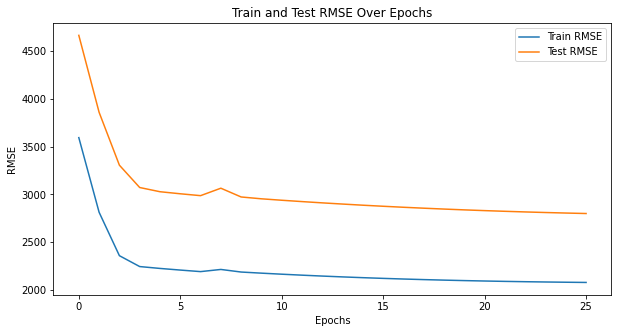

In [200]:
# 训练结束后绘制损失曲线
plt.figure(figsize=(10, 5))
plt.plot(baseline_train_losses, label='Train RMSE')
plt.plot(baseline_test_losses, label='Test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Train and Test RMSE Over Epochs')
plt.legend()
plt.show()

||baseline|
|:-:|:-:|
|最低训练损失|0.0021|
|最低测试损失|0.0087|
|数据分割&数据预处理|**先处理再分割**<br><br> ✅将标签列移到最后列<br><br>✅缺失值填补<br><br>✅按时间顺序分割<br><br>✅简单归一化|
|特征工程|**无特征工程**|
|维度重塑&窗口分割|**忽略界面的、多变量带标签的滑窗**|
|架构与预测|**1个隐藏层、20个C、多步直接预测**|
|参数群|input_size = 9<br>hidden_size = 50<br>n_epochs = 2000 <br>learning_rate = 0.001<br>window_size = 30 <br>pred_len = 5<br>num_layers = 1 <br>early_stop_alpha = 0|

#### 1.5.4.2 股票数据的数据预处理

In [44]:
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression 
import matplotlib.pyplot as plt
#import jpx_tokyo_market_prediction
import numpy as np
import datetime
import os
from decimal import ROUND_HALF_UP, Decimal
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

# typing 模块提供了一些类型，用于类型提示
from typing import Union,List,Tuple,Iterable

股票数据是一种存在很多干扰模型预测特性的数据，在进行股票数据的预处理和特征工程时，我们一面要考虑股票数据作为时序数据的特点，一面又要考虑股票数据的业务特点，这是一个及其复杂的工作。今天我们就来梳理一下对于股票数据，究竟应该完成哪些基础的预处理和特征工程工作。

- **股票数据那些会影响建模的基本特性**

> **1）批量数据带来问题**<br><br>
> 不同领域、不同行业的股价波动规律、成交逻辑可能完全不一样，大批量股票放在一起建模往往效果不会太好。因此尝试分多个领域进行建模、尝试分多个行业进行建模是股价预测中的关键手段。

=====

> **2）严重的量纲不统一问题**<br><br>不同股票的价格差异巨大、同时价格与成交量的差异也非常巨大（一般价低的股票，可能会呈现巨额的成交量），这种量纲不统一问题对以线性方程为根基的LSTM等算法来说是致命的伤害。**因此股票数据一定要按照行业、甚至按照每支股票进行归一化**。

=====

> **3）超长时间线带来的问题**<br><br>可使用的预测数据、尤其是时间点看似很多，实际上大部分过去的信息对预测未来并无帮助。

=====

> **4）排列顺序可能会带来巨大的问题**<br><br>大规模股票数据在排列的时候，往往是按照时间顺序排列的，但同一个时间点下可能存在大量不同编号的股票，因此会对数据集分割造成问题。**在分割训练集和测试集的时候，我们应该对单一股票内部进行分割，而不是对整个数据集进行分割**；同时基于LSTM的底层运行逻辑，我们**应该让全数据按照股票编号排序、每个股票内部才应该按照时间顺序排序**。如果在没有处理好排序的情况下就强行使用LSTM，可能会发现LSTM对股票毫无学习能力。

=====

> **5）对于AdjustmentFactor的使用**<br><br>单一的调整因子是无法反应一个事件对于股价的长期影响的，因此我们需要对调整因子进行累乘、以帮助将单一时间的影响扩散到整个股价序列上。

In [40]:
#没有按照股票代码分割的时候，训练集和测试集是什么样的？

train.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Sharpe Ratio,Close
0,20170104_1429,2017-01-04,1429,418.0,420.0,418.0,24900,1.0,0.0,False,0.007160,418.0
1,20170104_1884,2017-01-04,1884,457.0,471.0,457.0,250000,1.0,0.0,False,-0.014925,471.0
2,20170104_3391,2017-01-04,3391,11180.0,11320.0,11110.0,295400,1.0,0.0,False,-0.004398,11230.0
3,20170104_6902,2017-01-04,6902,5120.0,5220.0,5120.0,1657200,1.0,0.0,False,-0.015769,5204.0
4,20170104_7282,2017-01-04,7282,2775.0,2821.0,2765.0,255200,1.0,0.0,False,-0.015346,2820.0


In [41]:
train.tail()

,RowId,Date,SecuritiesCode,Open,High,Low,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Sharpe Ratio,Close
7556,20200528_1429,2020-05-28,1429,608.0,628.0,605.0,138900,1.0,0.0,False,-0.006568,614.0
7557,20200528_1884,2020-05-28,1884,7100.0,7210.0,7050.0,10500,1.0,0.0,False,-0.007042,7210.0
7558,20200528_3391,2020-05-28,3391,15500.0,15710.0,15330.0,285800,1.0,0.0,False,0.013191,15710.0
7559,20200528_6902,2020-05-28,6902,4130.0,4224.0,4120.0,2607300,1.0,0.0,False,-0.007262,4213.0
7560,20200528_7282,2020-05-28,7282,2378.0,2385.0,2303.0,731500,1.0,0.0,False,0.007816,2360.0


In [46]:
#按股票代码分割后，再分割训练集和测试集

train = pd.DataFrame()
test = pd.DataFrame()

for sec_code in stock['SecuritiesCode'].unique():
    stock_subset = stock[stock['SecuritiesCode'] == sec_code]
    train_size = int(len(stock_subset) * 0.67)
    train = pd.concat([train, stock_subset[:train_size]])
    test = pd.concat([test, stock_subset[train_size:]])

In [47]:
train #全新的训练集和测试集

,RowId,Date,SecuritiesCode,Open,High,Low,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Sharpe Ratio,Close
0,20170104_1429,2017-01-04,1429,418.0,420.0,418.0,24900,1.0,0.0,False,0.007160,418.0
9,20170105_1429,2017-01-05,1429,420.0,420.0,416.0,31700,1.0,0.0,False,-0.007109,419.0
18,20170106_1429,2017-01-06,1429,417.0,422.0,417.0,41300,1.0,0.0,False,0.002387,422.0
27,20170110_1429,2017-01-10,1429,421.0,424.0,418.0,70200,1.0,0.0,False,-0.011905,419.0
36,20170111_1429,2017-01-11,1429,419.0,421.0,415.0,35900,1.0,0.0,False,0.004819,420.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9661,20210406_7685,2021-04-06,7685,3155.0,3190.0,3030.0,120100,1.0,0.0,False,0.024845,3145.0
9671,20210407_7685,2021-04-07,7685,3170.0,3400.0,3150.0,149100,1.0,0.0,False,-0.024242,3220.0
9681,20210408_7685,2021-04-08,7685,3200.0,3330.0,3085.0,88200,1.0,0.0,False,0.006211,3300.0
9691,20210409_7685,2021-04-09,7685,3320.0,3320.0,3170.0,82900,1.0,0.0,False,0.012346,3220.0


In [45]:
# 定义基于AdjustmentFactor的调价函数
def adjust_price(price):
    """
    参数：
    price (pd.DataFrame) : 包含股票价格信息的 pd.DataFrame。

    返回：
    price DataFrame (pd.DataFrame): 含有新生成的 AdjustedClose 的股票价格DataFrame

    函数功能：
    该函数将输入的原始股价数据进行处理，生成带有调整后收盘价(AdjustedClose)的新DataFrame。
    AdjustedClose的计算方式为原收盘价与调整因子(AdjustmentFactor)的累计乘积，结果保留一位小数。
    若计算后的AdjustedClose为0，则替换为空值(np.nan)，并对此列数据进行向前填充，以保持数据完整性。
    """
    # 将 Date 列转换为 datetime 格式
    # 因为我们在前面查看数据类型的时候发现Date为object类型
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        参数:
            df (pd.DataFrame)  : 单个 SecuritiesCode 的股票价格
        返回:
            df (pd.DataFrame): 单个 SecuritiesCode 的带有 AdjustedClose 的股票价格
        """
        # 排序数据以生成 CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # 生成 CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()#累乘
        # 生成 AdjustedClose
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # 反转顺序
        df = df.sort_values("Date")
        # 填充 AdjustedClose，将 0 替换为 np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # 向前填充 AdjustedClose
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df
    
    # 生成 AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)
    return price

||baseline|带预处理/特征工程的股价预测|
|:-:|:-:|:-:|
|最低训练损失|0.0021|
|最低测试损失|0.0087|
|数据分割&数据预处理|**先处理再分割**<br><br> ✅将标签列移到最后列<br><br>✅缺失值填补<br><br>✅按时间顺序分割<br><br>✅简单归一化|**先分割再处理**<br><br>✅缺失值填补<br><br>✅按股票代码分割数据集<br>再按时间顺序分割每个股票代码内部<br><br>✅基于AdjustmentFactor调整价格<br><br>✅训练之前，确保标签列在最后的列<br><br>✅训练之前，确保归一化|

将上面的流程都封装好，我们可以定义出4大预处理函数——

In [1]:
#定义预处理函数

import pandas as pd

def preprocess_stock_data(stock_data):
    """
    对股票数据进行预处理，包括重命名列、重新排序列、填补缺失值、删除具有大量缺失值的行以及重置索引。
    
    :param stock_data: DataFrame类型，需要预处理的股票数据。
    :return: 预处理后的股票数据。
    """
    # 创建数据的副本以避免修改原始数据
    processed_data = stock_data.copy()
    
    # 将Target列重命名为Sharpe Ratio
    processed_data.rename(columns={'Target': 'Sharpe Ratio'}, inplace=True)
    
    # 填补ExpectedDividend列的缺失值
    processed_data["ExpectedDividend"] = processed_data["ExpectedDividend"].fillna(0)
    
    # 删除具有大量缺失值的行
    processed_data.dropna(inplace=True)
    
    # 重置索引
    processed_data.index = range(processed_data.shape[0])
    
    return processed_data

#定义按股票代码分割训练集数据集的函数

import pandas as pd

def split_data_by_column(data, column_name, train_ratio=0.67):
    """
    按照指定列的值分割数据集为训练集和测试集。
    
    :param data: DataFrame类型，需要分割的数据集。
    :param column_name: str类型，用作分割依据的列名。
    :param train_ratio: float类型，训练集所占比例，默认值为0.67。
    :return: 分割后的训练集和测试集。
    """
    train = pd.DataFrame()
    test = pd.DataFrame()

    for value in data[column_name].unique():
        subset = data[data[column_name] == value]
        train_size = int(len(subset) * train_ratio)
        train = pd.concat([train, subset[:train_size]])
        test = pd.concat([test, subset[train_size:]])
    
    #由于我们是按照指定列将train和test分开
    #因此现在train和test的索引被切断了
    #需要为train、test恢复索引
    
    train.index = range(train.shape[0])
    test.index = range(test.shape[0])
    
    return train, test
    
#定义基于股票代码、进行每支股票内部归一化的函数
#归一化是需要在训练之前安城的

from sklearn.preprocessing import MinMaxScaler

def normalize_data_bycode(train, test, columns_to_normalize):
    """
    对指定列的数据进行归一化处理。
    
    :param train_data: DataFrame类型，训练数据集。
    :param test_data: DataFrame类型，测试数据集。
    :param columns_to_normalize: list类型，需要归一化的列名列表。
    :return: 归一化后的训练数据集和测试数据集。
    """
    
    for sec_code in train['SecuritiesCode'].unique():
        
        train.loc[train['SecuritiesCode'] == sec_code, columns_to_normalize] = train.loc[train['SecuritiesCode'] == sec_code, columns_to_normalize].astype(float)
        test.loc[test['SecuritiesCode'] == sec_code, columns_to_normalize]  = test.loc[test['SecuritiesCode'] == sec_code, columns_to_normalize].astype(float)
        
        scaler = MinMaxScaler()
        
        # 训练集归一化
        scaler.fit(train.loc[train['SecuritiesCode'] == sec_code, columns_to_normalize])
        train.loc[train['SecuritiesCode'] == sec_code, columns_to_normalize] = scaler.transform(train.loc[train['SecuritiesCode'] == sec_code, columns_to_normalize])
        
        # 测试集归一化，注意这里使用与训练集相同的scaler
        if sec_code in test['SecuritiesCode'].values:  # 确保测试集中存在该股票代码
            test.loc[test['SecuritiesCode'] == sec_code, columns_to_normalize] = scaler.transform(test.loc[test['SecuritiesCode'] == sec_code, columns_to_normalize])
    
    return train, test

def normalize_data_byall(train, test, columns_to_normalize):
    scaler = MinMaxScaler()
        
    # 训练集归一化
    scaler.fit(train.loc[:,columns_to_normalize])
    train.loc[:, columns_to_normalize] = scaler.transform(train.loc[:, columns_to_normalize])
        
    # 测试集归一化，注意这里使用与训练集相同的scaler
    test.loc[:, columns_to_normalize] = scaler.transform(test.loc[:, columns_to_normalize])
    
    return train, test
        
# 定义基于AdjustmentFactor的调价函数

def adjust_price(price):
    """
    参数：
    price (pd.DataFrame) : 包含股票价格信息的 pd.DataFrame。

    返回：
    price DataFrame (pd.DataFrame): 含有新生成的 AdjustedClose 的股票价格DataFrame

    函数功能：
    该函数将输入的原始股价数据进行处理，生成带有调整后收盘价(AdjustedClose)的新DataFrame。
    AdjustedClose的计算方式为原收盘价与调整因子(AdjustmentFactor)的累计乘积，结果保留一位小数。
    若计算后的AdjustedClose为0，则替换为空值(np.nan)，并对此列数据进行向前填充，以保持数据完整性。
    """
    # 将 Date 列转换为 datetime 格式
    # 因为我们在前面查看数据类型的时候发现Date为object类型
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        参数:
            df (pd.DataFrame)  : 单个 SecuritiesCode 的股票价格
        返回:
            df (pd.DataFrame): 单个 SecuritiesCode 的带有 AdjustedClose 的股票价格
        """
        # 排序数据以生成 CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # 生成 CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()#累乘
        # 生成 AdjustedClose
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # 反转顺序
        df = df.sort_values("Date")
        # 填充 AdjustedClose，将 0 替换为 np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # 向前填充 AdjustedClose
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df
    
    # 生成 AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)
    return price

#### 1.5.4.3 股票数据的特征工程

股票数据是一种同时兼具金融领域属性和时间序列属性的特征，因此股票数据的特征工程也可以分为金融领域特征工程和时间序列的特征工程来看待。综合地来看，针对股票数据，我们经常会采用以下几种技术方法来完成特征工程——

> **1）平移与滞后特征**<br><br>
> **2）差分与增长率特征**<br><br>
> **3）窗口统计特征**<br><br>
> **4）金融统计特征**<br><br>
> **5）基础时间特征**

##### **1）平移与滞后特征**

平移是将时间序列数据**向后移动**一定的时间间隔、与原始数据进行对比，从而得到趋势变化的方向和幅度的策略。这种方法简单而直观，从时间序列的角度来说，它能够帮助模型理解当前观测值与其过去的观测值之间的关系、对于提取时间序列的动态特性非常有用。从金融的角度来说、平移的方式让模型能够更直观地了解过去的信息，以提供更稳定的对未来的预测。

![](https://www.business-science.io/assets/lag-explanation.PNG)

这样创建的特征叫做“滞后特征”，在数学上一般写作lag(n)，n代表滞后的具体时间点。在代码上一般使用Shift(n)功能来实现。

In [199]:
# 举例
df_stock = pd.read_csv('stock_prices.csv')
# 我们以1301股票的前十条数据为例
data = df_stock[df_stock['SecuritiesCode']==1301][['Open','Close']].head(10)
data.index = range(data.shape[0])

In [200]:
data

,Open,Close
0,2734.0,2742.0
1,2743.0,2738.0
2,2734.0,2740.0
3,2745.0,2748.0
4,2748.0,2745.0
5,2745.0,2731.0
6,2707.0,2722.0
7,2725.0,2704.0
8,2702.0,2686.0
9,2689.0,2694.0


In [201]:
# 使用shift函数可以完成平移
# 在真实应用中，我们可能会需要调整平移的间隔（即shift的参数）
# 而且这只是对某一支股票进行操作，在本案例中，我们需要对所有股票都进行平移操作
data.loc[:,'history_close1'] = data['Close'].shift(1)
data

,Open,Close,history_close1
0,2734.0,2742.0,NaN
1,2743.0,2738.0,2742.0
2,2734.0,2740.0,2738.0
3,2745.0,2748.0,2740.0
4,2748.0,2745.0,2748.0
5,2745.0,2731.0,2745.0
6,2707.0,2722.0,2731.0
7,2725.0,2704.0,2722.0
8,2702.0,2686.0,2704.0
9,2689.0,2694.0,2686.0


In [202]:
data.loc[:,'history_close2'] = data['Close'].shift(2)
data

,Open,Close,history_close1,history_close2
0,2734.0,2742.0,NaN,NaN
1,2743.0,2738.0,2742.0,NaN
2,2734.0,2740.0,2738.0,2742.0
3,2745.0,2748.0,2740.0,2738.0
4,2748.0,2745.0,2748.0,2740.0
5,2745.0,2731.0,2745.0,2748.0
6,2707.0,2722.0,2731.0,2745.0
7,2725.0,2704.0,2722.0,2731.0
8,2702.0,2686.0,2704.0,2722.0
9,2689.0,2694.0,2686.0,2704.0


##### **2）差分与增长率特征**

差分是时间序列数据中特定间隔的时间点之间的差值，增长率是时间序列数据中特定间隔之中的增长率或百分比变化率，通常差分和增长率都需要基于平移的结果来进行计算。增长率特征描述了股票价格在一段时间内的变化率。它不仅考虑股票的绝对价格变化，还考虑到了相对于其初始价格的变化幅度，因此提供了更深入的洞察。增长率可以帮助投资者理解股价的动量和方向。正增长率表示价格上涨，而负增长率表示价格下跌。在金融分析中，这一特征非常重要，因为它可以帮助投资者捕捉到短期和中期的市场趋势。但此方法可能会受到数据的大幅波动或异常值的影响，导致增长率估计不稳定。

差分和增长率并不只存在于相邻的数据之间，而可以存在多种间隔。例如，在经济数据分析中，分析季节性调整后的月度就业变化可以帮助识别经济增长的趋势，因此从上个月的某一天、到这个月的某一天的差分或增长率也是具有业务意义的。在实际进行差分和增长率特征的衍生时，我们可以使用各种不同的日期。

In [203]:
#百分比增长可以直接使用pct_change功能实现，pct_change中所需要输入的数字其实是平移的时间点数量
data.loc[:,f'window_close_2_pctchange'] = data['Close'].pct_change(2).values
data

,Open,Close,history_close1,history_close2,window_close_2_pctchange
0,2734.0,2742.0,NaN,NaN,NaN
1,2743.0,2738.0,2742.0,NaN,NaN
2,2734.0,2740.0,2738.0,2742.0,-0.000729
3,2745.0,2748.0,2740.0,2738.0,0.003652
4,2748.0,2745.0,2748.0,2740.0,0.001825
5,2745.0,2731.0,2745.0,2748.0,-0.006186
6,2707.0,2722.0,2731.0,2745.0,-0.008379
7,2725.0,2704.0,2722.0,2731.0,-0.009886
8,2702.0,2686.0,2704.0,2722.0,-0.013226
9,2689.0,2694.0,2686.0,2704.0,-0.003698


In [204]:
data.loc[:,f'window_close_3_pctchange'] = data['Close'].pct_change(3).values
data

,Open,Close,history_close1,history_close2,window_close_2_pctchange,window_close_3_pctchange
0,2734.0,2742.0,NaN,NaN,NaN,NaN
1,2743.0,2738.0,2742.0,NaN,NaN,NaN
2,2734.0,2740.0,2738.0,2742.0,-0.000729,NaN
3,2745.0,2748.0,2740.0,2738.0,0.003652,0.002188
4,2748.0,2745.0,2748.0,2740.0,0.001825,0.002557
5,2745.0,2731.0,2745.0,2748.0,-0.006186,-0.003285
6,2707.0,2722.0,2731.0,2745.0,-0.008379,-0.009461
7,2725.0,2704.0,2722.0,2731.0,-0.009886,-0.014936
8,2702.0,2686.0,2704.0,2722.0,-0.013226,-0.016477
9,2689.0,2694.0,2686.0,2704.0,-0.003698,-0.010287


In [205]:
#计算的是索引为3的值与素银为0的值之间的差异，也就是4天的差异
(2748-2742)/2742

0.002188183807439825

In [206]:
#因此，pct_change(0)是当日和当日的百分比，pct_change(1)是相邻两天的百分比
data.loc[:,f'window_close_0_pctchange'] = data['Close'].pct_change(0).values
data.loc[:,f'window_close_1_pctchange'] = data['Close'].pct_change(1).values
data

,Open,Close,history_close1,history_close2,window_close_2_pctchange,window_close_3_pctchange,window_close_0_pctchange,window_close_1_pctchange
0,2734.0,2742.0,NaN,NaN,NaN,NaN,0.0,NaN
1,2743.0,2738.0,2742.0,NaN,NaN,NaN,0.0,-0.001459
2,2734.0,2740.0,2738.0,2742.0,-0.000729,NaN,0.0,0.000730
3,2745.0,2748.0,2740.0,2738.0,0.003652,0.002188,0.0,0.002920
4,2748.0,2745.0,2748.0,2740.0,0.001825,0.002557,0.0,-0.001092
5,2745.0,2731.0,2745.0,2748.0,-0.006186,-0.003285,0.0,-0.005100
6,2707.0,2722.0,2731.0,2745.0,-0.008379,-0.009461,0.0,-0.003295
7,2725.0,2704.0,2722.0,2731.0,-0.009886,-0.014936,0.0,-0.006613
8,2702.0,2686.0,2704.0,2722.0,-0.013226,-0.016477,0.0,-0.006657
9,2689.0,2694.0,2686.0,2704.0,-0.003698,-0.010287,0.0,0.002978


In [207]:
#差分是使用diff函数来实现，diff中所需要输入的数字也是需要平移的时间点数量

data.loc[:,f'window_close_1_diff'] = data['Close'].diff(1).values
data.loc[:,f'window_close_2_diff'] = data['Close'].diff(2).values
data

,Open,Close,history_close1,history_close2,window_close_2_pctchange,window_close_3_pctchange,window_close_0_pctchange,window_close_1_pctchange,window_close_1_diff,window_close_2_diff
0,2734.0,2742.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1,2743.0,2738.0,2742.0,NaN,NaN,NaN,0.0,-0.001459,-4.0,NaN
2,2734.0,2740.0,2738.0,2742.0,-0.000729,NaN,0.0,0.000730,2.0,-2.0
3,2745.0,2748.0,2740.0,2738.0,0.003652,0.002188,0.0,0.002920,8.0,10.0
4,2748.0,2745.0,2748.0,2740.0,0.001825,0.002557,0.0,-0.001092,-3.0,5.0
5,2745.0,2731.0,2745.0,2748.0,-0.006186,-0.003285,0.0,-0.005100,-14.0,-17.0
6,2707.0,2722.0,2731.0,2745.0,-0.008379,-0.009461,0.0,-0.003295,-9.0,-23.0
7,2725.0,2704.0,2722.0,2731.0,-0.009886,-0.014936,0.0,-0.006613,-18.0,-27.0
8,2702.0,2686.0,2704.0,2722.0,-0.013226,-0.016477,0.0,-0.006657,-18.0,-36.0
9,2689.0,2694.0,2686.0,2704.0,-0.003698,-0.010287,0.0,0.002978,8.0,-10.0


##### **3）窗口统计特征**

窗口统计是一种常用的统计方法，它可以用来对时间序列数据进行分析。窗口统计的基本思想是将时间序列数据分割成若干个时间窗口，然后对每个时间窗口内的数据进行统计分析、以此来生成特征。根据窗口的类型，窗口统计可以分为跳动窗口、**滑动窗口**和**扩展窗口（也称累计窗口）**三种。这里我们主要介绍滑动窗扣和扩展窗口。

- **滑动窗口统计**：此方法将时间序列数据划分为多个**窗口**，对每个窗口内的数据执行**统计分析**（例如计算均值、方差、最大值、最小值等），再根据这些特征值的变化来辨识趋势。使用这种方法可以降低数据中噪声的影响，但需要明智地选择窗口**大小**和**步长**，以避免信息的模糊或失真。<br><br>
![picture10](https://fufanshare.oss-cn-beijing.aliyuncs.com/JPX/picture%20of%20jpx/picture10.png)<br><br>上图展示了滑动窗口统计的工作原理，窗口大小为2，步长为1，求窗口内的和作为结果。<br><br>

在机器学习和统计分析中，我们使用滑动窗口来捕捉时间序列数据的短期模式或趋势。这通常涉及以下几个步骤：

1. **选择窗口大小**：这决定了每次观察的数据点数量。窗口的大小会影响到我们捕捉到的数据模式——太小的窗口可能会过度关注噪声，而太大的窗口可能会丧失细节。

2. **选择步长**：步长决定了窗口每次移动的数据点数量。步长较小会产生更多的重叠，可以更精细的分析，但计算量也会增大。

3. **应用统计函数**：对每个窗口内的数据应用统计函数（如均值、中位数、方差等），从而提取出有用的特征或信息。常见的统计应用函数包括但不限于如下表：

滑动窗口的技术不仅可以用来提取特征，还可以用于数据的平滑、异常检测以及预测等多种任务，使其成为时间序列分析的强大工具。

与深度学习数据对tensor的操作不同，在进行特征衍生和滑窗的时候，我们往往面对的还是二维表数据，因此我们会更倾向于直接使用pandas中自带的滑窗函数来对数据进行滑窗。在这里我们使用的是rolling函数来进行滚动滑窗。

In [208]:
data['Close']

0    2742.0
1    2738.0
2    2740.0
3    2748.0
4    2745.0
5    2731.0
6    2722.0
7    2704.0
8    2686.0
9    2694.0
Name: Close, dtype: float64

In [209]:
# pd.Series.rolling即可完成滑窗操作
# window参数表示窗口的大小，这里我们设置为2
# rolling不支持自定义步长的大小
# 在rolling之后，需要指定需要计算的统计量，除了.mean()方法外
# 还可以使用 .sum() .max() .min() .std() .var()等方法
data['Close'].rolling(window=2).mean()

0       NaN
1    2740.0
2    2739.0
3    2744.0
4    2746.5
5    2738.0
6    2726.5
7    2713.0
8    2695.0
9    2690.0
Name: Close, dtype: float64

In [210]:
(2742 + 2738)/2

2740.0

In [211]:
(2738 + 2740)/2

2739.0

In [212]:
#可以调用更大的窗口
data['Close'].rolling(window=7).mean()

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6    2738.000000
7    2732.571429
8    2725.142857
9    2718.571429
Name: Close, dtype: float64

In [213]:
# 如果想要设置步长，可以通过for循环实现手动滑窗，具体可以参考下列示例代码

# 获取数据中的'Close'列
s = data['Close']
# 设置窗口大小为3
window_size = 3
# 设置步长大小为2
step_size = 2
# 初始化结果列表
result = []
# 使用for循环遍历数据，步长为step_size
for i in range(0, len(s) - window_size + 1, step_size):
    # 获取当前窗口内的数据
    window = s.iloc[i:i + window_size]
    # 计算窗口内数据的平均值并添加到结果列表中
    result.append(window.mean()) # 这里可能会根据具体需要计算的统计量进行修改
# 将结果列表转换为pandas Series对象
result = pd.Series(result)
# 输出结果
result

0    2740.000000
1    2744.333333
2    2732.666667
3    2704.000000
dtype: float64

In [214]:
# 有时候我们需要在同一个窗口下同时计算多个统计量，则可以借助agg函数来完成
for stat in ['mean', 'std', 'max', 'min', 'median']:
    data.loc[:,f'window_close_5_{stat}'] = data['Close'].rolling(window=5).agg(stat).values

In [215]:
data

,Open,Close,history_close1,history_close2,window_close_2_pctchange,window_close_3_pctchange,window_close_0_pctchange,window_close_1_pctchange,window_close_1_diff,window_close_2_diff,window_close_5_mean,window_close_5_std,window_close_5_max,window_close_5_min,window_close_5_median
0,2734.0,2742.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2743.0,2738.0,2742.0,NaN,NaN,NaN,0.0,-0.001459,-4.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2734.0,2740.0,2738.0,2742.0,-0.000729,NaN,0.0,0.000730,2.0,-2.0,NaN,NaN,NaN,NaN,NaN
3,2745.0,2748.0,2740.0,2738.0,0.003652,0.002188,0.0,0.002920,8.0,10.0,NaN,NaN,NaN,NaN,NaN
4,2748.0,2745.0,2748.0,2740.0,0.001825,0.002557,0.0,-0.001092,-3.0,5.0,2742.6,3.974921,2748.0,2738.0,2742.0
5,2745.0,2731.0,2745.0,2748.0,-0.006186,-0.003285,0.0,-0.005100,-14.0,-17.0,2740.4,6.580274,2748.0,2731.0,2740.0
6,2707.0,2722.0,2731.0,2745.0,-0.008379,-0.009461,0.0,-0.003295,-9.0,-23.0,2737.2,10.663020,2748.0,2722.0,2740.0
7,2725.0,2704.0,2722.0,2731.0,-0.009886,-0.014936,0.0,-0.006613,-18.0,-27.0,2730.0,17.958285,2748.0,2704.0,2731.0
8,2702.0,2686.0,2704.0,2722.0,-0.013226,-0.016477,0.0,-0.006657,-18.0,-36.0,2717.6,23.093289,2745.0,2686.0,2722.0
9,2689.0,2694.0,2686.0,2704.0,-0.003698,-0.010287,0.0,0.002978,8.0,-10.0,2707.4,18.836135,2731.0,2686.0,2704.0


在实际中我们常用的统计指标和函数有——

|函数|说明|代码|
|:-:|:-:|:-:|
|均值（Mean）|计算窗口内数据的平均值|rolling(window).mean()|
|标准差（Standard Deviation）|衡量窗口内数据的波动性或分散程度|rolling(window).std()|
|最小值（Minimum）|窗口内数据的最小值|rolling(window).min()|
|最大值（Maximum）|窗口内数据的最大值|rolling(window).max()|
|中位数（Median）|窗口内数据的中位数|rolling(window).median()|
|求和（Sum）|窗口内数据的总和|rolling(window).sum()|
|方差（Variance）|衡量窗口内数据的分散程度|rolling(window).var()|
|偏度（Skewness）|衡量窗口内数据分布的不对称性|rolling(window).skew()|
|峰度（Kurtosis）|衡量窗口内数据分布的尖峭程度|rolling(window).kurt()|
|百分位数（Quantile）|计算窗口内数据的特定百分位数|rolling(window).quantile(quantile)|
|移动相关性（Rolling Correlation）|计算窗口内两个时间序列的相关性|rolling(window).corr(other_series)|
|极差（max-min）|计算最大值和最小值的差值|rolling(window).max() - rolling(window).min()|
|波动比例|极差/最大值最小值的均值|(rolling(window).max() - rolling(window).min())<br>/2*(rolling(window).max() + rolling(window).min())|

*quantile是你希望计算的百分位数（如0.5表示50%百分位数，即中位数）*<br>

*other_series是另一个时间序列数据*

> 波动比率

在时序数据中，特别是股票价格数据，单纯地考虑价格的波动值可能不够充分，因为股票的价格在不同时间可能有很大的差异（比如，有的股票在过去的价位很低，现在价位很高）。在这种情况下，固定的波动值对于低价股票可能非常显著，但对于高价股票则可能不那么显著。因此在股票数据进行调整衍生时，我们还会考虑一种被称之为“波动比率”的特殊统计指标。其计算公式为：
$$波动幅度 = \frac{最大值 - 最小值}{\frac{最大值 + 最小值}{2}}$$

这个比例反映了最大值和最小值之间的差异相对于它们平均水平的大小，可以被看作是一种衡量特定时间段内价格波动程度的方法。较高的值可能表示价格在该期间内有较大的波动，而较低的值可能表示价格较为稳定。

In [216]:
# 极差与窗口波动率的计算
# 创建示例数据集
data = df_stock[df_stock['SecuritiesCode']==1301][['Date','Close']].head(10)
#恢复索引
data.index = range(data.shape[0])
data

,Date,Close
0,2017-01-04,2742.0
1,2017-01-05,2738.0
2,2017-01-06,2740.0
3,2017-01-10,2748.0
4,2017-01-11,2745.0
5,2017-01-12,2731.0
6,2017-01-13,2722.0
7,2017-01-16,2704.0
8,2017-01-17,2686.0
9,2017-01-18,2694.0


In [217]:
# 创建一个10天时间窗口的最大值、最小值和差值特征
window_period = 5
data[f'window_close_{window_period}_max'] = data['Close'].rolling(window=window_period).max()
data[f'window_close_{window_period}_min'] = data['Close'].rolling(window=window_period).min()
data[f'window_close_{window_period}_max-min'] = data[f'window_close_{window_period}_max'] - data[f'window_close_{window_period}_min']

# 显示结果
data

,Date,Close,window_close_5_max,window_close_5_min,window_close_5_max-min
0,2017-01-04,2742.0,NaN,NaN,NaN
1,2017-01-05,2738.0,NaN,NaN,NaN
2,2017-01-06,2740.0,NaN,NaN,NaN
3,2017-01-10,2748.0,NaN,NaN,NaN
4,2017-01-11,2745.0,2748.0,2738.0,10.0
5,2017-01-12,2731.0,2748.0,2731.0,17.0
6,2017-01-13,2722.0,2748.0,2722.0,26.0
7,2017-01-16,2704.0,2748.0,2704.0,44.0
8,2017-01-17,2686.0,2745.0,2686.0,59.0
9,2017-01-18,2694.0,2731.0,2686.0,45.0


In [218]:
# 使用平均值为基准计算波动比率
data.loc[:,f'window_close_{window_period}_max-min_ratio_avg'] = 2 * (data[f'window_close_{window_period}_max'] - data[f'window_close_{window_period}_min']) / (data[f'window_close_{window_period}_max'] + data[f'window_close_{window_period}_min'])
data

,Date,Close,window_close_5_max,window_close_5_min,window_close_5_max-min,window_close_5_max-min_ratio_avg
0,2017-01-04,2742.0,NaN,NaN,NaN,NaN
1,2017-01-05,2738.0,NaN,NaN,NaN,NaN
2,2017-01-06,2740.0,NaN,NaN,NaN,NaN
3,2017-01-10,2748.0,NaN,NaN,NaN,NaN
4,2017-01-11,2745.0,2748.0,2738.0,10.0,0.003646
5,2017-01-12,2731.0,2748.0,2731.0,17.0,0.006206
6,2017-01-13,2722.0,2748.0,2722.0,26.0,0.009506
7,2017-01-16,2704.0,2748.0,2704.0,44.0,0.016141
8,2017-01-17,2686.0,2745.0,2686.0,59.0,0.021727
9,2017-01-18,2694.0,2731.0,2686.0,45.0,0.016614


**【思考】**：为什么滑动窗口统计能产生显著的效果？

**滑窗统计本质是一种平滑手段**。例如，通过计算移动平均，我们可以得到数据的局部平均值，从而捕捉到数据的中期趋势，而不受到短期波动的干扰，以此来为模型提供更多的信息和空间。例如，当我们使用滑动窗口技术计算一支股票的平均值，并将改平均值绘制成图像时，我们可以看到——

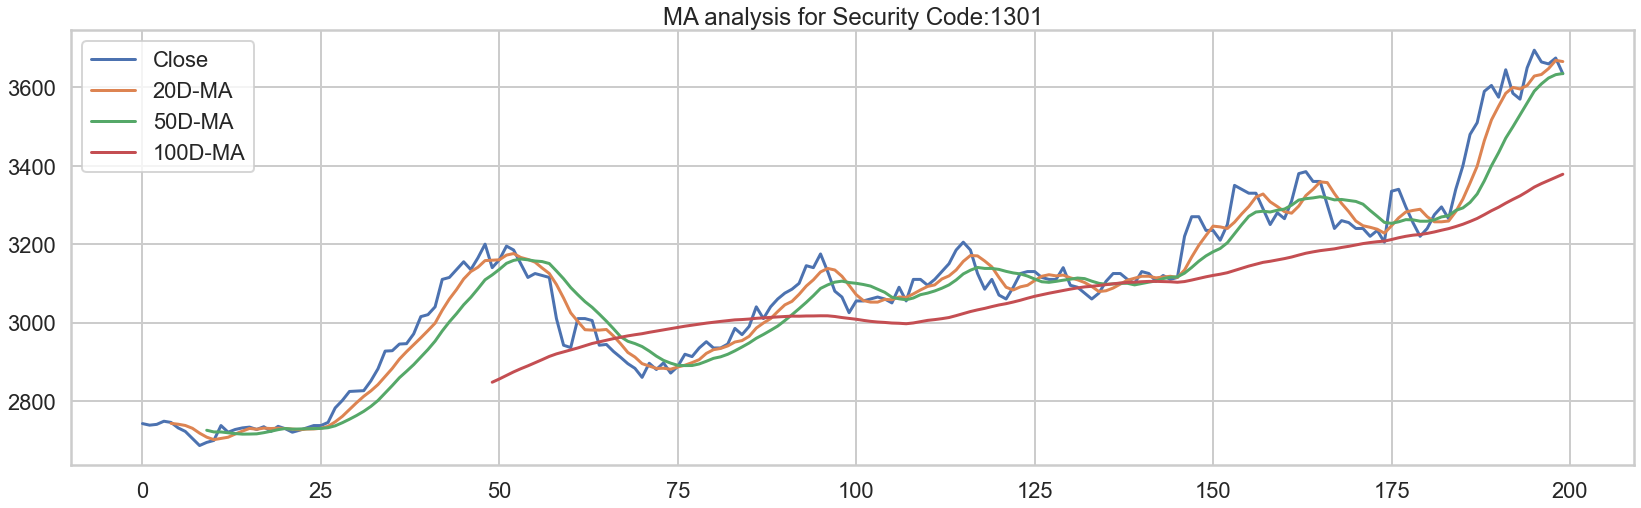

In [219]:
import seaborn as sns
# 设置绘图风格为白色网格
sns.set_style("whitegrid")
# 设置图形大小
sns.set(rc={'figure.figsize':(28,8)})
# 设置全局字体大小
sns.set_context("poster")
# 获取指定股票代码的数据，并按日期排序
df_stock2 = df_stock[df_stock['SecuritiesCode'] == 1301][:200].reset_index(drop = True)
df_stock2 = df_stock2.sort_values(by = "Date").reset_index()
# 提取日期和收盘价数据
df_s = df_stock2[['Date', 'Close']].reset_index(drop = True)
# 计算20日、50日和100日简单移动平均线
df_s['20D-MA'] = df_s['Close'].rolling(window=5).mean()
df_s['50D-MA'] = df_s['Close'].rolling(window=10).mean()
df_s['100D-MA'] = df_s['Close'].rolling(window=50).mean()
# 设置日期为索引
df_s.set_index('Date')
# 删除日期列
del df_s['Date']
# 设置绘图风格为白色网格
sns.set_style("whitegrid")
# 绘制简单移动平均线图，并设置标题
df_s.plot(title = "MA analysis for Security Code:" + str(1301));

观察图像，我们会发现移动平均线比实际股价走势要更加平滑，并且随着时间窗口的增大、这种平滑效果会变得越来越明显。因此，移动平均线实际上捕捉到了数据的长期趋势特性，并在一定程度上消除了数据的短期波动。

打开任何股票软件，通常我们都可以看到某只股票的5日、10日、20日移动平均线（MA）：

![picture12](https://fufanshare.oss-cn-beijing.aliyuncs.com/JPX/picture%20of%20jpx/picture12.png)

在股票市场中，这些移动平均线之间的交叉具有特殊的意义。例如，短期均线下穿长期均线时，这种现象被称为“**死叉**”，通常被视为卖出的信号；相反，短期均线上穿长期均线时，被称为“**金叉**”，通常被视为买入的信号。

- **扩张窗口统计**

该方法从时间序列数据的起始点出发，**逐步扩大窗口**范围，对每个扩张窗口内的数据进行统计分析。通过观察扩张窗口内的统计量如滚动统计量，我们可以获得对于数据整体变化趋势的深入洞察。尽管此方法能够充分利用历史数据，但选择合适的扩展步长同样关键，以确保计算效率和捕获到的趋势明确性。<br><br>
![picture11](https://fufanshare.oss-cn-beijing.aliyuncs.com/JPX/picture%20of%20jpx/picture11.png)<br><br>上图解释了扩张窗口统计的原理，窗口范围从最开始逐渐扩展，步长为1，求每个扩展窗口的和。
<br><br>

In [58]:
# 扩展窗口的实现代码也很简单，只需要pd.Series.expanding()即可，后面加上自己需要计算的统计指标
data['Close'].expanding().mean()

0    2742.000000
1    2740.000000
2    2740.000000
3    2742.000000
4    2742.600000
5    2740.666667
6    2738.000000
7    2733.750000
8    2728.444444
9    2725.000000
Name: Close, dtype: float64

In [59]:
# 我们把扩展窗口计算的均值赋值给新列
data['expand_mean'] = data['Close'].expanding().mean()
data

,Date,Close,window_close_5_max,window_close_5_min,window_close_5_max-min,window_close_5_max-min_ratio_avg,expand_mean
0,2017-01-04,2742.0,NaN,NaN,NaN,NaN,2742.000000
1,2017-01-05,2738.0,NaN,NaN,NaN,NaN,2740.000000
2,2017-01-06,2740.0,NaN,NaN,NaN,NaN,2740.000000
3,2017-01-10,2748.0,NaN,NaN,NaN,NaN,2742.000000
4,2017-01-11,2745.0,2748.0,2738.0,10.0,0.003646,2742.600000
5,2017-01-12,2731.0,2748.0,2731.0,17.0,0.006206,2740.666667
6,2017-01-13,2722.0,2748.0,2722.0,26.0,0.009506,2738.000000
7,2017-01-16,2704.0,2748.0,2704.0,44.0,0.016141,2733.750000
8,2017-01-17,2686.0,2745.0,2686.0,59.0,0.021727,2728.444444
9,2017-01-18,2694.0,2731.0,2686.0,45.0,0.016614,2725.000000


##### **4）金融统计指标衍生**

- **指数加权移动平均（EWMA）**

指数加权移动平均（EWMA）是时间序列数据平滑方法之一，它是尤其重要的一种统计指标，尤其在金融和经济领域中具有广泛的应用。与使用滑动窗口的简单移动平均不同，EWMA为数据中的每个观测值分配不同的权重。这种权重分配是按照指数递减的方式进行的，这意味着近期的数据点会被赋予较高的权重，而较早的数据点权重则逐渐降低。与简单移动平均线（SMA）相比，EWMA对**最近**的价格变化更为**敏感**。这意味着，当市场出现新的信息或变化时，EWMA能够更快地反映这些变化。

其计算公式为：

$$EWMA(t)=\alpha * x(t)+(1−\alpha)*EWMA(t−1)$$

> 其中，$x(t)$ 是在时间点t的观测值，$EWMA(t−1)$ 是在时间点t-1的指数加权移动平均值，$\alpha$ 是权重因子，范围在0到1之间。
> - 当$\alpha$接近1时，表示我们更多地依赖最近的观测值。这使得EWMA对近期变化更加敏感，但也可能引入更多的噪声。
> - 而当$\alpha$接近0时，模型将更加依赖过去的平均值，从而使得EWMA更加平稳。但这也可能使其对突发的变化反应迟钝。

在实际应用中，选择合适的 $\alpha$ 值至关重要。这通常需要根据具体的应用场景和数据特性进行选择。例如，金融市场中的股票价格可能会频繁波动，因此可能需要一个较高的 $\alpha$ 值来捕捉这些短期变化。而在其他更为稳定的时间序列数据中，较低的 $\alpha$ 值可能更为合适。

In [64]:
# pd.Series.ewm 可以实现指数加权的计算，在后面加上.mean()就可以计算指数加权平均

# 固定alpha_value的值并且设置adjust=False，表示不计算第一行数据
alpha_value = 0.3
data['ewma'] = data['Close'].ewm(alpha=alpha_value, adjust=False).mean()
data

,Date,Close,window_close_5_max,window_close_5_min,window_close_5_max-min,window_close_5_max-min_ratio_avg,expand_mean,ewma
0,2017-01-04,2742.0,NaN,NaN,NaN,NaN,2742.000000,2742.000000
1,2017-01-05,2738.0,NaN,NaN,NaN,NaN,2740.000000,2740.800000
2,2017-01-06,2740.0,NaN,NaN,NaN,NaN,2740.000000,2740.560000
3,2017-01-10,2748.0,NaN,NaN,NaN,NaN,2742.000000,2742.792000
4,2017-01-11,2745.0,2748.0,2738.0,10.0,0.003646,2742.600000,2743.454400
5,2017-01-12,2731.0,2748.0,2731.0,17.0,0.006206,2740.666667,2739.718080
6,2017-01-13,2722.0,2748.0,2722.0,26.0,0.009506,2738.000000,2734.402656
7,2017-01-16,2704.0,2748.0,2704.0,44.0,0.016141,2733.750000,2725.281859
8,2017-01-17,2686.0,2745.0,2686.0,59.0,0.021727,2728.444444,2713.497301
9,2017-01-18,2694.0,2731.0,2686.0,45.0,0.016614,2725.000000,2707.648111


很显然，只要我们在指数加权运算的后面加上一系列简单的统计量，就可以计算指数加权方差、指数加权极值等等。其他的统计量包括：
- .mean()：计算指数加权移动平均值。
- .var()：计算指数加权移动方差。
- .std()：计算指数加权移动标准差。这实际上是 .var() 的平方根。
- .corr()：计算两组数的指数加权移动相关系数。
- .cov()：计算两组数的指数加权移动协方差。

你可能发现了，虽然都是统计量，但是EWMA计算过程中并不需要指定窗口大小！对于EWMA而言，我们无需设置单独的窗口，而是通过设置各种参数来控制衰减因子$\alpha$，从而控制权重衰减的周期。在实际计算过程中，权重衰减的速率决定了本次EWMA计算时涉及了多少样本——

|索引|样本|权重|
|:-:|:-:|:-:|
|1|xxx|1.0|
|2|xxx|0.9|
|3|xxx|0.8|
|...|||
|9|xxx|0.2|
|10|xxx|0.1|
|11|xxx|0|
|12|xxx|0|

|索引|样本|权重|
|:-:|:-:|:-:|
|1|xxx|1.0|
|2|xxx|0.99|
|3|xxx|0.98|
|...|||
|90|xxx|0.02|
|100|xxx|0.01|
|101|xxx|0.00|
|102|xxx|0.00|

**EWMA (指数加权移动平均) 参数详解**：

1. **衰减因子选择：**
选择权重衰减速率时，必须指定以下参数中的一个：
> - alpha：直接指定平滑因子 α，范围为 0 < α ≤ 1。
> - com(center of mass)：指定衰减的中心质量（物理学概念）。通过公式 $\alpha = \frac{1}{1 + \text{com}}$计算，其中 com ≥ 0。
> - halflife：指定半衰期（应用于化学和核物理学）。通过公式$\alpha = 1 - \exp\left(-\frac{\ln(2)}{\text{halflife}}\right)$计算，其中 halflife > 0。
> - span：指定衰减的跨度（数学和统计学概念）。通过公式 $\alpha = \frac{2}{\text{span} + 1}$计算，其中 span ≥ 1。股票数据使用span参数的情况会比较多一些。

2. **span参数：**
在金融领域，分析师和交易员常参考固定天数的移动平均，如10天、30天、50天。但简单的移动平均可能忽略短期的重要变化。EWMA，特别是通过设置span，能够更精确地反映数据变化。
> - 跨度的意义：例如，"30天的跨度"（span=30）代表权重衰减的基本长度为30天。30天前的数据权重是当前数据的一半。超过30天的数据虽被考虑，但权重迅速衰减。
> - 跨度与其他移动平均的对比：span参数为EWMA提供了直观的定义方式，可以类比时间序列操作中的滑窗。方便与简单移动平均线（SMA）等进行比较。

 3. **其他参数：**
> - min_periods：窗口中所需的最小观测值数量。默认值为 0。少于此数量则结果为 np.nan。
> - adjust：默认为 True。在初始时期，权重会被调整除以一个衰减因子，从而解决权重不平衡的问题（当考虑 EWMA 为一种移动平均）。
> - ignore_na：是否在计算权重时忽略缺失值。默认为 False。
> - axis：指定计算的方向。默认为 0（或 'index'）。若为 0 或 'index'，则沿行计算；若为 1 或 'columns'，则沿列计算。
> - times 参数：适用于不规则时间序列数据。这个参数可以指定每个数据点的时间戳，从而在计算衰减因子时根据时间戳得到更准确的结果。例如，在股票价格数据中，由于股市在周末和节假日不交易，直接使用 .ewm 函数可能导致不够准确的计算结果。通过提供一个时间戳序列作为 times 参数，可以更准确地反映数据的变化趋势。

In [66]:
alpha_value = 0.3
data['ewma'] = data['Close'].ewm(span=30).mean()
data

,Date,Close,window_close_5_max,window_close_5_min,window_close_5_max-min,window_close_5_max-min_ratio_avg,expand_mean,ewma
0,2017-01-04,2742.0,NaN,NaN,NaN,NaN,2742.000000,2742.000000
1,2017-01-05,2738.0,NaN,NaN,NaN,NaN,2740.000000,2739.933333
2,2017-01-06,2740.0,NaN,NaN,NaN,NaN,2740.000000,2739.957053
3,2017-01-10,2748.0,NaN,NaN,NaN,NaN,2742.000000,2742.173178
4,2017-01-11,2745.0,2748.0,2738.0,10.0,0.003646,2742.600000,2742.816348
5,2017-01-12,2731.0,2748.0,2731.0,17.0,0.006206,2740.666667,2740.504666
6,2017-01-13,2722.0,2748.0,2722.0,26.0,0.009506,2738.000000,2737.304163
7,2017-01-16,2704.0,2748.0,2704.0,44.0,0.016141,2733.750000,2732.107518
8,2017-01-17,2686.0,2745.0,2686.0,59.0,0.021727,2728.444444,2725.516314
9,2017-01-18,2694.0,2731.0,2686.0,45.0,0.016614,2725.000000,2721.338648


- **其他常见金融业务指标**

> **对数收益率（Logarithmic Return）**：具体计算方式为$\ln(\frac{P_{t}}{P_{t-1}})$，其中P表示收盘价，这个指标在金融业务中也简称为“对数回报”或“对数收益”，在金融分析中是一种常用的指标。

In [220]:
# 对数收益率的实现
np.log(data['Close'] / data['Close'].shift(1))

0         NaN
1   -0.001460
2    0.000730
3    0.002915
4   -0.001092
5   -0.005113
6   -0.003301
7   -0.006635
8   -0.006679
9    0.002974
Name: Close, dtype: float64

> **布林带（Bollinger Bands）**：由三条线组成，中间线通常是股票的简单移动平均线，而上下两条线分别是上下移动平均线的标准差*2。这些带状线可以帮助分析股价的波动性和潜在的价格极限。

![](https://rich01.com/wp-content/uploads/20200716220218_73.jpg)

In [70]:
#假设窗口为20天
rolling_mean = data['Close'].rolling(window=20).mean()
rolling_std = data['Close'].rolling(window=20).std()
upper_band = rolling_mean + (rolling_std * 2)
lower_band = rolling_mean - (rolling_std * 2)

> **相对强弱指数（RSI）**：一种动量振荡器，测量股价最近的涨跌速度和变化以确定超买或超卖条件。

In [72]:
delta = data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
rsi = 100 - (100 / (1 + rs))

> **随机振荡器（Stochastic Oscillator）**：测量股票价格相对于其高低范围的位置，用于识别价格趋势的反转。

In [77]:
stock.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
68,20170104_1926,2017-01-04,1926,1210.0,1223.0,1209.0,1223.0,252000,1.0,NaN,False,-0.011429
209,20170104_2540,2017-01-04,2540,1889.0,1907.0,1877.0,1907.0,6800,1.0,NaN,False,-0.002114
503,20170104_4025,2017-01-04,4025,787.0,808.0,785.0,807.0,46000,1.0,NaN,False,0.004957
603,20170104_4526,2017-01-04,4526,4760.0,4825.0,4725.0,4825.0,8900,1.0,NaN,False,-0.010482
730,20170104_4956,2017-01-04,4956,1268.0,1309.0,1268.0,1309.0,64800,1.0,NaN,False,0.005364


In [78]:
low_min = stock['Low'].rolling(window=14).min()
high_max = stock['High'].rolling(window=14).max()
k = ((stock['Close'] - low_min) / (high_max - low_min)) * 100

In [79]:
k

68               NaN
209              NaN
503              NaN
603              NaN
730              NaN
             ...    
2331339     0.404514
2331573     6.110283
2331588    85.309772
2331923     4.151586
2331945    16.286506
Length: 12020, dtype: float64

> **MACD（Moving Average Convergence Divergence）**：一种趋势跟踪动量指标，显示了两个移动平均之间的关系。

In [80]:
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
signal_line = macd.ewm(span=9, adjust=False).mean()

> **成交量加权平均价格（VWAP）**：通过将成交量考虑在内来计算平均价格，为每个交易日提供一个基准。

In [81]:
vwap = (stock['Volume'] * (stock['High'] + stock['Low'] + stock['Close']) / 3).cumsum() / stock['Volume'].cumsum()

> **Beta系数**：衡量个别股票相对于整个市场波动的敏感度，是衡量风险的一个指标。计算Beta系数通常需要股票收益率与市场收益率的数据。这通常涉及到复杂的统计分析，可以通过线性回归模型实现：

In [ ]:
import statsmodels.api as sm

# 假设 stock_returns 是股票收益率序列，market_returns 是市场收益率序列
X = sm.add_constant(market_returns)  # 添加常数项
model = sm.OLS(stock_returns, X).fit()
beta = model.params[1]

> **股息收益率**：表示公司支付的股息与其股价的比例，是评估股票投资回报的一种方式。

In [ ]:
# 假设 df_stock 已经包含了需要的列：'Dividend', 'Close', 'EPS'
# 计算股息收益率
df_stock['Dividend_Yield'] = (df_stock['Dividend'] / df_stock['Close']) * 100

> **市盈率（P/E比率）**：公司市值与其盈利的比率，是评估股票价格是否合理的常用指标。

In [ ]:
# 计算市盈率
df_stock['PE_Ratio'] = df_stock['Close'] / df_stock['EPS']

> **K线中的上隐线与下隐线长度**

以篮球比赛为例，比赛的每一分、每一秒都充满了紧张和刺激，但我们通常只关心得分、助攻、篮板等关键数据。同理，股票的价格每天都在变动，但我们可以通过K线图来捕捉每天的四个关键价格，其由若干个阴线和阳线构成，红色的是阳线，绿色的阴线：
![](https://fufanshare.oss-cn-beijing.aliyuncs.com/JPX/picture%20of%20jpx/picture21.png)

以单日K线图为例，每根K线图都包含了四个价格信息：开盘价、收盘价、最高价和最低价，中间的柱子叫做实体部分，实体部分可以是空白的，也可以是红色或绿色填充的。实体上面叫做上影线，在阳线中表示当日最高价和收盘价之间的差值（如果是阴线的话就是开盘价），下影线同理。
![](https://fufanshare.oss-cn-beijing.aliyuncs.com/JPX/picture%20of%20jpx/picture22.png)

在这部分，上影线和下影线可以作为一个**技术指标**：

在K线图中，长上影线和长下影线确实常常被解读为市场的不确定性和多空双方的斗争（多指的是做多的一方，空指的是做空的一方）。总之，影线的长短可以反映买卖双方的交易激烈程度。当影线很长时，说明当日股票价格波动较大，买卖双方交易激烈。

我们可以使用下面的代码计算K线图中的上影线和下影线长度：

In [31]:
data = df_stock[df_stock['SecuritiesCode']==1301][['Date','Open','Close','High','Low']].head(10)
# 上影线长度其实就是最高价和max(Close,Open)的差值
data['Upper_Shadow'] = data['High'] - data[['Close', 'Open']].max(axis=1)
# 下影线长度其实就是最低价和min(Close,Open)的差值
data['Lower_Shadow'] = data[['Close', 'Open']].min(axis=1) - data['Low']
data

,Date,Open,Close,High,Low,Upper_Shadow,Lower_Shadow
0,2017-01-04,2734.0,2742.0,2755.0,2730.0,13.0,4.0
1865,2017-01-05,2743.0,2738.0,2747.0,2735.0,4.0,3.0
3730,2017-01-06,2734.0,2740.0,2744.0,2720.0,4.0,14.0
5595,2017-01-10,2745.0,2748.0,2754.0,2735.0,6.0,10.0
7460,2017-01-11,2748.0,2745.0,2752.0,2737.0,4.0,8.0
9325,2017-01-12,2745.0,2731.0,2747.0,2703.0,2.0,28.0
11190,2017-01-13,2707.0,2722.0,2730.0,2707.0,8.0,0.0
13055,2017-01-16,2725.0,2704.0,2725.0,2696.0,0.0,8.0
14920,2017-01-17,2702.0,2686.0,2704.0,2682.0,2.0,4.0
16785,2017-01-18,2689.0,2694.0,2695.0,2681.0,1.0,8.0


##### 5）基础时间特征

基础时间特征是从时间序列中数据点的时间戳派生的简单特征。可以使用九天老师的timeseries_feature函数来实现

In [254]:
def timeseries_feature(timeseris):
    """:params timeseris: 必须是时间戳格式才能调用dt方法"""
    features_new = pd.DataFrame([])
    cols_name = timeseris.name

    # 提取年份、月份和日期
    features_new[cols_name + '_year'] = timeseris.dt.year
    features_new[cols_name + '_month'] = timeseris.dt.month
    features_new[cols_name + '_day'] = timeseris.dt.day

    # 提取自然周期
    features_new[cols_name + '_quarter'] = timeseris.dt.quarter
    features_new[cols_name + '_weekofyear'] = timeseris.dt.weekofyear
    features_new[cols_name + '_dayofweek'] = timeseris.dt.dayofweek
    # features_new[cols_name + '_weekend'] = (features_new[cols_name + '_dayofweek'] >= 5).astype(int)

    return features_new

通过上面的timeseries_feature函数可以为数据衍生出如周、月、季度、年等时间单位特征，这对于分析季节性和其他基于时间的模式非常有帮助，具体体现在：

1. 年、月、日：这三个特征可以帮助模型理解数据中的长期趋势、季节性变化以及一个月中某些日子可能存在的模式。例如，零售业销售数据可能会在特定的月份、季度或某些日期（比如黑色星期五）上升。

2. 季度：许多业务活动都是按季度进行的，例如公司的季度报告。这个特征可以帮助模型捕捉这些季度效应。

3. 一年中的第几周：这可以捕捉到一年中某些周的特定模式，例如假期购物季。

4. 一周中的第几天：某些事件或模式可能在一周的某些天出现，比如周末或周中。例如，周五的电影票销售可能会比周三的多。

5. 是否为周末：与“一周中的第几天”类似，但更加明确地标注了是否为周末。对于一些业务，周末可能与工作日有非常大的不同，例如餐馆的就餐量或旅游景点的参观量。（股票在周末和节假日不会交易，所以注释掉了）

##### 6）批量特征衍生函数

将上述特征探索方法、以丰富的窗口长度应用于股票特征：

In [2]:
#定义基于股票代码、对每支股票内部进行特征工程的函数

def create_feature_bycode(df_temp,periods,columns):
    """
    :param df_temp: pd.DataFrame, 输入的数据框，其中需要包含金融时间序列数据。
                    数据框需要至少包含日期、股票代码、收盘价、调整收盘价、最高价、最低价等列。
                    其中日期会被用于排序，股票代码用于分组操作，而其他列用于特征工程。

    :param periods: Union[List, Tuple, Iterable], 一个可迭代的对象（如列表、元组等），包含了想要用于计算历史数据平移和窗口统计的时间段。
                    例如，如果想要考虑过去5天、10天和20天的数据，那么periods就应该是[5, 10, 20]。

    :return: pd.DataFrame, 增加了新特征的数据框。
    """
    df = df_temp.copy()
    #df.sort_values(by='Date',inplace=True)
    key_col = 'SecuritiesCode'
    new_features = []

    #在不同的时间窗口下循环
    #但是所有的操作都是针对单一股票的
    #先将股票分割、再对每支股票进行平移、差分、金融指标计算等等
    for period in periods:
        for column in columns:
            #先把数据按股票编号分组
            grouped = df.groupby(key_col)[column]
            
            #对数收益率
            log_return = np.log(grouped.shift(0) / grouped.shift(period)+1e5).bfill()
    
            #滚动窗口下的布林带
            mean1 = grouped.rolling(window=period).mean()
            std1 = grouped.rolling(window=period).std()
            upper_band = mean1 + std1*2
            lower_band = mean1 - std1*2

            #历史平移
            history = grouped.shift(period)

            #增长率特征
            window_pctchange = grouped.pct_change(period)

            #差分特征
            window_diff = grouped.diff(period)
            
            #变化率特征
            volatility = np.log(df[column]+1e5).groupby(df[key_col]).diff().rolling(period,min_periods=1).std()

            #指数加权移动平均
            ewma = grouped.ewm(span=period,adjust=False).mean()
            
            #滚动窗口的统计量
            mean2 = grouped.rolling(window=period).agg('mean')
            std2 = grouped.rolling(window=period).agg('std')
            max1 = grouped.rolling(window=period).agg('max')
            min1 = grouped.rolling(window=period).agg('min')
            median1 = grouped.rolling(window=period).agg('median')

            #极差特征
            max_min = max1 - min1
            
            #波动比例特征
            avg_value = (max1 + min1) + 0.0001 / 2
            fluctuation_rate = max_min / avg_value
            
            for name_,nf in zip(["log_return","mean1","std1","upper_band","lower_band",
                                 "history","window_pctchange","window_diff","volatility",
                               "ewma","mean2","std2","max1","min1","median1",
                               "max_min","avg_value","fluctuation_rate"],
                               [log_return, mean1, std1, upper_band, lower_band
                                ,history, window_pctchange, window_diff, volatility
                                , ewma, mean2, std2, max1, min1, median1
                                , max_min, avg_value, fluctuation_rate]):
                nf = nf.reset_index(level=0, drop=True)
                nf.name = f'{name_}_{column}_{period}'
                new_features.append(nf)
    
    new_df = pd.concat(new_features, axis=1)
    df = pd.concat([df,new_df], axis=1) #这里先合并后，下面的操作就可以对衍生的操作进行
    
    #还有一些特征，是硬性的指标、并不需要时间窗口
    
    #拓展窗口的移动平均
    for column in df.columns[3:]:
        df.loc[:, f'{column}_expand_mean'] = df.groupby(key_col)['Close'].transform(lambda x: x.expanding().mean())

    #上下影线特征
    df['Upper_Shadow'] = df['High'] - df[['Close', 'Open']].max(axis=1)
    df['Lower_Shadow'] = df[['Close', 'Open']].min(axis=1) - df['Low']

    # 基础时间特征
    time_feature = timeseries_feature(df['Date'])
    
    return pd.concat([df,time_feature],axis=1)

新增业务特征，波动率——

对数收益率 $$r_t = \log(P_t) - \log(P_{t-1})$$

滚动窗口内的标准差（波动率）
$$\sigma_t = \sqrt{\frac{1}{n-1} \sum_{i=t-n+1}^{t} (r_i - \bar{r})^2}$$

In [3]:
def create_feature_byall(df_temp, periods, columns):
    df = df_temp.copy()
    new_features = []

    for period in periods:
        for column in columns:
            # 对数收益率
            log_return = np.log(df[column].shift(0) / df[column].shift(period) + 1e-5).bfill()

            # 滚动窗口下的布林带
            mean1 = df[column].rolling(window=period).mean()
            std1 = df[column].rolling(window=period).std()
            upper_band = mean1 + std1 * 2
            lower_band = mean1 - std1 * 2

            # 历史平移
            history = df[column].shift(period)

            # 增长率特征
            window_pctchange = df[column].pct_change(period)

            # 差分特征
            window_diff = df[column].diff(period)

            # 变化率特征
            volatility = np.log(df[column] + 1e-5).diff().rolling(period, min_periods=1).std()

            # 指数加权移动平均
            ewma = df[column].ewm(span=period, adjust=False).mean()

            # 滚动窗口的统计量
            mean2 = df[column].rolling(window=period).agg('mean')
            std2 = df[column].rolling(window=period).agg('std')
            max1 = df[column].rolling(window=period).agg('max')
            min1 = df[column].rolling(window=period).agg('min')
            median1 = df[column].rolling(window=period).agg('median')

            # 极差特征
            max_min = max1 - min1

            # 波动比例特征
            avg_value = (max1 + min1) / 2 + 0.0001
            fluctuation_rate = max_min / avg_value

            for name_, nf in zip(["log_return", "mean1", "std1", "upper_band", "lower_band",
                                  "history", "window_pctchange", "window_diff", "volatility",
                                  "ewma", "mean2", "std2", "max1", "min1", "median1",
                                  "max_min", "avg_value", "fluctuation_rate"],
                                 [log_return, mean1, std1, upper_band, lower_band,
                                  history, window_pctchange, window_diff, volatility,
                                  ewma, mean2, std2, max1, min1, median1,
                                  max_min, avg_value, fluctuation_rate]):
                nf.name = f'{name_}_{column}_{period}'
                new_features.append(nf)

    new_df = pd.concat(new_features, axis=1)
    df = pd.concat([df, new_df], axis=1)  # 合并新特征

    # 上下影线特征
    df['Upper_Shadow'] = df['High'] - df[['Close', 'Open']].max(axis=1)
    df['Lower_Shadow'] = df[['Close', 'Open']].min(axis=1) - df['Low']

    # 基础时间特征
    time_feature = timeseries_feature(df['Date'])
    df = pd.concat([df, time_feature], axis=1)

    return df

In [4]:
def timeseries_feature(timeseries):
    """:params timeseries: 是Series结构，并且必须是时间戳格式才能调用dt方法"""
    
    timeseries = pd.to_datetime(timeseries)
    features_new = pd.DataFrame([])
    cols_name = timeseries.name

    # 提取年份、月份和日期
    features_new[cols_name + '_year'] = timeseries.dt.year
    features_new[cols_name + '_month'] = timeseries.dt.month
    features_new[cols_name + '_day'] = timeseries.dt.day

    # 提取自然周期
    features_new[cols_name + '_quarter'] = timeseries.dt.quarter
    features_new[cols_name + '_weekofyear'] = timeseries.dt.isocalendar().week
    features_new[cols_name + '_dayofweek'] = timeseries.dt.dayofweek
    # features_new[cols_name + '_weekend'] = (features_new[cols_name + '_dayofweek'] >= 5).astype(int)

    return features_new

#### 1.5.4.4 股票数据预处理与特征工程的实现

In [5]:
import numpy as np #数据处理
import pandas as pd #数据处理
import matplotlib as mlp
import matplotlib.pyplot as plt #绘图
from sklearn.preprocessing import MinMaxScaler #数据预处理
from sklearn.metrics import mean_squared_error
import torch 
import torch.nn as nn #导入pytorch中的基本类
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.utils.data as data
# typing 模块提供了一些类型，辅助函数中的参数类型定义
from typing import Union,List,Tuple,Iterable
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from decimal import ROUND_HALF_UP, Decimal

In [6]:
stock= pd.read_csv('stock_prices.csv')
stock_list = pd.read_csv('stock_list.csv')

In [7]:
#为了效率我们抽取其中的10支股票
#你可以更换随机数种子，当你更换后，你选出的5支股票可能与我不一样

# 从 SecuritiesCode 中随机选择5个不同的股票代码
selected_codes = stock['SecuritiesCode'].drop_duplicates().sample(n=5,random_state=1412)

# 根据选中的股票代码筛选出所有对应的数据行
stock = stock[stock['SecuritiesCode'].isin(selected_codes)]

In [8]:
stock["SecuritiesCode"].unique() #1429, 6902, 1884, 8360, 7282 确保和之前取出的一样

array([1429, 1884, 6902, 7282, 8360], dtype=int64)

In [9]:
stock = stock.sort_values("SecuritiesCode")

In [10]:
#恢复索引
stock.index = range(stock.shape[0])

In [11]:
stock.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1429,2017-01-04,1429,418.0,420.0,418.0,418.0,24900,1.0,NaN,False,0.007160
1,20210729_1429,2021-07-29,1429,534.0,538.0,533.0,538.0,22600,1.0,NaN,False,0.016729
2,20181004_1429,2018-10-04,1429,402.0,402.0,391.0,398.0,53900,1.0,NaN,False,-0.012853
3,20200630_1429,2020-06-30,1429,600.0,603.0,587.0,591.0,60000,1.0,NaN,False,0.013514
4,20171106_1429,2017-11-06,1429,509.0,512.0,503.0,504.0,31100,1.0,NaN,False,0.013972


In [12]:
stock.shape

(6010, 12)

||baseline|带预处理/特征工程的股价预测|
|:-:|:-:|:-:|
|最低训练损失|3543.6738||
|最低测试损失|4013.7546||
|数据分割&数据预处理|**先处理再分割**<br><br> ✅缺失值填补<br><br>✅按时间顺序分割<br><br>✅训练之前，确保标签列在最后的列|**先分割再处理**<br><br>✅缺失值填补<br><br>✅按股票代码分割数据集<br>再按时间顺序分割每个股票代码内部<br><br>✅基于AdjustmentFactor调整价格<br><br>✅训练之前，确保标签列在最后的列<br><br>✅训练之前，确保归一化|
|特征工程|**无特征工程**|**股票+时间序列特征工程**<br><br>✅按股票代码分割数据集后<br><br>✅平移与滞后特征<br><br>✅极差特征与波动率特征<br><br>✅差分与增长率特征<br><br>✅滚动滑窗统计特征<br><br>✅滚动滑窗布林带特征<br><br>✅指数加权移动平均<br><br>✅拓展滑窗移动平均<br><br>✅上下影线特征<br><br>✅对数收益率特征<br><br>✅行业特征|

- **预处理与特征工程的实现**

In [13]:
#完成除了移动标签列和归一化之外的全部特征工程

#数据预处理
data_ = preprocess_stock_data(stock)
# 行业可能会对股票有影响，所以将行业也加入特征进行建模
# 将17SectorName进行labelencoder
stock_list['17SectorName'] = LabelEncoder().fit_transform(stock_list['17SectorName'])
# 并入主表
data_ = data_.merge(stock_list[['SecuritiesCode','17SectorName']],on='SecuritiesCode')
# 调整股价
data_ = adjust_price(data_)
#将close列移动到最后一列
close_col = data_.pop('Close')
data_.loc[:,'Close'] = close_col
#将所有除了时间、id之外的数据转换成浮点数
for column in data_.columns[3:]:
    data_[column] = data_[column].astype(float)
#分割数据
train, test = split_data_by_column(data_,"SecuritiesCode")

In [14]:
#粗糙的数据归一化
unnormalized_close_train = train.loc[:,"Close"].copy()
unnormalized_close_test = test.loc[:,"Close"].copy()

In [15]:
unnormalized_close_train

0       418.0
1       419.0
2       422.0
3       419.0
4       420.0
        ...  
4015    726.0
4016    731.0
4017    699.0
4018    735.0
4019    733.0
Name: Close, Length: 4020, dtype: float64

In [16]:
#粗糙的数据归一化
train, test = normalize_data_byall(train,test
                            ,columns_to_normalize = train.columns[3:])

In [17]:
train.head() #确认是按股票顺序排列、且每支股票内部是时间顺序，才能开始衍生和滑窗

,RowId,Date,SecuritiesCode,Open,High,Low,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Sharpe Ratio,17SectorName,CumulativeAdjustmentFactor,AdjustedClose,Close
0,20170104_1429,2017-01-04 00:00:00,1429,0.012889,0.012586,0.013510,0.003915,0.0,0.0,0.0,0.392311,1.0,0.0,0.012652,0.012652
1,20170105_1429,2017-01-05 00:00:00,1429,0.013149,0.012586,0.013240,0.005083,0.0,0.0,0.0,0.343628,1.0,0.0,0.012783,0.012783
2,20170106_1429,2017-01-06 00:00:00,1429,0.012759,0.012845,0.013375,0.006731,0.0,0.0,0.0,0.376025,1.0,0.0,0.013179,0.013179
3,20170110_1429,2017-01-10 00:00:00,1429,0.013280,0.013105,0.013510,0.011693,0.0,0.0,0.0,0.327266,1.0,0.0,0.012783,0.012783
4,20170111_1429,2017-01-11 00:00:00,1429,0.013019,0.012716,0.013105,0.005804,0.0,0.0,0.0,0.384325,1.0,0.0,0.012915,0.012915


In [18]:
train.shape[0]

4020

In [19]:
train.columns

Index(['RowId', 'Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Volume',
       'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag',
       'Sharpe Ratio', '17SectorName', 'CumulativeAdjustmentFactor',
       'AdjustedClose', 'Close'],
      dtype='object')

In [20]:
train.shape

(4020, 15)

In [21]:
train.isnull().sum()

RowId                         0
Date                          0
SecuritiesCode                0
Open                          0
High                          0
Low                           0
Volume                        0
AdjustmentFactor              0
ExpectedDividend              0
SupervisionFlag               0
Sharpe Ratio                  0
17SectorName                  0
CumulativeAdjustmentFactor    0
AdjustedClose                 0
Close                         0
dtype: int64

In [22]:
test.shape

(1985, 15)

In [23]:
#特征衍生

periods = [10,20,30,40,50,60,70]
columns = ['Open', 'High', 'Low', 'Volume'
           ,'Sharpe Ratio','AdjustedClose','Close']

new_feature_train = create_feature_byall(train,periods,columns)
new_feature_test = create_feature_byall(test,periods,columns)

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [24]:
new_feature_train.head(10)

,RowId,Date,SecuritiesCode,Open,High,Low,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,...,avg_value_Close_70,fluctuation_rate_Close_70,Upper_Shadow,Lower_Shadow,Date_year,Date_month,Date_day,Date_quarter,Date_weekofyear,Date_dayofweek
0,20170104_1429,2017-01-04 00:00:00,1429,0.012889,0.012586,0.013510,0.003915,0.0,0.0,0.0,...,NaN,NaN,-0.000303,-0.000858,2017,1,4,1,1,2
1,20170105_1429,2017-01-05 00:00:00,1429,0.013149,0.012586,0.013240,0.005083,0.0,0.0,0.0,...,NaN,NaN,-0.000563,-0.000456,2017,1,5,1,1,3
2,20170106_1429,2017-01-06 00:00:00,1429,0.012759,0.012845,0.013375,0.006731,0.0,0.0,0.0,...,NaN,NaN,-0.000333,-0.000616,2017,1,6,1,1,4
3,20170110_1429,2017-01-10 00:00:00,1429,0.013280,0.013105,0.013510,0.011693,0.0,0.0,0.0,...,NaN,NaN,-0.000175,-0.000727,2017,1,10,1,2,1
4,20170111_1429,2017-01-11 00:00:00,1429,0.013019,0.012716,0.013105,0.005804,0.0,0.0,0.0,...,NaN,NaN,-0.000303,-0.000189,2017,1,11,1,2,2
5,20170112_1429,2017-01-12 00:00:00,1429,0.012759,0.012456,0.013105,0.002129,0.0,0.0,0.0,...,NaN,NaN,-0.000303,-0.000848,2017,1,12,1,2,3
6,20170113_1429,2017-01-13 00:00:00,1429,0.012368,0.012197,0.012969,0.001889,0.0,0.0,0.0,...,NaN,NaN,-0.000323,-0.000601,2017,1,13,1,2,4
7,20170116_1429,2017-01-16 00:00:00,1429,0.013149,0.012586,0.013240,0.006336,0.0,0.0,0.0,...,NaN,NaN,-0.000563,-0.000720,2017,1,16,1,3,0
8,20170117_1429,2017-01-17 00:00:00,1429,0.013019,0.012456,0.012969,0.003056,0.0,0.0,0.0,...,NaN,NaN,-0.000563,-0.000713,2017,1,17,1,3,1
9,20170118_1429,2017-01-18 00:00:00,1429,0.012368,0.011807,0.012024,0.005718,0.0,0.0,0.0,...,NaN,NaN,-0.000561,-0.000163,2017,1,18,1,3,2


In [25]:
new_feature_train.shape

(4020, 905)

In [26]:
new_feature_train.columns.tolist().__len__() #我们创造了2051个特征

905

In [27]:
new_feature_test.shape #确保训练集和测试集创建的特征数量一样

(1985, 905)

In [28]:
pd.set_option('display.max_rows', None)
new_feature_train.isnull().sum() #这些小小的缺失值是由于滑窗产生的

RowId                                 0
Date                                  0
SecuritiesCode                        0
Open                                  0
High                                  0
Low                                   0
Volume                                0
AdjustmentFactor                      0
ExpectedDividend                      0
SupervisionFlag                       0
Sharpe Ratio                          0
17SectorName                          0
CumulativeAdjustmentFactor            0
AdjustedClose                         0
Close                                 0
log_return_Open_10                    0
mean1_Open_10                         9
std1_Open_10                          9
upper_band_Open_10                    9
lower_band_Open_10                    9
history_Open_10                      10
window_pctchange_Open_10             10
window_diff_Open_10                  10
volatility_Open_10                    2
ewma_Open_10                          0


In [29]:
#检查是否有无穷值
new_feature_train.isin([np.inf, -np.inf]).any().any()

True

In [30]:
#哪些列有无穷值
inf_columns = new_feature_train.isin([np.inf, -np.inf]).any()

# 列出含有无穷值的列
inf_columns_with_inf = inf_columns[inf_columns].index.tolist()

# 打印每个含有无穷值的列和对应的无穷值数量
for column in inf_columns_with_inf:
    inf_count = new_feature_train[column].isin([np.inf, -np.inf]).sum()
    print(f"列 '{column}' 有 {inf_count} 个无穷值")

列 'log_return_Open_10' 有 1 个无穷值
列 'window_pctchange_Open_10' 有 1 个无穷值
列 'log_return_High_10' 有 1 个无穷值
列 'window_pctchange_High_10' 有 1 个无穷值
列 'log_return_Low_10' 有 1 个无穷值
列 'window_pctchange_Low_10' 有 1 个无穷值
列 'log_return_Volume_10' 有 2 个无穷值
列 'window_pctchange_Volume_10' 有 2 个无穷值
列 'log_return_Sharpe Ratio_10' 有 1 个无穷值
列 'window_pctchange_Sharpe Ratio_10' 有 1 个无穷值
列 'log_return_AdjustedClose_10' 有 2 个无穷值
列 'window_pctchange_AdjustedClose_10' 有 2 个无穷值
列 'log_return_Close_10' 有 2 个无穷值
列 'window_pctchange_Close_10' 有 2 个无穷值
列 'log_return_Open_20' 有 1 个无穷值
列 'window_pctchange_Open_20' 有 1 个无穷值
列 'log_return_High_20' 有 1 个无穷值
列 'window_pctchange_High_20' 有 1 个无穷值
列 'log_return_Low_20' 有 1 个无穷值
列 'window_pctchange_Low_20' 有 1 个无穷值
列 'log_return_Volume_20' 有 2 个无穷值
列 'window_pctchange_Volume_20' 有 2 个无穷值
列 'log_return_Sharpe Ratio_20' 有 1 个无穷值
列 'window_pctchange_Sharpe Ratio_20' 有 1 个无穷值
列 'log_return_AdjustedClose_20' 有 2 个无穷值
列 'window_pctchange_AdjustedClose_20' 有 2 个无穷值
列 'log_return_Cl

In [31]:
pd.set_option('display.max_rows', 20)

In [32]:
# 将无穷值替换为NaN
new_feature_train.replace([np.inf, -np.inf], np.nan, inplace=True)
new_feature_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [33]:
new_feature_train.dropna(axis=0
                        # ,inplace=True
                        ).shape #大约损失了7-800行，10支股票每支的最大窗口都是70的缘故，还有一些无穷值

(3901, 905)

In [34]:
#删除缺失值
new_feature_train.dropna(axis=0,inplace=True)
new_feature_test.dropna(axis=0,inplace=True)

In [35]:
#恢复索引

for i in [new_feature_train, new_feature_test]:
    i.index = range(i.shape[0])

In [36]:
new_feature_train.shape

(3901, 905)

In [37]:
new_feature_train.columns

Index(['RowId', 'Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Volume',
       'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag',
       ...
       'avg_value_Close_70', 'fluctuation_rate_Close_70', 'Upper_Shadow',
       'Lower_Shadow', 'Date_year', 'Date_month', 'Date_day', 'Date_quarter',
       'Date_weekofyear', 'Date_dayofweek'],
      dtype='object', length=905)

In [38]:
#注意现在target不是数据的最后一列
# 将Close列移动到DataFrame的最后

close_col = new_feature_train.pop("Close")
new_feature_train.loc[:,"Close"] = unnormalized_close_train

close_col = new_feature_test.pop("Close")
new_feature_test.loc[:,"Close"] = unnormalized_close_test

C:\Users\Shuyu\AppData\Local\Temp/ipykernel_18296/3451216627.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_feature_train.loc[:,"Close"] = unnormalized_close_train
C:\Users\Shuyu\AppData\Local\Temp/ipykernel_18296/3451216627.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_feature_test.loc[:,"Close"] = unnormalized_close_test


In [39]:
new_feature_train.columns

Index(['RowId', 'Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Volume',
       'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag',
       ...
       'fluctuation_rate_Close_70', 'Upper_Shadow', 'Lower_Shadow',
       'Date_year', 'Date_month', 'Date_day', 'Date_quarter',
       'Date_weekofyear', 'Date_dayofweek', 'Close'],
      dtype='object', length=905)

In [40]:
new_feature_train.to_csv("new_feature_train2.csv")
new_feature_test.to_csv("new_feature_test2.csv")

- **特征筛选**

In [41]:
#同模型、不同参数

"""

from sklearn.tree import DecisionTreeRegressor
import numpy as np

# 初始化决策树模型，使用三棵树来帮助我们筛选
dt1 = DecisionTreeRegressor(random_state=420)
dt2 = DecisionTreeRegressor(random_state=1412)
dt3 = DecisionTreeRegressor(random_state=829)
dt4 = DecisionTreeRegressor(random_state=929)
dt5 = DecisionTreeRegressor(random_state=1206)

X = new_feature_train.iloc[:,3:-1] #这里取出的是从Open开始的所有列
y = new_feature_train.iloc[:,-1]

feature_importances = []

# 训练模型 + 获取特征重要性
for tree_ in [dt1, dt2, dt3, dt4, dt5]:
    tree_.fit(X, y)
    feature_importances.append(tree_.feature_importances_)

"""

In [76]:
#【Time WARNING】

In [42]:
#混合模型

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import numpy as np

# 初始化模型
lr = LinearRegression()
dt1 = DecisionTreeRegressor(random_state=420)
dt2 = DecisionTreeRegressor(random_state=1412)
dt3 = DecisionTreeRegressor(random_state=829)

#rf = RandomForestRegressor(random_state=1412)
#lgbm = LGBMRegressor(random_state=829)

X = new_feature_train.iloc[:,3:-1] #这里取出的是从Open开始的所有列
y = new_feature_train.iloc[:,-1]

In [43]:
models = [lr, dt1, dt2, dt3]
feature_importances = []

# 训练模型并获取特征重要性
for model in models:
    model.fit(X, y)
    # 对于线性回归，使用系数的绝对值
    if model == lr:
        feature_importances.append(np.abs(model.coef_))
    # 对于决策树、随机森林和LGBM，使用特征重要性
    else:
        feature_importances.append(model.feature_importances_)

In [44]:
new_feature_train.columns[-1]

'Close'

In [45]:
feature_importances = pd.DataFrame(feature_importances).T

In [46]:
feature_importances

,0,1,2,3
0,643.678516,4.615764e-07,9.812092e-08,4.702356e-07
1,739.646677,1.558399e-08,4.522648e-07,3.122698e-08
2,1036.549875,6.580834e-06,5.318772e-06,5.406658e-06
3,11.264535,1.147077e-08,3.315261e-07,7.400841e-08
4,109.779174,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...
896,21.752840,1.523705e-04,0.000000e+00,1.791997e-09
897,0.367516,5.363384e-05,5.060096e-05,5.002397e-05
898,102.848262,0.000000e+00,8.729619e-10,0.000000e+00
899,2.023570,3.023035e-09,3.375453e-08,8.753868e-09


In [47]:
scaler2 = MinMaxScaler()

# 对所有列进行归一化
# scaler2.fit_transform()需要一个二维数组，df.values返回DataFrame的numpy表示
feature_importances = pd.DataFrame(scaler2.fit_transform(feature_importances.values))

In [48]:
feature_importances.mean(axis=1)

0      5.493117e-07
1      4.218772e-07
2      5.428779e-06
3      1.236452e-07
4      4.169739e-08
           ...     
896    4.269197e-05
897    4.494270e-05
898    3.930879e-08
899    1.381707e-08
900    6.916713e-07
Length: 901, dtype: float64

In [49]:
feature_importances["mean_fi"] = feature_importances.mean(axis=1)

In [50]:
# 基于特征重要性选择特征
# 这里我们选择重要性大于平均重要性的特征
#important_features = np.array([i for i, importance in enumerate(feature_importances["mean_fi"]) if importance > np.mean(feature_importances["mean_fi"])*10]) + 3
important_features = np.array(feature_importances.sort_values("mean_fi",ascending=False).index[:40] + 3)
#important_features = np.array(feature_importances.sort_values("mean_fi",ascending=False).index + 3)
unimportant_features = np.array(feature_importances.sample(10,random_state=1412).index + 3)
position_features = [0,1,2]
final_features = np.concatenate([position_features, important_features
                                  , unimportant_features
                                 , [new_feature_train.columns.__len__()-1]])

In [51]:
# 选定的重要特征
print("Selected important features:",new_feature_train.columns[final_features])

Selected important features: Index(['RowId', 'Date', 'SecuritiesCode', 'history_High_70', 'history_Open_70',
       'ewma_Close_50', 'ewma_Close_60', 'ewma_Low_50', 'ewma_Low_60',
       'ewma_Open_50', 'ewma_Close_40', 'ewma_Open_40', 'ewma_Close_70',
       'ewma_Open_60', 'ewma_Low_40', 'ewma_High_60', 'ewma_Low_70',
       'ewma_Open_30', 'ewma_High_50', 'volatility_High_70',
       'ewma_Sharpe Ratio_50', 'ewma_Open_70', 'ewma_High_70', 'ewma_Close_30',
       'ewma_Sharpe Ratio_60', 'min1_Open_70', 'ewma_Sharpe Ratio_40',
       'ewma_High_30', 'ewma_AdjustedClose_50', 'ewma_AdjustedClose_40',
       'volatility_Sharpe Ratio_70', 'ewma_Open_20', 'ewma_AdjustedClose_60',
       'std1_Sharpe Ratio_70', 'std2_Sharpe Ratio_70', 'ewma_Sharpe Ratio_70',
       'ewma_Sharpe Ratio_30', 'fluctuation_rate_Volume_50', 'ewma_Low_30',
       'Date_year', 'volatility_Sharpe Ratio_20', 'ewma_AdjustedClose_30',
       'ewma_High_20', 'mean1_Low_30', 'mean2_Volume_20', 'std1_Volume_40',
       'w

In [52]:
selected_new_feature_train = new_feature_train.iloc[:,final_features]
selected_new_feature_test = new_feature_test.iloc[:,final_features]

In [53]:
selected_new_feature_train.shape

(3901, 54)

In [54]:
selected_new_feature_train.to_csv("selected_new_feature_train.csv")
selected_new_feature_test.to_csv("selected_new_feature_test.csv")

#### 1.5.4.5 股票预测的训练与调参

##### 1) 全套特征工程下的预测结果

In [90]:
import numpy as np #数据处理
import pandas as pd #数据处理
import matplotlib as mlp
import matplotlib.pyplot as plt #绘图
from sklearn.preprocessing import MinMaxScaler #·数据预处理
from sklearn.metrics import mean_squared_error
import torch 
import torch.nn as nn #导入pytorch中的基本类
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.utils.data as data
# typing 模块提供了一些类型，辅助函数中的参数类型定义
from typing import Union,List,Tuple,Iterable
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from decimal import ROUND_HALF_UP, Decimal

In [91]:
selected_new_feature_train = pd.read_csv(r"selected_new_feature_train.csv",index_col=0)
selected_new_feature_test = pd.read_csv(r"selected_new_feature_test.csv",index_col=0)

In [159]:
selected_new_feature_train.head()

,RowId,Date,SecuritiesCode,history_High_70,history_Open_70,ewma_Close_50,ewma_Close_60,ewma_Low_50,ewma_Low_60,ewma_Open_50,...,mean2_Volume_20,std1_Volume_40,window_diff_High_30,mean1_Volume_40,avg_value_Low_70,min1_High_70,mean1_High_50,history_High_40,fluctuation_rate_AdjustedClose_50,Close
0,20170414_1429,2017-04-14,1429,0.012586,0.012889,0.010240,0.010543,0.010511,0.010848,0.010531,...,0.006390,0.003615,-0.004801,0.007193,0.010908,0.006617,0.011426,0.011678,1.037359,418.0
1,20170417_1429,2017-04-17,1429,0.012586,0.013149,0.010128,0.010439,0.010374,0.010722,0.010404,...,0.005817,0.003722,-0.004541,0.007041,0.010908,0.006617,0.011221,0.011548,1.037359,419.0
2,20170418_1429,2017-04-18,1429,0.012845,0.012759,0.010031,0.010347,0.010275,0.010628,0.010308,...,0.005841,0.003723,-0.003893,0.007085,0.010908,0.006617,0.011065,0.011937,1.037359,422.0
3,20170419_1429,2017-04-19,1429,0.013105,0.013280,0.009953,0.010272,0.010200,0.010554,0.010215,...,0.005708,0.003716,-0.002855,0.007093,0.010908,0.006617,0.010930,0.011937,1.037359,419.0
4,20170420_1429,2017-04-20,1429,0.012716,0.013019,0.009867,0.010190,0.010134,0.010487,0.010177,...,0.005782,0.003708,-0.004282,0.007107,0.010908,0.006617,0.010754,0.011937,0.836134,420.0


In [160]:
selected_new_feature_train.shape

(3901, 54)

训练的基本流程如下——

0. 数据预处理与特征工程【完成】
1. 数据滑窗、整理成LSTM需要的格式
2. 设置训练/架构参数
3. 对数据进行滑窗和重组
4. 定义架构
5. 设置GPU
6. 实例化模型、损失函数
7. 设置早停机制
8. 训练并打印损失

||baseline|带预处理/特征工程的股价预测|
|:-:|:-:|:-:|
|最低训练损失|0.0021||
|最低测试损失|0.0087||
|数据分割&数据预处理|**先处理再分割**<br><br> ✅将标签列移到最后列<br><br>✅缺失值填补<br><br>✅按时间顺序分割<br><br>✅普通归一化|**先分割再处理**<br><br>✅将标签列移到最后列<br><br>✅缺失值填补<br><br>✅按股票代码分割数据集<br>再按时间顺序分割每个股票代码内部<br><br>✅归一化<br><br>✅基于AdjustmentFactor调整价格|
|特征工程|**无特征工程**|**股票+时间序列特征工程**<br><br>✅按股票代码分割数据集后<br><br>✅平移与滞后特征<br><br>✅极差特征与波动率特征<br><br>✅差分与增长率特征<br><br>✅滚动滑窗统计特征<br><br>✅滚动滑窗布林带特征<br><br>✅指数加权移动平均<br><br>✅拓展滑窗移动平均<br><br>✅上下影线特征<br><br>✅对数收益率特征<br><br>✅行业特征|
|维度重塑&窗口分割|**忽略界面的、多变量带标签的滑窗**|**截面内部的、带标签的滑窗**|
|架构与预测|**1个隐藏层、50个C、多步直接预测**|**1个隐藏层、50个C、多步直接预测**|
|参数群|input_size = 9<br>hidden_size = 50<br>n_epochs = 2000 <br>learning_rate = 0.001<br>window_size = 30 <br>pred_len = 5<br>num_layers = 1 <br>**early_stop_alpha = 0**|input_size = 9<br>hidden_size = 50<br>n_epochs = 2000 <br>learning_rate = 0.001<br>window_size = 30 <br>pred_len = 5<br>num_layers = 1 <br>**early_stop_alpha = 0.001**|

In [161]:
#关注截面的滑窗

def create_multivariate_dataset_4(dataset, window_size, pred_len):
    """
    将多变量时间序列转变为能够用于训练和预测的数据，确保每个窗口内的Securities Code唯一
    
    参数:
        dataset: DataFrame，其中包含特征和标签，特征从索引3开始，最后一列是标签
        window_size: 滑窗的窗口大小
    """
    X, y, y_indices = [], [], []
    for i in range(len(dataset) - window_size - pred_len + 1):
        # 检查窗口内的Securities Code是否唯一
        securities_code = dataset.iloc[i:i + window_size, 2]
        if len(securities_code.unique()) == 1:  # 如果Securities Code在窗口内唯一
            # 选取从第4列到最后一列的特征和标签
            feature_and_label = dataset.iloc[i:i + window_size, 3:].copy().values
            # 长度pred_len的标签作为目标
            target = dataset.iloc[(i + window_size):(i + window_size + pred_len), -1]
            
            # 记录本窗口中要预测的标签的时间点
            target_indices = list(range(i + window_size, i + window_size + pred_len))

            X.append(feature_and_label)
            y.append(target)
            #将每个标签的索引添加到y_indices列表中
            y_indices.extend(target_indices)
            
    X = torch.FloatTensor(np.array(X, dtype=np.float32))
    y = torch.FloatTensor(np.array(y, dtype=np.float32))            

    return X, y, y_indices

In [176]:
#设置参数
input_size = selected_new_feature_train.shape[1]-3  #输入特征的维度
hidden_size = 50 #LSTM隐藏状态的维度
n_epochs = 3000 #迭代epoch
learning_rate = 0.01 #学习率
window_size = 30 #窗口大小
pred_len = 5 #多步预测的步数
num_layers = 1 #隐藏层的层数

In [163]:
#对数据进行滑窗
X_train_final, y_train_final, y_train_indices = create_multivariate_dataset_4(selected_new_feature_train, window_size, pred_len)
X_test_final, y_test_final, y_test_indices = create_multivariate_dataset_4(selected_new_feature_test, window_size, pred_len)

In [164]:
X_train_final.shape

torch.Size([3751, 30, 51])

In [165]:
X_train_final

tensor([[[1.2586e-02, 1.2889e-02, 1.0240e-02,  ..., 1.1678e-02,
          1.0374e+00, 4.1800e+02],
         [1.2586e-02, 1.3149e-02, 1.0128e-02,  ..., 1.1548e-02,
          1.0374e+00, 4.1900e+02],
         [1.2845e-02, 1.2759e-02, 1.0031e-02,  ..., 1.1937e-02,
          1.0374e+00, 4.2200e+02],
         ...,
         [1.2586e-02, 1.3019e-02, 1.0912e-02,  ..., 9.6017e-03,
          9.2594e-01, 4.1000e+02],
         [1.2326e-02, 1.2238e-02, 1.1182e-02,  ..., 1.0510e-02,
          1.0590e+00, 4.1700e+02],
         [1.2197e-02, 1.2368e-02, 1.1611e-02,  ..., 1.0380e-02,
          1.2066e+00, 4.1100e+02]],

        [[1.2586e-02, 1.3149e-02, 1.0128e-02,  ..., 1.1548e-02,
          1.0374e+00, 4.1900e+02],
         [1.2845e-02, 1.2759e-02, 1.0031e-02,  ..., 1.1937e-02,
          1.0374e+00, 4.2200e+02],
         [1.3105e-02, 1.3280e-02, 9.9528e-03,  ..., 1.1937e-02,
          1.0374e+00, 4.1900e+02],
         ...,
         [1.2326e-02, 1.2238e-02, 1.1182e-02,  ..., 1.0510e-02,
          1.059

In [177]:
import torch
import numpy as np
import random

def set_seed(seed_value=1):
    random.seed(seed_value)  # Python内置的随机库
    np.random.seed(seed_value)  # Numpy库
    torch.manual_seed(seed_value)  # 为CPU设置种子
    torch.cuda.manual_seed(seed_value)  # 为当前GPU设置种子
    torch.cuda.manual_seed_all(seed_value)  # 为所有GPU设置种子
    torch.backends.cudnn.deterministic = True  # 确保每次返回的卷积算法将是确定的
    torch.backends.cudnn.benchmark = False

set_seed(2)

#定义架构
class MyLSTM(nn.Module):
    def __init__(self,input_dim, seq_length, pred_len, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_size
                            , num_layers=num_layers, batch_first=True
                            #, dropout = 0.8
                           )
        self.linear = nn.Linear(hidden_size, pred_len)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        #现在我要的是最后一个时间步，而不是全部时间步了
        x = self.linear(x[:,-1,:])
        return x

#设置GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#实例化模型
model = MyLSTM(input_size, window_size, pred_len,hidden_size, num_layers).to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate) #定义优化器
loss_fn = nn.MSELoss() #定义损失函数
loader = data.DataLoader(data.TensorDataset(X_train_final, y_train_final)
                         #每个表单内部是保持时间顺序的即可，表单与表单之间可以shuffle
                         , shuffle=True
                         , batch_size=32) #将数据分批次

# 初始化早停参数
early_stopping_patience = 3  # 设置容忍的epoch数，即在这么多epoch后如果没有改进就停止
early_stopping_counter = 0  # 用于跟踪没有改进的epoch数
best_train_rmse = float('inf')  # 初始化最佳的训练RMSE

cuda


In [178]:
#【Time Warning】

In [179]:
start = time.time()

#开始训练

model_path = 'best_model.pth'  # 设置模型保存路径

train_losses = []
test_losses = []

for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    #验证与打印
    if epoch % 50 == 0:
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train_final.to(device)).cpu()
            train_rmse = np.sqrt(loss_fn(y_pred, y_train_final))
            y_pred = model(X_test_final.to(device)).cpu()
            test_rmse = np.sqrt(loss_fn(y_pred, y_test_final))
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
        
        # 将当前epoch的损失添加到列表中
        train_losses.append(train_rmse)
        test_losses.append(test_rmse)
    
        # 早停检查
        if  train_rmse - best_train_rmse < -10:
            best_train_rmse = train_rmse
            early_stopping_counter = 0  # 重置计数器
            
            # 保存模型权重
            torch.save(model.state_dict(), model_path)
            
        else:
            early_stopping_counter += 1  # 增加计数器
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping triggered after epoch {epoch}. Training RMSE did not decrease for {early_stopping_patience} consecutive epochs.")
                print(f"Model weights saved to {model_path} at epoch {epoch}")
                break  # 跳出训练循环
                
print(time.time() - start)

Epoch 0: train RMSE 3622.8555, test RMSE 4691.8296
Epoch 50: train RMSE 2706.8843, test RMSE 3732.8110
Epoch 100: train RMSE 2250.6348, test RMSE 3127.2732
Epoch 150: train RMSE 2163.0603, test RMSE 2945.0090
Epoch 200: train RMSE 2112.9937, test RMSE 2889.6504
Epoch 250: train RMSE 2063.4319, test RMSE 2840.1270
Epoch 300: train RMSE 2014.2273, test RMSE 2790.5227
Epoch 350: train RMSE 1965.4148, test RMSE 2741.3611
Epoch 400: train RMSE 1917.0278, test RMSE 2692.1506
Epoch 450: train RMSE 1869.1115, test RMSE 2643.7473
Epoch 500: train RMSE 1821.6823, test RMSE 2596.5095
Epoch 550: train RMSE 1774.7742, test RMSE 2548.0427
Epoch 600: train RMSE 1728.4637, test RMSE 2501.2903
Epoch 650: train RMSE 1682.7640, test RMSE 2454.9316
Epoch 700: train RMSE 1637.7161, test RMSE 2408.4097
Epoch 750: train RMSE 1593.4161, test RMSE 2363.2920
Epoch 800: train RMSE 1549.9178, test RMSE 2317.3984
Epoch 850: train RMSE 1507.2815, test RMSE 2273.8760
Epoch 900: train RMSE 1465.5765, test RMSE 2230.1

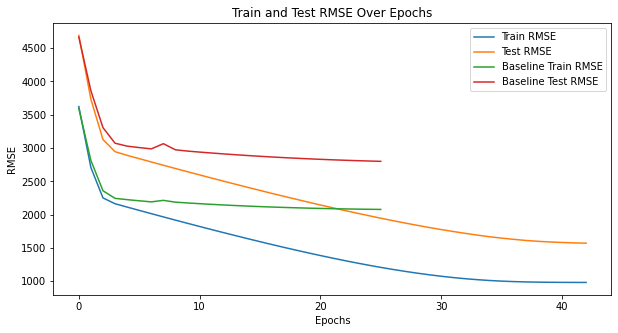

In [201]:
# 训练结束后绘制损失曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train RMSE')
plt.plot(test_losses, label='Test RMSE')
plt.plot(baseline_train_losses, label='Baseline Train RMSE')
plt.plot(baseline_test_losses, label='Baseline Test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Train and Test RMSE Over Epochs')
plt.legend()
plt.show()

##### 2) 影响LSTM的性能的10大参数与手段

- **神经网络的性能与效果金三角**

神经网络的性能是一个由架构、数据和调参三大支柱共同构建的复杂体系。在这个体系中，架构定义了模型解决问题的基础能力，好比是建筑的结构蓝图，决定了性能的基础线。数据则像是建筑材料，其质量和丰富度设定了模型性能的天花板，即性能的潜在上限。而调参过程则犹如精细的工程施工，通过微调和优化超参数来推动模型性能向这个上限靠拢。在神经网络的世界里，架构描绘了成功的可能性，数据确定了成功的边界，而调参则是实现这一成功的关键行动。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2023DL/LSTM/%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E7%9A%84%E6%80%A7%E8%83%BD%E4%B8%89%E8%A6%81%E7%B4%A02.png)

**神经网络的调参是一个极其艰难的过程**——

1. 神经网络的**参数空间往往远比机器学习算法要复杂**（甚至连算法的结构本身都是超参数的一部分）、参数之间的互相关联程度也会更复杂

2. 从baseline建立开始、**数据和架构都会受到初始参数的影响**。因此神经网络的调参不是从特征工程做好后开始、而是从baseline建立的最初就开始了。

3. **一边训练、一边调参**是神经网络的常态，要得到漂亮的损失下降曲线、参数的调节是必不可少的

4. 当损失曲线已经比较漂亮之后，调参只能主攻两大方向：**抗过拟合、性能微调**

- **神经网络训练过程中一般有哪些参数？**

1. 网络架构相关的参数：层数、每层的节点数、激活函数等如何影响模型。

2. 学习率：学习率的选择如何影响训练过程和模型性能、是否使用学习率优化、是否进行学习率迭代都会影响模型。

3. 优化器：不同优化器的特点，如SGD、Adam、RMSprop等，不同的优化器还有存在、是否使用权重衰减等情况。

4. 数据分割相关的参数：批大小（Batch Size）、窗口大小、多步预测的步数

5. 初始化参数

6. 抗过拟合手段：L1/L2正则化、Dropout等技术如何帮助防止过拟合。

本次LSTM我们将针对以下的参数来进行调整——

1. 学习率大小调整
2. 是否使用dropout层
3. 是否使用学习率调度
4. 是否使用adam优化算法的权重衰减
5. 调整网络架构（向着对抗过拟合的方向）
6. 调整滑窗的窗口大小window_size
7. 调整训练用的batch_size
8. 调整多步预测的步数pred_len
9. 设置损失函数上的L1正则化
10. 对模型进行噪音注入

|影响力|参数|有影响力的阶段|
|:-:|:-:|:-:|
|⭐⭐⭐⭐⭐<br>几乎总是具有巨大影响力|learning_rate（学习能力与学习速率）<br><br>hidden_size（整体学习能力）<br><br> early_stop_alpha（抗过拟合）|<font color="green">**任何时候**</font><br><br><font color="orange">**baseline阶段**</font><br><br><font color="orange">**baseline阶段**</font>|
|⭐⭐⭐⭐<br>大部分时候具有影响力|window_size（数据划分）<br><br>batch_size（学习能力与学习速率）<br><br>dropout（抗过拟合）<br><br>更换优化算法（整体学习能力）<br><br>noise_level|<font color="green">**任何时候**</font><br><br><font color="green">**任何时候**</font><br><br><font color="green">**任何时候**</font><br><br><font color="orange">**baseline阶段**</font><br><br><font color="orange">**baseline阶段**</font>|
|⭐⭐<br>可能有大影响力<br>但在某些数据上影响是不利的/不明显的|weight_decay（抗过拟合）<br><br>lr_decay（抗过拟合&学习速率）<br><br>l1_lambda（抗过拟合）<br><br>pre_len（数据划分）|<font color="purple">**调参阶段**<br><br>**调参阶段**<br><br>**调参阶段**</font><br><br><font color="orange">**baseline阶段**</font>|
|⭐<br>当数据量足够大时几乎无影响|初始化（随机性）<br><br>seed（随机性）|<font color="orange">**baseline阶段**</font><br><br><font color="green">**任何时候**</font>|

- **训练流程的打包与调参函数**

In [239]:
import numpy as np #数据处理
import pandas as pd #数据处理
import matplotlib as mlp
import matplotlib.pyplot as plt #绘图
from sklearn.preprocessing import MinMaxScaler #·数据预处理
from sklearn.metrics import mean_squared_error
import torch 
import torch.nn as nn #导入pytorch中的基本类
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.utils.data as data
# typing 模块提供了一些类型，辅助函数中的参数类型定义
from typing import Union,List,Tuple,Iterable
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from decimal import ROUND_HALF_UP, Decimal
import time

In [ ]:
selected_new_feature_train = pd.read_csv(r"selected_new_feature_train.csv",index_col=0)
selected_new_feature_test = pd.read_csv(r"selected_new_feature_test.csv",index_col=0)

In [304]:
from torch_lr_finder import LRFinder

def create_multivariate_dataset_4(dataset, window_size, pred_len):
    """
    将多变量时间序列转变为能够用于训练和预测的数据，确保每个窗口内的Securities Code唯一
    
    参数:
        dataset: DataFrame，其中包含特征和标签，特征从索引3开始，最后一列是标签
        window_size: 滑窗的窗口大小
    """
    X, y, y_indices = [], [], []
    for i in range(len(dataset) - window_size - pred_len + 1):
        # 检查窗口内的Securities Code是否唯一
        securities_code = dataset.iloc[i:i + window_size, 2]
        if len(securities_code.unique()) == 1:  # 如果Securities Code在窗口内唯一
            # 选取从第4列到最后一列的特征和标签
            feature_and_label = dataset.iloc[i:i + window_size, 3:].copy().values
            # 长度pred_len的标签作为目标
            target = dataset.iloc[(i + window_size):(i + window_size + pred_len), -1]
            
            # 记录本窗口中要预测的标签的时间点
            target_indices = list(range(i + window_size, i + window_size + pred_len))

            X.append(feature_and_label)
            y.append(target)
            #将每个标签的索引添加到y_indices列表中
            y_indices.extend(target_indices)
            
    X = torch.FloatTensor(np.array(X, dtype=np.float32))
    y = torch.FloatTensor(np.array(y, dtype=np.float32))            

    return X, y, y_indices

def set_seed(seed_value=1):
    random.seed(seed_value)  # Python内置的随机库
    np.random.seed(seed_value)  # Numpy库
    torch.manual_seed(seed_value)  # 为CPU设置种子
    torch.cuda.manual_seed(seed_value)  # 为当前GPU设置种子
    torch.cuda.manual_seed_all(seed_value)  # 为所有GPU设置种子
    torch.backends.cudnn.deterministic = True  # 确保每次返回的卷积算法将是确定的
    torch.backends.cudnn.benchmark = False

def train_LSTM(adjust_hyp_name
               , adjust_hyp
               , selected_new_feature_train
               , selected_new_feature_test
               , hidden_size = 50 #LSTM隐藏状态的维度
               , num_layers = 1 #隐藏层的层数
               , n_epochs = 3000 #迭代epoch
               , learning_rate = 0.01 #学习率
               , window_size = 30 #窗口大小
               , pre_len = 5 #多步预测的步数
               , batch_size = 32
               , random_state = 2 #随机数种子
               , weight_decay = 0 #权重衰减值
               , dropout_ratio = 0 #是否设置Dropout
               , lr_decay = False #是否设置学习率调度
               , lr_decay_step = 200 #学习率衰减的频率
               , lr_decay_gamma = 0.98 #学习率衰减的比率
               , l1_lambda = 0 #设置损失函数上的正则化
               , noise_level=0.0 #噪声设置
              ):
    #设置参数
    input_size = selected_new_feature_train.shape[1]-3  #输入特征的维度
    
    #对数据进行滑窗
    X_train_final, y_train_final, y_train_indices = create_multivariate_dataset_4(selected_new_feature_train, window_size, pred_len)
    X_test_final, y_test_final, y_test_indices = create_multivariate_dataset_4(selected_new_feature_test, window_size, pred_len)

    set_seed(2)
    
    #定义架构
    class MyLSTM(nn.Module):
        def __init__(self, input_dim, seq_length, pred_len, hidden_size, num_layers, dropout_ratio, noise_level=0.0):
            super().__init__()
            self.noise_level = noise_level  # 添加一个噪声级别的属性
            self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_size,
                                num_layers=num_layers, batch_first=True)
            self.dropout = nn.Dropout(dropout_ratio)
            self.linear = nn.Linear(hidden_size, pred_len)

        def forward(self, x):
            if self.training and self.noise_level > 0:  # 只有在训练模式且噪声级别大于0时，才添加噪声
                noise = torch.randn_like(x) * self.noise_level
                x = x + noise  # 向输入数据添加噪声
            x, _ = self.lstm(x)
            if dropout_ratio > 0:
                x = self.dropout(x)
            # 现在我要的是最后一个时间步，而不是全部时间步了
            x = self.linear(x[:, -1, :])
            return x


    #是否设置学习率调度
    #每lr_decay_step个epochs学习率乘以lr_decay_gamma
    if lr_decay == True:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_gamma)
        
    #设置GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #print(device)

    #实例化模型
    model = MyLSTM(input_size, window_size, pred_len,hidden_size, num_layers,dropout_ratio, noise_level=noise_level).to(device)
    optimizer = optim.Adam(model.parameters(),lr=learning_rate, weight_decay=weight_decay) #定义优化器
    loss_fn = nn.MSELoss() #定义损失函数
    loader = data.DataLoader(data.TensorDataset(X_train_final, y_train_final)
                             #每个表单内部是保持时间顺序的即可，表单与表单之间可以shuffle
                             , shuffle=True
                             , batch_size=batch_size) #将数据分批次
    
    #是否设置损失函数上的正则化
    if l1_lambda > 0:
        l1_norm = sum(p.abs().sum() for p in model.parameters())

    # 初始化早停参数
    early_stopping_patience = 3  # 设置容忍的epoch数，即在这么多epoch后如果没有改进就停止
    early_stopping_counter = 0  # 用于跟踪没有改进的epoch数
    best_train_rmse = float('inf')  # 初始化最佳的训练RMSE
    
    start = time.time()

    #开始训练

    model_path = f'best_model_{adjust_hyp_name}_{adjust_hyp}.pth'  # 设置模型保存路径

    train_losses = []
    test_losses = []

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            optimizer.zero_grad()  # 将清除梯度的操作移到循环开始
            y_pred = model(X_batch.to(device))

            if l1_lambda > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss_fn(y_pred, y_batch.to(device)) + l1_lambda * l1_norm
            else:
                loss = loss_fn(y_pred, y_batch.to(device))

            loss.backward()
            optimizer.step()
        
        if lr_decay:
            scheduler.step()

        #验证与打印
        if epoch % 50 == 0:
            model.eval()
            with torch.no_grad():
                y_pred = model(X_train_final.to(device)).cpu()
                train_rmse = np.sqrt(loss_fn(y_pred, y_train_final))
                y_pred = model(X_test_final.to(device)).cpu()
                test_rmse = np.sqrt(loss_fn(y_pred, y_test_final))
           # print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

            # 将当前epoch的损失添加到列表中
            train_losses.append(train_rmse)
            test_losses.append(test_rmse)

            # 早停检查
            if  best_train_rmse - train_rmse > 10:
                best_train_rmse = train_rmse
                early_stopping_counter = 0  # 重置计数器

                # 保存模型权重
                torch.save(model.state_dict(), model_path)

            else:
                early_stopping_counter += 1  # 增加计数器
                if early_stopping_counter >= early_stopping_patience:
                    #print(f"Early stopping triggered after epoch {epoch}. Training RMSE did not decrease for {early_stopping_patience} consecutive epochs.")
                    #print(f"Model weights saved to {model_path} at epoch {epoch}")
                    break  # 跳出训练循环

    print(f"spending:{time.time() - start}")
    return train_losses[-1], test_losses[-1], epoch

1. 学习率大小调整
2. 是否使用dropout层
3. 是否使用学习率调度
4. 是否使用adam优化算法的权重衰减
5. 调整网络架构（向着对抗过拟合的方向）
6. 调整滑窗的窗口大小window_size
7. 调整训练用的batch_size
8. 调整多步预测的步数pred_len
9. 设置损失函数上的L1正则化
10. 对模型进行噪音注入

In [309]:
import pandas as pd

# 参数及其备选取值
param_grid = {
    #'learning_rate': np.linspace(0.01, 0.1, 5),  # 生成5个介于0.01和0.1之间的均匀间隔的值
    #'dropout_ratio': [0.02,0.05, 0.1, 0.2],
    #'lr_decay': [True, False],
    #'weight_decay': np.linspace(0.95, 0.99, 5),  # 生成5个介于0.95和0.99之间的均匀间隔的值
    #'weight_decay':[0.995,0.999],
    #'hidden_size': [30, 40, 75, 90],
    #'window_size': [7, 10, 20, 40, 50, 60],
    #'batch_size': [16, 32, 64, 128],
    #'pre_len': [5, 7, 10, 15, 20, 25, 30],
    #'l1_lambda': np.random.uniform(0, 0.5, 5), # 从0到0.5之间随机选择5个值
    #'noise_level': np.random.uniform(0, 0.5, 5),  # 从0到0.5之间随机选择5个值
    'l1_lambda': np.linspace(0.1, 0.5, 5), # 从0到0.5之间随机选择5个值
    'noise_level': np.linspace(0.1, 0.5, 5)  # 从0到0.5之间随机选择5个值
}

lr_decay_params = {
    'lr_decay_step': [100,200,300],
    'lr_decay_gamma': [0.9,0.95,0.98]
}

# 初始化结果DataFrame
#results_df = pd.DataFrame(columns=['Parameter', 'Value', 'Min Train Loss', 'Min Test Loss','Actual Epoch'])

# 迭代每个参数
for param, values in param_grid.items():
    # 迭代每个参数的备选取值
    for value in values:
        # 创建一个包含所有默认参数的字典，这里需要你填入train_LSTM函数的默认参数值
        train_params = {
            'adjust_hyp_name': param,
            'adjust_hyp': value,
            'selected_new_feature_train': selected_new_feature_train,
            'selected_new_feature_test': selected_new_feature_test,
            'hidden_size': 50,
            'num_layers': 1,
            'n_epochs': 3000,
            'learning_rate': 0.03,
            'window_size': 30,
            'pre_len': 5,
            'batch_size': 32,
            'random_state': 2,
            'weight_decay': 0,
            'dropout_ratio': 0,
            'lr_decay': False,
            'lr_decay_step': 200,
            'lr_decay_gamma': 0.98,
            'l1_lambda': 0,
            'noise_level': 0.0
        }
        
        # 对于 lr_decay 的特殊处理
        if param == 'lr_decay' and value:
            for lr_decay_param, lr_decay_values in lr_decay_params.items():
                for lr_decay_value in lr_decay_values:
                    train_params[lr_decay_param] = lr_decay_value
                    
                    print(f'traning...{param}...{value}<br>{lr_decay_param}...{lr_decay_value}')
                    
                    # 调用训练函数并保存实验结果
                    min_train_loss, min_test_loss, actual_epoch = train_LSTM(**train_params)
                    new_row = pd.DataFrame({'Parameter': f'{param} with {lr_decay_param}', 
                                            'Value': f'{value} with {lr_decay_value}', 
                                            'Min Train Loss': [min_train_loss], 
                                            'Min Test Loss': [min_test_loss], 
                                            'Actual Epoch': [actual_epoch]})
                    results_df = pd.concat([results_df, new_row], ignore_index=True)
        else:
            train_params[param] = value
            # 调用训练函数并保存实验结果
            print(f'traning...{param}...{value}')
            min_train_loss, min_test_loss, actual_epoch = train_LSTM(**train_params)
            new_row = pd.DataFrame({'Parameter': [param], 
                                    'Value': [value], 
                                    'Min Train Loss': [min_train_loss], 
                                    'Min Test Loss': [min_test_loss], 
                                    'Actual Epoch': [actual_epoch]})
            results_df = pd.concat([results_df, new_row], ignore_index=True)
        
        print(param, value, min_train_loss, min_test_loss, actual_epoch)

traning...l1_lambda...0.1
spending:129.57495093345642
l1_lambda 0.1 tensor(2304.3977) tensor(3187.0535) 350
traning...l1_lambda...0.2
spending:275.8246877193451
l1_lambda 0.2 tensor(2292.9082) tensor(3112.1992) 750
traning...l1_lambda...0.30000000000000004
spending:273.2951669692993
l1_lambda 0.30000000000000004 tensor(2428.5698) tensor(2949.5359) 750
traning...l1_lambda...0.4
spending:259.47511100769043
l1_lambda 0.4 tensor(2215.1682) tensor(3017.7803) 700
traning...l1_lambda...0.5
spending:131.36440229415894
l1_lambda 0.5 tensor(2326.1577) tensor(3183.6548) 350
traning...noise_level...0.1
spending:212.97655248641968
noise_level 0.1 tensor(980.6830) tensor(1561.1344) 800
traning...noise_level...0.2
spending:69.50196480751038
noise_level 0.2 tensor(2290.8865) tensor(3067.8877) 250
traning...noise_level...0.30000000000000004
spending:220.49021816253662
noise_level 0.30000000000000004 tensor(980.6808) tensor(1560.9854) 800
traning...noise_level...0.4
spending:211.82554268836975
noise_lev

In [310]:
results_df

,Parameter,Value,Min Train Loss,Min Test Loss,Actual Epoch
0,learning_rate,0.01,tensor(981.1358),tensor(1570.6328),2100
1,learning_rate,0.0325,tensor(980.6733),tensor(1560.7960),750
2,learning_rate,0.055,tensor(952.7551),tensor(1521.1550),650
3,learning_rate,0.0775,tensor(2282.3538),tensor(3053.8347),200
4,learning_rate,0.1,tensor(949.5282),tensor(1516.2089),450
...,...,...,...,...,...
63,noise_level,0.1,tensor(980.6830),tensor(1561.1344),800
64,noise_level,0.2,tensor(2290.8865),tensor(3067.8877),250
65,noise_level,0.3,tensor(980.6808),tensor(1560.9854),800
66,noise_level,0.4,tensor(980.6993),tensor(1562.0463),800


In [311]:
results_df.to_csv("results_df.csv")

In [322]:
results_df

,Parameter,Value,Min Train Loss,Min Test Loss,Actual Epoch
0,learning_rate,0.01,981.135803,1570.632812,2100
1,learning_rate,0.0325,980.673340,1560.796021,750
2,learning_rate,0.055,952.755127,1521.155029,650
3,learning_rate,0.0775,2282.353760,3053.834717,200
4,learning_rate,0.1,949.528198,1516.208862,450
...,...,...,...,...,...
63,noise_level,0.1,980.682983,1561.134399,800
64,noise_level,0.2,2290.886475,3067.887695,250
65,noise_level,0.3,980.680786,1560.985352,800
66,noise_level,0.4,980.699341,1562.046265,800


In [321]:
results_df["Min Train Loss"] = results_df["Min Train Loss"].apply(lambda x : x.item())
results_df["Min Test Loss"] = results_df["Min Test Loss"].apply(lambda x : x.item())

In [329]:
sorted_df = results_df.groupby("Parameter", group_keys=False).apply(lambda x: x.sort_values("Min Train Loss"))

In [331]:
pd.set_option('display.max_rows', None)
sorted_df

,Parameter,Value,Min Train Loss,Min Test Loss,Actual Epoch
37,batch_size,16,960.248901,1532.726440,500
38,batch_size,32,980.683960,1636.764526,800
40,batch_size,128,2290.885986,3067.604248,350
39,batch_size,64,2290.886230,3067.721680,300
9,dropout_ratio,0.02,952.390625,1540.279785,400
10,dropout_ratio,0.05,987.327332,1610.315552,350
11,dropout_ratio,0.1,1006.481201,1666.470703,350
5,dropout_ratio,0.2,1060.972290,1770.289307,750
12,dropout_ratio,0.2,1078.203125,1792.350952,350
6,dropout_ratio,0.3,1644.891357,2701.602783,1000


In [ ]:
pd.set_option('display.max_rows', 20)

In [332]:
#取出trainloss最小的行的索引
idx = results_df.groupby("Parameter")["Min Train Loss"].idxmin()

In [333]:
min_train_loss_rows = results_df.loc[idx]

In [334]:
min_train_loss_rows

,Parameter,Value,Min Train Loss,Min Test Loss,Actual Epoch
37,batch_size,16,960.248901,1532.726440,500
9,dropout_ratio,0.02,952.390625,1540.279785,400
27,hidden_size,30,1774.871216,2312.230469,750
51,l1_lambda,0.217661,1326.882202,2161.160645,900
4,learning_rate,0.1,949.528198,1516.208862,450
19,lr_decay,False,949.528198,1516.208862,450
16,lr_decay with lr_decay_gamma,True with 0.9,949.528198,1516.208862,450
13,lr_decay with lr_decay_step,True with 100,949.528198,1516.208862,450
56,noise_level,0.149827,980.679077,1558.025757,1050
41,pre_len,5,980.683960,1636.764526,800
